In [1]:
import time as TIME
START_TIME = TIME.time()

In [2]:
#imports
from PIL import Image,ImageDraw,ImageFont
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as ipy
from io import BytesIO
import numpy as np
import math 
import sys
import os
_=plt.ioff()

In [3]:
#group size
ROOM1_GROUP_SIZE = [2,2,2,1,2,2,2,4,1,1,2,1,1,3,5,2,2,4,2,1,1,1,2,2,3,2,3,5,4,3,4,2,2,1,2,4,2,2,3,3,2,4,2,4,2,3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,4,2,2,2,2,2,5,2,8,2,8,2,3,2,3,2,3,4,2,5,1,2,1,1,2,2,1,1,1,0,2,2,1,1,3,2,1,1,3,2,2,2,4,2,2,2,2,1,5,1,2,2,6,2,2,2,1,2,2,2,1,2,2,2,2,4,2,2,1,2,4,2,3,2,2,1,1,2,1,2,2,1,1]
ROOM1_HAS_KIDS =   [0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
def addGroupSize(path):
    num = path['userNum']
    path['groupSize'] = ROOM1_GROUP_SIZE[num] if num <len(ROOM1_GROUP_SIZE) else 0
    path['hasKids'] = bool(ROOM1_HAS_KIDS[num]) if num <len(ROOM1_HAS_KIDS) else 0

In [4]:
#CONSTANTS
MAX_NEAR_ONE = 1-sys.float_info.epsilon
IMAGE_FOLDER = 'C:/Users/Nateg/OneDrive/Documents/Python/Enlightenment/graphs'
def getRoomImage(number, scale):
    room= Image.open('C:/Users/Nateg/OneDrive/Documents/Python/Enlightenment/room'+str(number)+'.png')
    w,h = room.size
    return room.resize((int(w*scale),int(h*scale)),Image.Resampling.NEAREST)

def getRoomFolder(number):
    return 'C:/Users/Nateg/OneDrive/Documents/Python/Enlightenment/Room '+str(number)

def fixHeight(point,num):
    x,y,a = point
    nate_fix = 1/.71
    henry_fix = 1/.97
    if 26<=num<=50:
        return (x,np.clip(y*nate_fix,0,MAX_NEAR_ONE),a)
    elif 14<=num<=25 or 66<=num<=75:
        return (x,np.clip(y*henry_fix,0,MAX_NEAR_ONE),a)
    else:
       return point 

def getMask(img):
    fn = lambda x: (int(x[0])+int(x[1])+int(x[2])) // (255*3) * 255
    array = np.array(img)
    maskData = np.array(np.apply_along_axis(fn,2,array),dtype=np.uint8)
    mask = Image.fromarray(maskData)
    return mask

SCALE4 = 8
ROOM4 = getRoomImage(4,SCALE4)
FOLDER4 = ([getRoomFolder(4)],14*SCALE4,ROOM4,lambda x,y:x,lambda x:x)

SCALE2 = 1
ROOM2 = getRoomImage(2,SCALE2)
FOLDER2 = ([getRoomFolder(2)],65*SCALE2,ROOM2,lambda x,y:x,lambda x:x)

SCALE1 = 1
ROOM1 = getRoomImage(1,SCALE1)
ROOM1LEGEND = getRoomImage('1L',SCALE1)
FOLDER1 = ([getRoomFolder(1)],35*SCALE1,ROOM1,fixHeight,addGroupSize)


SCALE2V2 = SCALE2
ROOM2V2 = ROOM2
FOLDER2V2 = ([getRoomFolder('2v2')],FOLDER1[1],ROOM2,lambda x,y:x,lambda x:x)

SCALE2BOTH = SCALE2
ROOM2BOTH = ROOM2
FOLDER2BOTH = ([getRoomFolder('2'),getRoomFolder('2v2')],FOLDER1[1],ROOM2,lambda x,y:x,lambda x:x)

LAYOUT = {'width': 'max-content'}

ROOM1MASK = getMask(ROOM1)
ROOM2MASK = getMask(ROOM2)

assert ROOM1.size==ROOM1LEGEND.size

In [5]:
#file opener
CONTROL = 2**16-1
USER_TYPES = ['Browser','Completionist','Goal-Oriented','Pass-Though']
def fromBytes(byte,big = False):
    return int.from_bytes(byte,"big" if big else "little");

def magicCheck(file):
    magic = file.read(7)
    if magic!=b"Natenli":
        raise EOFError("did not find magic number")
        
def addMetadata(file,obj):
    byteNames = ['filetype','rate']
    for j,name in enumerate(byteNames):
        b = file.read(1)
        if len(b)==0:
            raise EOFError("reached end of file before end of metadata")
        obj[name] = fromBytes(b)
    if obj['filetype'] < 7:
        raise EOFError("file type too old")
    elif obj['filetype'] > 7:
        raise EOFError("file type too new")

def addUserNum(file,obj):       
    b = file.read(2)
    if len(b)!=2:
        raise EOFError("reached end of file before end of userNum")
    obj['userNum'] = fromBytes(b)
        
def addTime(file,obj):
    b = file.read(5)
    num = fromBytes(b,True)
    
    obj['userType']=num>>36&3
    obj['userTypeName']=USER_TYPES[obj['userType']]
    obj['time']['month']=num>>32&15
    obj['time']['day']=num>>27&31
    obj['time']['hour']=num>>22&31
    obj['time']['minute']=num>>16&63
    obj['time']['second']=num>>10&63
    obj['time']['millis']=num&1023
    
def addSpecial(obj,control,byte):
    if control==CONTROL:
        if 'leftover' in obj:
            obj['leftover'] += 1
        else:
            obj['leftover'] = 1
    elif 'leftover' in obj:
            raise EOFError("found other controls after double control")
    elif len(obj['points'])==0:
        raise EOFError("control can not be first")
    else:
        x,y,_ = obj['points'][-1]
        obj['points'][-1] = (x,y,byte.decode())
        
    
def addPoints(file,obj):
    while(True):
        point = file.read(4)
        if len(point)==0:
            break
        if len(point)!=4:
            raise EOFError("reached end of file before point data")
        x = fromBytes(point[:2])
        y = fromBytes(point[2:])
        
        #special
        if x==CONTROL:
            addSpecial(obj,y,point[2:])
        elif y==CONTROL:
            raise EOFError("y is control without x")
        elif 'leftover' in obj:
            raise EOFError("found other points after double control")
        else:
            obj['points'].append((x/CONTROL,y/CONTROL,''))
    
        
def enlighten(path):
    file=open(path,"rb")
    magicCheck(file)
    obj = {'points':[],'time':{}}
    addMetadata(file,obj)
    addUserNum(file,obj)
    addTime(file,obj)
    addPoints(file,obj)
    return obj

In [6]:
#folder opener

def isTooFast(points,index,settings):
    w,h=settings[2].size
    x,y,_ = points[index-1]
    x2,y2,_ = points[index]
    return math.hypot((x-x2)*w,(y-y2)*h)>settings[1]

def speedBound(path,settings):
    index = 1
    pointsF=path['points']
    pointsR=path['points'].copy()
    boundedF = 0
    boundedR = 0
    
    #forward speed bounding
    while index<len(pointsF):
        if isTooFast(pointsF,index,settings):
            pointsF[index] = pointsF[index-1]
            boundedF+=1
        index+=1
        
    #reverse speed bounding
    index=len(pointsR)-1
    while index>0:
        if isTooFast(pointsR,index,settings):
            pointsR[index-1] = pointsF[index]
            boundedR+=1
        index-=1 
    
    #get better one
    if boundedF<boundedR:
        path['bounded'] = boundedF
    else:
        path['bounded'] = boundedR
        path['points'] = pointsR

def speedBoundBetter(path,settings):
    points=path['points']
    bounded = 0
    middle = len(points)//2
    
    #backward speed bounding
    for j in range(middle-1,-1,-1):
        if isTooFast(points,j+1,settings):
            points[j] = points[j+1]
            # points[j] = points[j+1]=points[j+2]
            # if j-1>=0:
            #     points[j-1] = points[j]
            bounded+=1
        
    #forward speed bounding
    for j in range(middle+1,len(points)):
        if isTooFast(points,j,settings):
            points[j] = points[j-1]
            # points[j]= points[j-1] = points[j-2]
            # if j+1<len(points):
            #     points[j+1] = points[j]
            bounded+=1
        
    path['bounded'] = bounded
        
def applyFix(points,settings,num):
    return list(map(lambda x: settings[3](x,num),points))

def getNum(str):
    index = str.rfind('_')
    return int(str[index+1:])
    
def enlightenFolder(settings,fn,start,afterfn = lambda x: x, speedBounding=True):
    for i in settings[0]:
        for j in os.listdir(i):
            path = os.path.join(i, j)
            if os.path.isfile(path):
                pathData = enlighten(path)
                pathData['file'] = j
                pathData['points'] =  applyFix(pathData['points'],settings,pathData['userNum'])
                if speedBounding:
                    speedBoundBetter(pathData,settings)
                settings[4](pathData)
                new=fn(pathData,start)
                if new is not None:
                    start=new
    return afterfn(start)

In [7]:
#Cropping Data
ENTRANCES = ['left','top','right','bottom']
#left, upper, right, and lower
SELECT_BOXES4 = [(0,0,.45,1),(0,0,1,.15),(.55,0,1,1),(0,.85,1,1)]
SELECT_BOXES2V2 = [(.75,.25,1,.75),(.25,.75,.75,1),(0,.25,.25,.75)]
SELECT_BOXES2 = [(.75,.25,1,.75),(.25,.75,.75,1)]
SELECT_BOXES1 = [(.55,0,1,1),(0,.85,1,1),(0,0,.45,1)]

ROOM1_TRIANGLES=[(.95,.5,.025,2),(.5,.95,.025,1),(.05,.5,.025,0)]

DISPLAY_BOXES1 = {
    "11":(1308,260,1308+130,260+97),
    "12":(1308,109,1308+130,109+97),
    "13":(1042,260,1042+132,260+97),
    "14":(1042,109,1042+132,109+97),
    "Va":(1174,166,1174+134,166+135),
    "In":(1174,344,1174+134,344+97)
}

DISPLAY_BOXES1_CASES = dict(list(DISPLAY_BOXES1.items())[:-2])

DISPLAY_BOXES2 = {
    "Up":(148,48,148+76,48+121),
    "Down":(147,371,147+75,371+122),
}

def cropRoom4(image,scale):
    def crop(img):
        return img.crop((112*scale, 0, 168*scale, img.size[1]))
    if isinstance(image,tuple):
        return tuple([crop(image[0])]+list(image[1:]))
    return crop(image)

def cropRoom1(image,scale):
    def crop(img):
        return img.crop((946*scale, 0, 1535*scale, img.size[1]))
    if isinstance(image,tuple):
        return tuple([crop(image[0])]+list(image[1:]))
    return crop(image)

In [8]:
#image functions

def matplotToPil(fig,bbox = None):
    buf = BytesIO()
    fig.savefig(buf,bbox_inches=bbox)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    return img

def makeFigure(size,image,placement=None,gap = 0,back=(255,255,255)):
    cw,ch = size
    w,h = image.size
    if placement is None:
        placement = ((cw-1)//2,(ch-1)//2)
    pw,ph = placement
    img=Image.new('RGB', ((w+gap)*cw-gap,(h+gap)*ch-gap),back)
    img.paste(image,((w+gap)*pw,(h+gap)*ph))
    return (img,w,h,gap)


def addToFigure(fig,image,placement=None):
    img,w,h,gap = fig 
    pw,ph = placement
    img.paste(image,((w+gap)*pw,(h+gap)*ph))
    return fig

def saveImage(fig,room,name):
    filename=  f'{IMAGE_FOLDER}/room{room}/{name}.png'
    Path(filename).parents[0].mkdir(parents=True, exist_ok=True)
    fig.convert('RGB').save(filename)

def saveGif(bytes,room,name):
    Path(f'{IMAGE_FOLDER}/room{room}').mkdir(parents=True, exist_ok=True)
    f = open(f'{IMAGE_FOLDER}/room{room}/{name}.gif', 'wb')
    f.write(bytes.getbuffer())
    f.close()

def displayGif(bytes):
    return ipy.Image(value=bytes.getbuffer(),format='gif')

# Analysis

In [9]:
#testing
def maxSpeedRemoved(path,arg):
    if path['bounded']>0:
        arg.append((path['file'],path['bounded']))

def getMostRight(path,arg):
    for j in path['points']:
        if j[0]>arg[1]:
            arg = (path['file'],j[0]) 
    return arg

def sortSpeedRemoved(arg):
    return list(sorted(arg,key=lambda x:x[1]))

In [10]:
#croping and selecting

GROUP_SIZE_NAMES = ['1','2','3','4+']

def addToDict(dict,index,num):
    if index in dict:
        dict[index]+=num
    else:
        dict[index]=num

def isInBox(point,box):
    return box[0] <= point[0] <= box[2] and box[1] <= point[1] <= box[3]

def selectEntrance(fn,box):
    def select(path,arg):
        x,y,_ = path['points'][0]
        if isInBox(path['points'][0],box):
            return fn(path,arg)
    return select
    
def selectUserType(fn,num):
    def select(path,arg):
        if path['userType']==num:
            return fn(path,arg)
    return select

def selectGroupSize(fn,num):
    def select(path,arg):
        if path['groupSize']==num or (num==4 and path['groupSize']>=4):
            return fn(path,arg)
    return select

def getDirOffset(num):
    angle=num/2*math.pi
    return (-int(math.cos(angle)),int(math.sin(angle)))
    
def displayBox(image,box):
    x,y,x2,y2 = box
    w,h = image.size
    im = image.copy()
    draw = ImageDraw.Draw(im)
    draw.rectangle((x*w,y*h,x2*w,y2*h),PURPLE)
    return im
    
def displaySpeedBox(image,speed):
    w,h = image.size
    im = image.copy()
    draw = ImageDraw.Draw(im)
    draw.ellipse((w/2-speed,h/2-speed,w/2+speed,h/2+speed),PURPLE)
    return im
    

In [11]:
#simple draw
PURPLE = (255,0,255)
def printRoom(path,arg):
    del path['points'][10:]
    arg.append(path)
    
def firstPoint(path,arg):
    (x,y,_) = path['points'][0]
    arg.append((x,y,path['userNum']))

def drawPathStart(room):
    return (room.copy(),0)

def drawPath(path,arg):
    points = path['points']
    w,h=arg[0].size
    draw = ImageDraw.Draw(arg[0])
    for j in range(1,len(points)):
        x,y,_ = points[j-1]
        x2,y2,_ = points[j]
        draw.line((x*w,y*h,x2*w,y2*h),PURPLE)

    
#historgram of time spent
#historgram of time spent after roseta box
#heatmap of case time

In [12]:
#color scales
def getWhitePurpleColor(prog,opacity):
    return (255,int((1-prog)*256),255,int(opacity*256))

def getPurpleColorFloat(prog,opacity=1):
    blue = 1
    red = 0
    if prog <.5:
        red = prog*2
    else:
        red=1
        blue = 1-(prog-.5)*2
    return (red,0,blue,opacity)

def getPurpleColor(prog,opacity=1):
    r,g,b,a = getPurpleColorFloat(prog,opacity)
    return (int(r*256),0,int(b*256),int(a*256))

def getDarkPurpleColor(prog,opacity=1):
    r = 237*prog
    g = -4*prog+24
    b = -134.8*prog+169.6
    return (int(r),int(g),int(b),int(opacity*256))

In [13]:
#opacity drawing

PURPLE_OPACITY = (255,0,255,int(255/8))

def opacityDrawerStart(image):
    return (image.copy(),)
    
def opacityDrawer(path,arg):
    points = path['points']
    w,h=arg[0].size
    overlay=Image.new('RGBA', arg[0].size,(0,0,0,0))
    draw = ImageDraw.Draw(overlay)
    for j in range(1,len(points)):
        x,y,_ = points[j-1]
        x2,y2,_ = points[j]
        draw.line((x*w,y*h,x2*w,y2*h), PURPLE_OPACITY,2)
    arg[0].alpha_composite(overlay)
    


def opacityDrawerColor(path,arg):
    points = path['points']
    length = len(points)
    w,h=arg[0].size
    overlay=Image.new('RGBA', arg[0].size,(0,0,0,0))
    draw = ImageDraw.Draw(overlay)
    for j in range(1,length):
        x,y,_ = points[j-1]
        x2,y2,_ = points[j]
        color=getPurpleColor(j/length,1/8)
        draw.line((x*w,y*h,x2*w,y2*h), color,2)
    arg[0].alpha_composite(overlay)

In [14]:
#counting numpy bad
def countPixelsStart(image):
    return np.zeros(image.size[::-1],np.int32)
    
def countPixelsOp(path,arg):
    points = path['points']
    w,h=arg.shape[::-1]
    im=Image.new('1', (w,h))
    draw = ImageDraw.Draw(im)
    for j in range(1,len(points)):
        draw.rectangle((0,0)+im.size,0)
        x,y,_ = points[j-1]
        x2,y2,_ = points[j]
        draw.line((x*w,y*h,x2*w,y2*h), 1,4)
        im.putpixel((int(x*w),int(y*h)),0)
        arg+=np.array(im)
    
    
def countPathEnd(arg):
    display(np.max(arg))
    mult = 255/np.max(arg)
    #fn = lambda x: display(x)#[int(x*mult),0,0,0]
    return Image.fromarray(np.asarray(arg[:,:,None]*[mult,0,mult,mult],np.uint8))

def countBoxPixelsStart(dim):
    return (np.zeros(dim,np.int32),)

def countBoxPixels(path,arg):
    points = path['points']
    w,h=arg[0].shape
    for j in range(0,len(points)):
        x,y,_ = points[j]
        arg[0][int(x*w),int(y*h)]+=1
        # for j in range(9):
        #     x2=int(x*w)
        #     y2=int(y*h)
        #     xo,yo = (j%3-1,j//3-1)
        #     if 0<=x2+xo<w and 0<=y2+yo<h:
        #         arg[0][x2+xo,y2+yo]+=1
            
    
def countBoxPixelsEnd(scale):
    def fn(arg):
        max = np.max(arg[0])
        def drawFunc(val):
            a = val/max
            #sig = 1/(1+math.e**(-10*a+5))
            return a*255
        h,w = arg[0].shape
        purple=np.array(PURPLE,dtype=np.uint8)
        tiled_purple = np.tile(purple, (w,h,1))
        image = Image.fromarray(np.dstack((tiled_purple,(drawFunc(arg[0])).astype(np.uint8).T)))
        return image.resize((int(w*scale[0]),int(h*scale[1])),Image.Resampling.NEAREST)
    return fn

def countBoxPixels2(path,arg):
    points = path['points']
    w,h=arg[0].shape
    for j in range(0,len(points)):
        x,y,_ = points[j]
        arg[0][int(x*w),int(y*h)]+=1
        for j in range(9):
            x2=int(x*w)
            y2=int(y*h)
            xo,yo = (j%3-1,j//3-1)
            if 0<=x2+xo<w and 0<=y2+yo<h:
                arg[0][x2+xo,y2+yo]+=1
    
def countBoxPixelsOverlayEnd(img):
    img=img.copy()
    def fn(arg):
        max = np.max(arg[0])
        def drawFunc(val):
            a = val/max
            #sig = 1/(1+math.e**(-10*a+5))
            return a*255
        h,w = arg[0].shape
        purple=np.array(PURPLE,dtype=np.uint8)
        tiled_purple = np.tile(purple, (w,h,1))
        image = Image.fromarray(np.dstack((tiled_purple,(drawFunc(arg[0])).astype(np.uint8).T)))
        img.alpha_composite(image.resize(img.size,Image.Resampling.NEAREST))
        return img
    return fn

In [15]:
#count behaviors
BEHAVIOR_MAP = {'DI': 'Discussed', 'PH': 'Photo', 'BL': 'Booklet'}

def countBehaviors(path,arg):
    a,b = arg
    behav = set()
    for j in path['points']:
        *_,be = j
        if be!='':
            behav.add(be)
    for j in behav:
        if j in a:
            a[j]+=1
        else:
            a[j]=1
    return (a,b+1)
            
def printBehaviors(arg):
    for j in arg[0]:
        behav = BEHAVIOR_MAP[j]
        print(behav,arg[0][j],'/',arg[1],'times for',arg[0][j]/arg[1])
    
def graphBehaviors(room):
    def fn(arg):
        fig, ax = plt.subplots()

        l = list(sorted(arg[0].items(),key=lambda x:x[1],reverse=True))
        
        plt.rc('font', size=8)  
        ax.bar(list(map(lambda x:BEHAVIOR_MAP[x[0]], l)), list(map(lambda x:x[1]/arg[1]*100, l)))
    
        ax.set_xlabel('Behaviors',fontsize=10)
        ax.set_ylabel('% of visitors',fontsize=10)
        ax.set_title(f'Visitor behaviors in Room {room}',fontsize=12)
        fig.tight_layout()
        return (matplotToPil(fig),)
    return fn

In [16]:
#average
def getAverage(path,arg):
    a,b = arg
    seconds = len(path['points'])/path['rate']
    return (a+seconds,b+1)

def getAverageEnd(name):
    def fn(arg):
        a,b,*_ = arg
        seconds = a/b
        return f'{getTimeFromSeconds(seconds)} average{name}'
    return fn

def getAverageBox(path,arg):
    a,b,image,box = arg
    count = 0
    w,h = image.size
    for j in path['points']:
        x,y,_ = j
        if isInBox((x*w,y*h),box):
            count+=1
    if count == 0:
        return None
            
    seconds =count//path['rate']
    return (a+seconds,b+1,image,box)

def getAverageBoxMin(min):
    def fn(path,arg):
        a,b,image,box = arg
        count = 0
        w,h = image.size
        for j in path['points']:
            x,y,_ = j
            if isInBox((x*w,y*h),box):
                count+=1

        seconds =count//path['rate']
        if seconds < min:
            return None
                
        return (a+seconds,b+1,image,box)
    return fn


In [17]:
#count time
#POINTS_PER_MINUTE = 4*60

def getTimeFromSeconds(secs,decimals = 0):
    #decimal = format(secs%60, f'.{decimals}f')
    return f'{int(secs//60)}:{int(secs%60):02}'


def countTimeSpent(path,arg):
    a,b = arg
    time= len(path['points'])//(path['rate']*60)
    if time in a:
        a[time]+=1
    else:
        a[time]=1
    return (a,b+1)
    
def graphTimes(name):
    def graph(arg):
        def getName(x):
            return '<1' if x[0]==0 else str(x[0])+'-'+str(x[0]+1)
            
        fig, ax = plt.subplots()
        
        fig.set_figheight(3)
        fig.set_figwidth(3)

        sort=sorted(arg[0].items(),key=lambda x: x[0])

        ax.bar(list(map(getName, sort)), list(map(lambda x: x[1]/arg[1],sort)))

        ax.set_xlabel('Minutes')
        ax.set_ylabel('% of visitors')
        ax.set_title('Percentage of '+name+'visitors time spent',fontsize = 10)
        plt.show()
        return (sort,arg[1])
    return graph

def countTimeSpentLess1(path,arg):
    a,b = arg
    seconds = len(path['points'])//path['rate']
    if seconds in a:
        a[seconds]+=1
    else:
        a[seconds]=1
    return (a,b+1)

def graphTimesLess1(name):
    def graph(arg):
        def getName(a,b,minutes=True):
            midText = '-'
            aText = bText = ''
            unit = 'm' if minutes else 's'
            if a==0:
                midText='<'
            else:
                aText = str(a)+unit
                
            bText = str(b)+unit
                
            return aText + midText + bText
            
        def getData(data,min,max):
            sum = 0
            for j in range(min,max):
                if j in data:
                    sum+=data[j]
            return sum
            
        data = []
        second_grams = [0,15,30,45,60]
        for j in range(1,len(second_grams)):
            data.append((getName(second_grams[j-1],second_grams[j],False),getData(arg[0],second_grams[j-1],second_grams[j])))

        for j in range(1,59):
            data.append((getName(j,j+1,True),getData(arg[0],j*60,(j+1)*60)))

        for j in range(len(data)-1,-1,-1):
            if data[j][1]==0:
                del data[j]

        plt.rc('font', size=4)  
        fig, ax = plt.subplots()
        
        fig.set_figheight(4)
        fig.set_figwidth(4)

        ax.bar(list(map(lambda x:x[0],data)), list(map(lambda x:x[1]/arg[1],data)))

        ax.set_xlabel('Time Spent',fontsize = 6)
        ax.set_ylabel('% of visitors',fontsize = 6)
        
        ax.set_title('Histogram of visitors time spent from '+name+' entrance',fontsize = 8)
        return (matplotToPil(fig),data,arg[1])
    return graph

def histTimesLess1(name,second_grams = [0,15,30,45,60]):
    def graph(arg):
        def getData(data,min,max):
            sum = 0
            for j in range(min,max):
                if j in data:
                    sum+=data[j]
            return sum

        maxMinutes = -(np.max(list(arg[0].keys()))//-60)
        
        data = []
        labels = []
        
        for j in range(1,len(second_grams)):
            data.append(getData(arg[0],second_grams[j-1],second_grams[j]))
            labels.append(str(second_grams[j-1])+'s')

        for j in range(1,maxMinutes):
            data.append(getData(arg[0],j*60,(j+1)*60))
            labels.append(str(j)+'m')
            
        labels.append(str(maxMinutes)+'m')
        
        plt.rc('font', size=8)  
        fig, ax = plt.subplots()
        
        fig.set_figheight(4)
        fig.set_figwidth(4)

        ax.stairs(list(map(lambda x:x/arg[1]*100,data)),labels,fill=True)

        ax.set_xlabel('Time Spent',fontsize = 8)
        ax.set_ylabel('% of visitors',fontsize = 8)
        
        ax.set_title('Histogram of visitors time spent from '+name+' entrance',fontsize = 8)
        return (matplotToPil(fig),data,arg[1])
    return graph

def histTimesLess1Room(name,second_grams = [0,15,30,45,60],size = 12):
    def graph(arg):
        def getData(data,min,max):
            sum = 0
            for j in range(min,max):
                if j in data:
                    sum+=data[j]
            return sum
        maxMinutes = -(np.max(list(arg[0].keys()))//-60)
        
        data = []
        labels = []
        
        for j in range(1,len(second_grams)):
            data.append(getData(arg[0],second_grams[j-1],second_grams[j]))
            labels.append(str(second_grams[j-1])+'s')

        for j in range(1,maxMinutes):
            data.append(getData(arg[0],j*60,(j+1)*60))
            labels.append(str(j)+'m')
            
        labels.append(str(maxMinutes)+'m')
        
        plt.rc('font', size=8)  
        fig, ax = plt.subplots()
        
        fig.set_figheight(4)
        fig.set_figwidth(4)

        ax.stairs(list(map(lambda x:x/arg[1]*100,data)),labels,fill=True)

        ax.set_xlabel('Time Spent',fontsize = 10)
        ax.set_ylabel('% of visitors',fontsize = 10)
        
        ax.set_title(f'Histogram of time spent{name}',fontsize = size)
        fig.tight_layout()
        
        return (matplotToPil(fig),data,arg[1])
    return graph

In [18]:
#count rosetta time
ROSETTA_BOX = (.475,.25,.55,.75)

def countRosettaTimeSpent(path,arg):
    a,b = arg
    num = 0
    for j in path['points']:
        if isInBox(j,ROSETTA_BOX):
            num+=1
    time= num//POINTS_PER_MINUTE
    if time in a:
        a[time]+=1
    else:
        a[time]=1
    return (a,b+1)

def countRosettaTimeSpentLess1(path,arg):
    a,b = arg
    num = 0
    for j in path['points']:
        if isInBox(j,ROSETTA_BOX):
            num+=1

    seconds  = num//path['rate']
    if seconds in a:
        a[seconds]+=1
    else:
        a[seconds]=1
    return (a,b+1)

In [136]:
#count display time
#({name:data},{name:box},image)
def countDisplayTime(path,arg):
    data,boxes,image,mask = arg
    w,h = image.size
    points = path['points']
    for j in points:
        x,y,_ = j
        for i in boxes:
            if isInBox((x*w,y*h),boxes[i]):
                if i in data:
                   data[i]+=1
                else:
                    data[i]=1
    #return (data,boxes,num,image,mask)

def countDisplayTimeMin(seconds):
    def fn(path,arg):
        data,boxes,image,mask = arg
        w,h = image.size
        points = path['points']
        pData = {}
        for j in points:
            x,y,_ = j
            for i in boxes:
                if isInBox((x*w,y*h),boxes[i]):
                    if i in pData:
                       pData[i]+=1
                    else:
                        pData[i]=1
        for j in pData:
            if pData[j]>=seconds*path['rate']:
                if j in data:
                    data[j]+=pData[j]
                else:
                    data[j]=pData[j]
    return fn 
 
def countDisplayHist(path,arg):
    data,num,box,image = arg
    w,h = image.size
    points = path['points']
    count = 0
    for j in points:
        x,y,_ = j
        if isInBox((x*w,y*h),box):
            count+=1
            
    seconds =count//path['rate']
    if seconds in data:
        data[seconds]+=1
    else:
        data[seconds]=1
    return (data,num+1,box,image)    

def countDisplayHistMin(path,arg):
    data,num,box,image = arg
    w,h = image.size
    points = path['points']
    count = 0
    for j in points:
        x,y,_ = j
        if isInBox((x*w,y*h),box):
            count+=1

    seconds =count//path['rate']
    if seconds == 0:
        return None
    
    if seconds in data:
        data[seconds]+=1
    else:
        data[seconds]=1
    return (data,num+1,box,image)
                    
def displayEnd(arg):
    img = arg[2].copy()
    max= np.max(list(arg[0].values()))
    overlay=Image.new('RGBA', arg[2].size,(255,255,255,0))
    draw = ImageDraw.Draw(overlay)
    for j in arg[0]:
        color= getPurpleColor(1-arg[0][j]/max,1/2);
        draw.rectangle(arg[1][j],color)
    img.alpha_composite(overlay)
    display(arg[0])
    return img

def displayEndMask(colorFunc,noPass=False): 
    def fn(arg):
        if noPass and ' ' in arg[0]:
            del arg[0][' ']
        img = arg[2].copy()
        max= np.max(list(arg[0].values()))
        
        overlay=Image.new('RGBA', img.size, (255,255,255,0))
        draw = ImageDraw.Draw(overlay)
        for j in arg[1]:
            val = 0
            if j in arg[0]:
                val = arg[0][j]
            color= colorFunc(val/max,1);
            draw.rectangle(arg[1][j],color)
        img.paste(overlay,(0, 0),arg[3])
        return (img,arg[0])
    return fn
    
def displayEndMask2(colorFunc,noPass=False): 
    def fn(arg):
        if noPass and ' ' in arg[0]:
            del arg[0][' ']
    
        for j in arg[1]:
            addToDict(arg[0],j,0)
        
        img = arg[2].copy()
        values = list(arg[0].values())
        max= np.max(values)
        min= np.min(values)

        # for j in arg[1]:
        #     if j not in arg[0]:
        #         min=0
        
        overlay=Image.new('RGBA', img.size,(255,255,255,0))
        draw = ImageDraw.Draw(overlay)
        colors = {}
        for j in arg[1]:
            if j in arg[0]:
                color = colorFunc((arg[0][j]-min)/(max-min),1);
                colors[j]=color
                draw.rectangle(arg[1][j],color)
        img.paste(overlay,(0, 0),arg[3])
        return (img,arg[0],min,max,colors)
    return fn

def drawAverageRoom1(data):
    img,_,min,max = data
    w,h =  img.size
    font= ImageFont.truetype("arial.ttf",48, encoding="unic")
    text = f"{getTimeFromSeconds(min//4)} to {getTimeFromSeconds(max//4)}"
    draw = ImageDraw.Draw(img)
    draw.text((w/2,81),text, font=font, fill=(0),anchor='mb')
    return data
    
def drawAverageVisitorRoom1(data):
    img,_,min,max = data
    w,h =  img.size
    font= ImageFont.truetype("arial.ttf",48, encoding="unic")
    text = f"{min} to {max} visitors"
    draw = ImageDraw.Draw(img)
    draw.text((w/2,81),text, font=font, fill=(0),anchor='mb')
    return data
    
def countFirstDisplay(seconds):
    def fn(path,arg):
        data,boxes,image,mask = arg
        w,h = image.size
        points = path['points']
        currentBox = ''
        boxTime = 0
        for j in points:
            x,y,_ = j
            for i in boxes:
                if isInBox((x*w,y*h),boxes[i]):
                    if i == currentBox:
                        boxTime+=1
                        if boxTime>=seconds*path['rate']:
                            addToDict(data,i,1)
                            return
                    else:
                        currentBox = i;
                        boxTime = 0
        addToDict(data,' ',1)           
    return fn

In [20]:
#gif drawing
def drawGif(path,arg):
    gif,room = arg
    w,h = room.size
    num = 0
    length = len(path['points'])
    if length-len(gif)>0:
        gif += [room.copy() for _ in range(length-len(gif))]
    for j,(x,y,_) in enumerate(path['points']):
        draw = ImageDraw.Draw(gif[j])
        draw.ellipse((x*w-2,y*h-2,x*w+2,y*h+2),fill=PURPLE)
    return (gif,room)

def drawGifActions(path,arg):
    gif,room = arg
    w,h = room.size
    num = 0
    length = len(path['points'])
    if length-len(gif)>0:
        gif += [room.copy() for _ in range(length-len(gif))]

    sub = .05
    colorNum = 0
    
    for j,(x,y,a) in enumerate(path['points']):
        if math.fabs(colorNum)<sub:
            colorNum = 0
        elif colorNum>0:
            colorNum -= sub
        else:
            colorNum += sub    
        
        if a == 'PH':
            colorNum=1
        elif a == 'DI':
            colorNum=-1

        size = 4+math.fabs(colorNum)*4
        color = getPurpleColor((colorNum+1)/2,1)
        draw = ImageDraw.Draw(gif[j])
        draw.ellipse((x*w-size,y*h-size,x*w+size,y*h+size),fill=color)
        
    return (gif,room)

def getGifStream(crop = lambda x:x):
    def get(arg):
        imagefile = BytesIO()
        crop(arg[0][0]).save(imagefile, 'gif',save_all=True, append_images=map(lambda x:crop(x),arg[0][1:]), duration=1, loop=0)
        return (imagefile,len(arg[0]))
    return get

In [21]:
#draw visitors
def drawVisitors(roomNum,folder,func=lambda x:x):
    def fn(path,arg):
        image,b = arg
        font= ImageFont.truetype("arial.ttf",30, encoding="unic")
        points = path['points']
        w,h=image.size
        img = image.copy()
        draw = ImageDraw.Draw(img)
        for j in range(1,len(points)):
            x,y,_ = points[j-1]
            x2,y2,_ = points[j]
            draw.line((x*w,y*h,x2*w,y2*h),PURPLE)
        draw.text((951, 5),getTimeFromSeconds(len(points)/path['rate']), font=font, fill=PURPLE)
        saveImage(func(img),roomNum,f"{folder}/{path['userTypeName']}/path_{path['userNum']}")
        return (image,b+1)
    return fn

In [22]:
#photo draw
def drawPhotos(path,arg):
    image,b = arg
    w,h = image.size
    has_photo = 0
    draw = ImageDraw.Draw(image)
    for j in path['points']:
        x,y,a = j
        if a=='PH':
            has_photo = 1
            draw.ellipse((x*w-2,y*h-2,x*w+2,y*h+2),fill=PURPLE)
    return (image,b+has_photo)

In [23]:
#box wisker
def boxWhisker(path,arg):
    arg[0].append(len(path['points'])/path['rate'])

def boxWhiskerEnd(arg):
    fig, ax = plt.subplots()
        
    fig.set_figheight(3)
    fig.set_figwidth(6)

    plt.rc('font', size=8)  
    
    boxPlot = ax.boxplot(arg[0],vert =False)
    for median in boxPlot['medians']:
        median.set_color('black')
        
    ax.set_xlabel('Seconds',fontsize=10)
    ax.set_title('Time Spent in Room',fontsize=12)
    plt.xticks(np.arange(0, np.max(arg[0])+60, 60))
    ax.get_yaxis().set_visible(False)

    fig.tight_layout()
    #fig.subplots_adjust(bottom=0.2,left=-0.2,right=-0.2)
    return (matplotToPil(fig),arg[0])

def boxWhiskerSurvey(title,data,outliers):
    fig, ax = plt.subplots()
        
    fig.set_figheight(3)
    fig.set_figwidth(6)

    plt.rc('font', size=8)  
    
    boxPlot = ax.boxplot(list(map(lambda x:x/60,data)),vert =False,showfliers=outliers)
    for median in boxPlot['medians']:
        median.set_color('black')
        
    ax.set_xlabel('Minutes',fontsize=10)
    ax.set_title(title,fontsize=12)
    #plt.xticks(np.arange(0, np.max(data)/60+1, 1))
    ax.get_yaxis().set_visible(False)

    fig.tight_layout()
    return (matplotToPil(fig),data)

In [24]:
#user types
def getUserTypeLists(path,arg): 
    arg[path['userType']].append(path['userNum'])
    
def countUserTypes(path,arg):
    a,b = arg
    a[path['userType']]+=1
    return (a,b+1)
    
def graphUserTypes(name,size = 10):
    def fn(arg):
        plt.rc('font', size=7)  
        fig, ax = plt.subplots()
    
        fig.set_figheight(4)
        fig.set_figwidth(4)
        plt.rc('font', size=8)  
        
        ax.bar(USER_TYPES, list(map(lambda x: x/arg[1]*100,arg[0])))
    
        #ax.set_xlabel('Types',fontsize=10)
        ax.set_ylabel('% of visitors',fontsize=8)
        ax.set_title(f'Histogram of visitors types{name}',fontsize=size)
        fig.tight_layout()
        return (matplotToPil(fig),arg[0],arg[1])
    return fn

In [25]:
#scales
def lessMoreScale(image,colorFn):
    names=['Less','More']
    x,y = image.size
    img = Image.new('RGB',(x,y),(255,255,255))
    draw = ImageDraw.Draw(img)
    font= ImageFont.truetype("arial.ttf",32, encoding="unic")
    for j in range(256):
        color = colorFn(j/255)
        xw = x/4*3 
        xs = x/8
        draw.rectangle((xw/256*j+xs,y*3/8,xw/256*(j+1)+xs,y*5/8),fill=color)
    for j in range(2):
        _, _, w, _ = draw.textbbox((0, 0), names[j], font=font)
        draw.text((xs-w/2+xw*j,y*5/8),names[j], font=font, fill=(0))
    return img

In [129]:
#triangle
def drawTriangle(image,data):
    x,y,s,r = data
    w,h = image.size
    draw=ImageDraw.Draw(image)
    draw.regular_polygon((x*w, y*h, s*w), 3,r*90-90,'black')

def drawNextToBox(img,box,text,size=48,color = (0,0,0)):
    w,h = img.size
    x1,y1,x2,y2 = box
    
    font = ImageFont.truetype("arial.ttf",size, encoding="unic")
    
    below = (y2+y1)/2>=h/2
    anchor = 'ma' if below else 'md'
    y = y2 if below else y1

    draw = ImageDraw.Draw(img)
    draw.text(((x2+x1)/2,y),text,color,font,anchor)

    return img

# Room 4

In [27]:
%%script continue #testing run
display(enlightenFolder(FOLDER4,getMostRight,('',0)))

Couldn't find program: 'continue'


[('room_4_visitor_31.bin', 1),
 ('room_4_visitor_21 2024-01-31 10_56_22.bin', 2),
 ('room_4_visitor_100.bin', 4),
 ('room_4_visitor_22 2024-01-31 10_56_33.bin', 9),
 ('room_4_visitor_24 2024-01-31 10_56_07.bin', 15),
 ('room_4_visitor_20.bin', 22)]

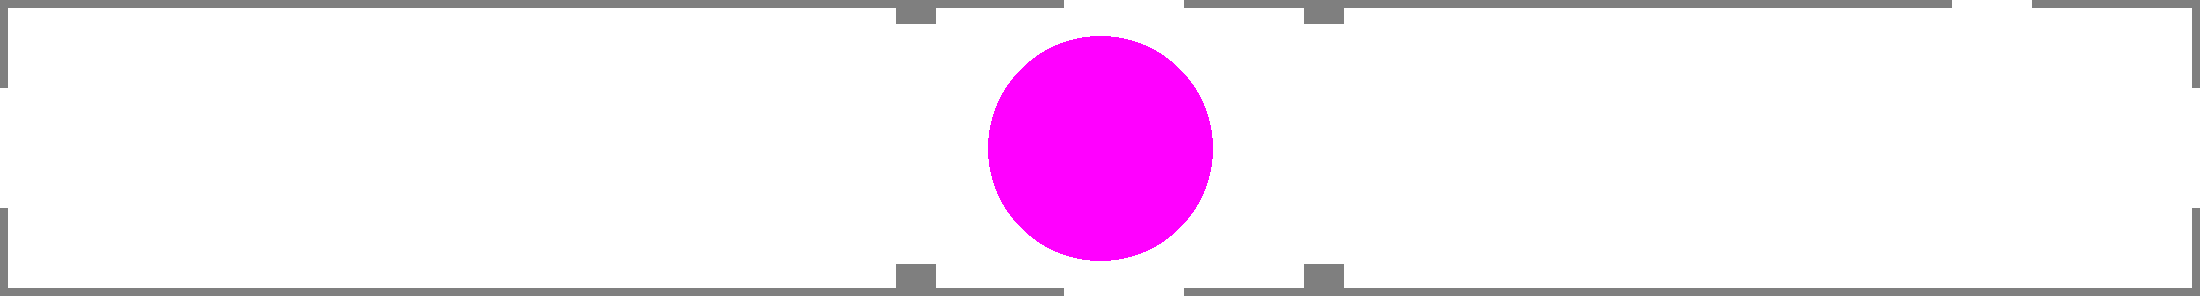

[('room_4_visitor_31.bin', 1),
 ('room_4_visitor_21 2024-01-31 10_56_22.bin', 2),
 ('room_4_visitor_100.bin', 4),
 ('room_4_visitor_22 2024-01-31 10_56_33.bin', 9),
 ('room_4_visitor_24 2024-01-31 10_56_07.bin', 15),
 ('room_4_visitor_20.bin', 22)]

In [28]:
#%%script continue #speed bounding

#FOLDER4 = (getRoomFolder(4),10*SCALE4,ROOM4.size)
display(enlightenFolder(FOLDER4,maxSpeedRemoved,[],sortSpeedRemoved))

#FOLDER4 = (getRoomFolder(4),8*SCALE4,ROOM4.size)
display(displaySpeedBox(ROOM4,FOLDER4[1]))
display(enlightenFolder(FOLDER4,maxSpeedRemoved,[],sortSpeedRemoved))

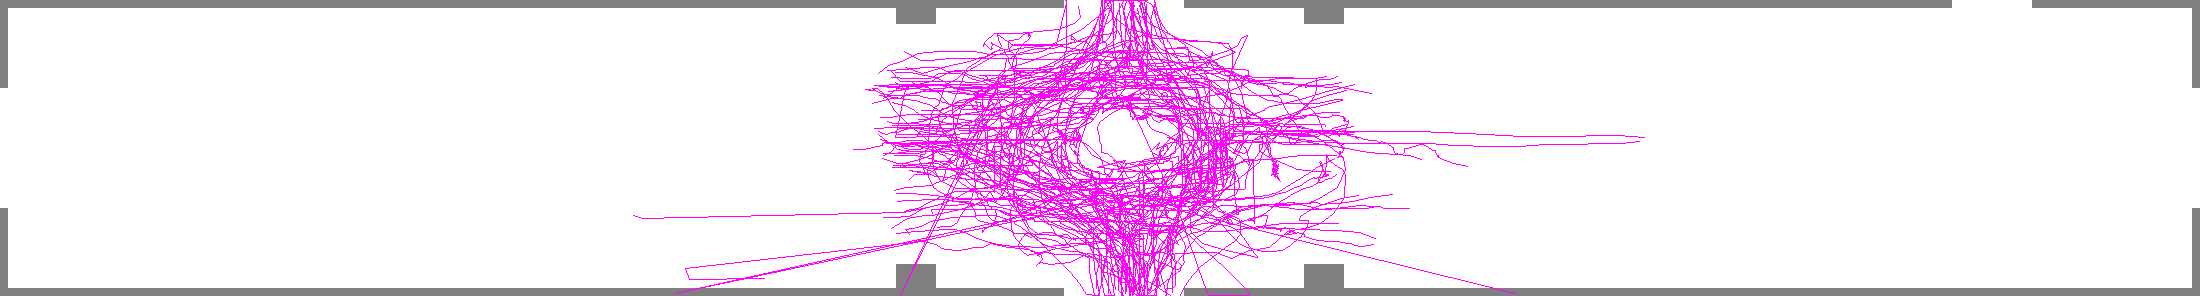

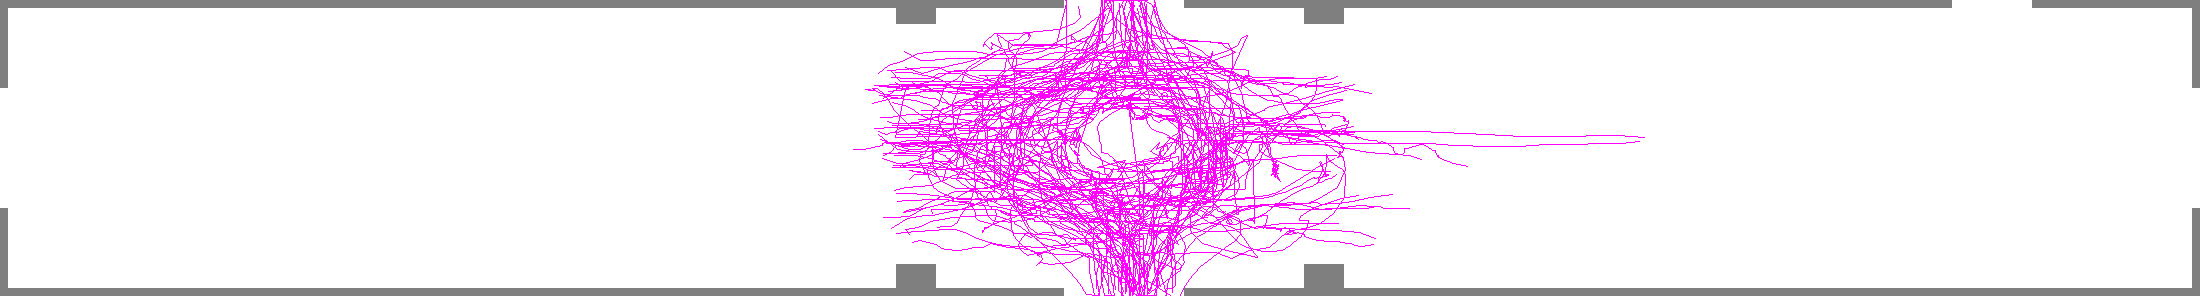

In [29]:
#simple draw run
#FOLDER4 = (getRoomFolder(4),*SCALE4,ROOM4.size)
display(enlightenFolder(FOLDER4,drawPath,drawPathStart(ROOM4),lambda x:x[0],False))
display(enlightenFolder(FOLDER4,drawPath,drawPathStart(ROOM4),lambda x:x[0],True))

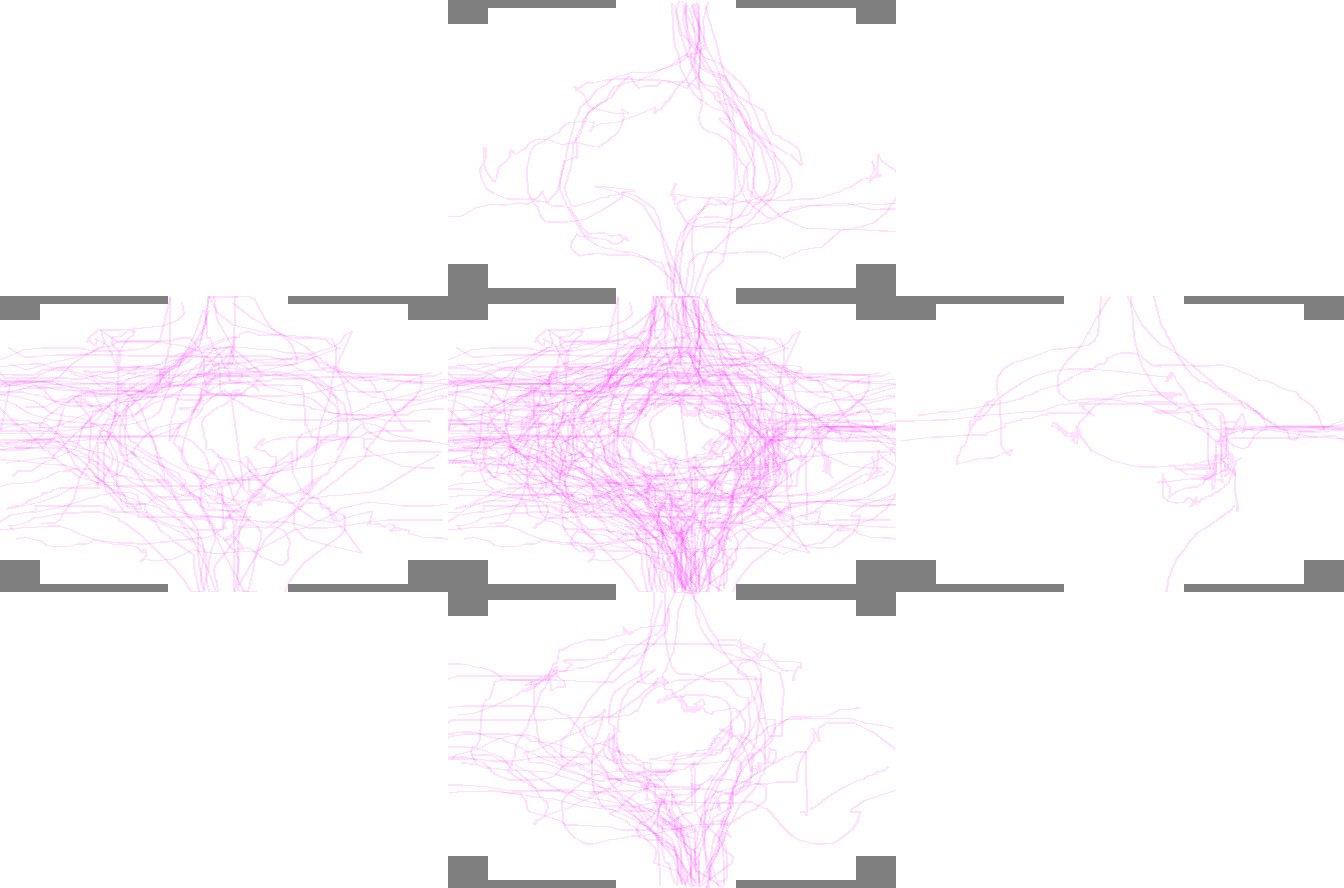

In [30]:
#Opacity drawing run
data = enlightenFolder(FOLDER4,opacityDrawer,opacityDrawerStart(ROOM4),lambda x:cropRoom4(x[0],SCALE4))
fig = makeFigure((3,3),data)
saveImage(data,4,'opacity_drawing/total')
for j,box in enumerate(SELECT_BOXES4):
        x,y = getDirOffset(j)
        data = enlightenFolder(FOLDER4,selectEntrance(opacityDrawer,box),opacityDrawerStart(ROOM4),lambda x:cropRoom4(x[0],SCALE4))
        addToFigure(fig,data,(1+x,1-y))
        saveImage(data,4,f'opacity_drawing/{ENTRANCES[j]}')

saveImage(fig[0],4,'opacity_drawing/mult')
display(fig[0])

fig = None
for j,box in enumerate(SELECT_BOXES4):
        x,y = getDirOffset(j)
        data = cropRoom4(displayBox(ROOM4,box),SCALE4)
        saveImage(data,4,f'mask/{ENTRANCES[j]}')
        if fig is None:
            fig = makeFigure((3,3),data,(1+x,1-y))
        else:
            addToFigure(fig,data,(1+x,1-y))
    
saveImage(fig[0],4,'mask/mult')

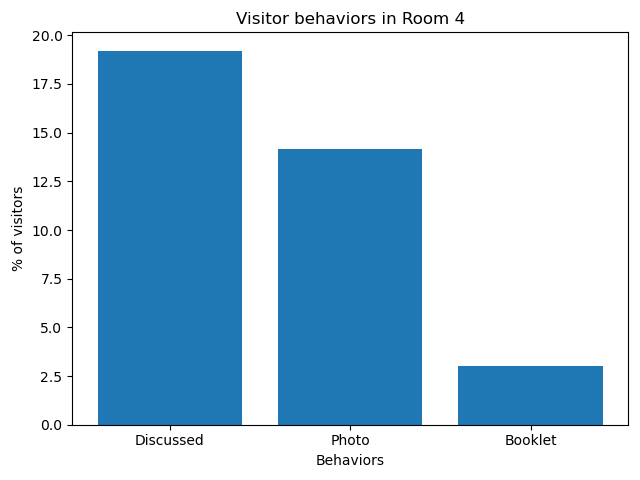

In [31]:
#count behaviors run
#enlightenFolder(FOLDER4,countBehaviors,({},0),printBehaviors)
data = enlightenFolder(FOLDER4,countBehaviors,({},0),graphBehaviors(4))
saveImage(data[0],4,'behaviors')
display(data[0])

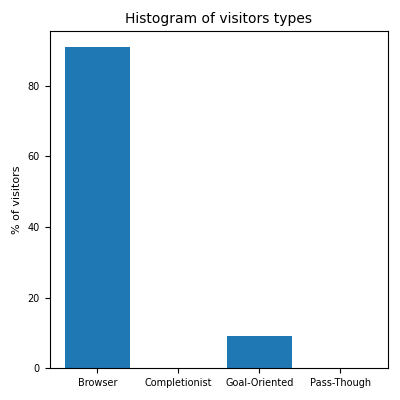

In [32]:
#user type run
data= enlightenFolder(FOLDER4,countUserTypes,([0,0,0,0],0),graphUserTypes(''))
saveImage(data[0],4,'visitor_types')
display(data[0])

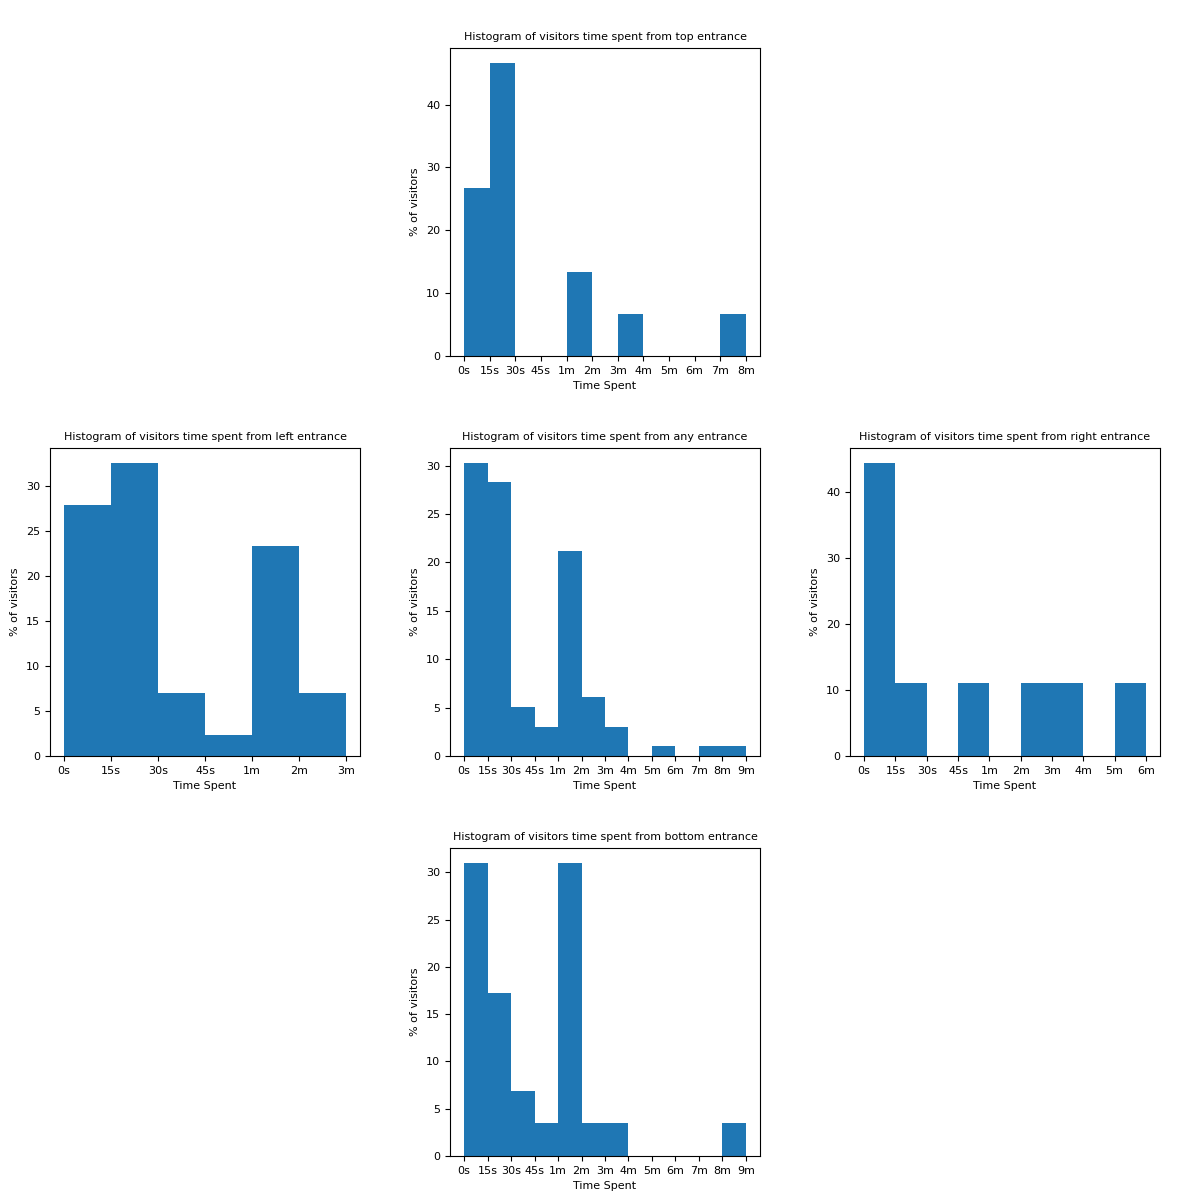

In [33]:
data=enlightenFolder(FOLDER4,countTimeSpentLess1,({},0),histTimesLess1('any'))
fig = makeFigure((3,3),data[0])
saveImage(data[0],4,'time_spent/total')

for j,box in enumerate(SELECT_BOXES4):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER4,selectEntrance(countTimeSpentLess1,box),({},0),histTimesLess1(ENTRANCES[j]))
    addToFigure(fig,data[0],(1+x,1-y))
    saveImage(data[0],4,f'time_spent/{ENTRANCES[j]}')
    
display(fig[0])
saveImage(fig[0],4,'time_spent/mult')

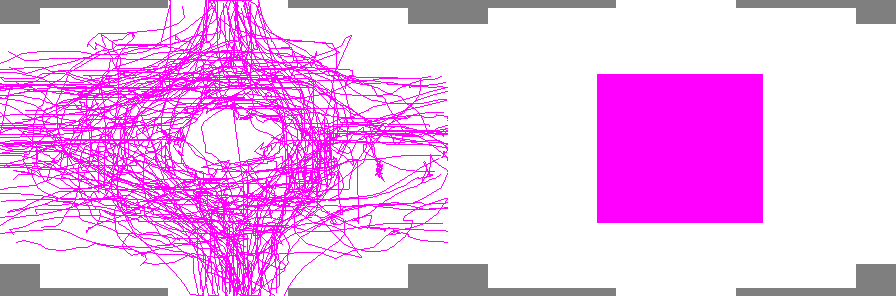

In [34]:
#rosetta box check
data = enlightenFolder(FOLDER4,drawPath,drawPathStart(ROOM4),lambda x:cropRoom4(x[0],SCALE4))
fig = makeFigure((2,1),data)
data = cropRoom4(displayBox(ROOM4,ROSETTA_BOX),SCALE4)
saveImage(data,4,'rosetta_box')
addToFigure(fig,data,(1,0))
display(fig[0])
saveImage(fig[0],4,'rosetta_box_comp')

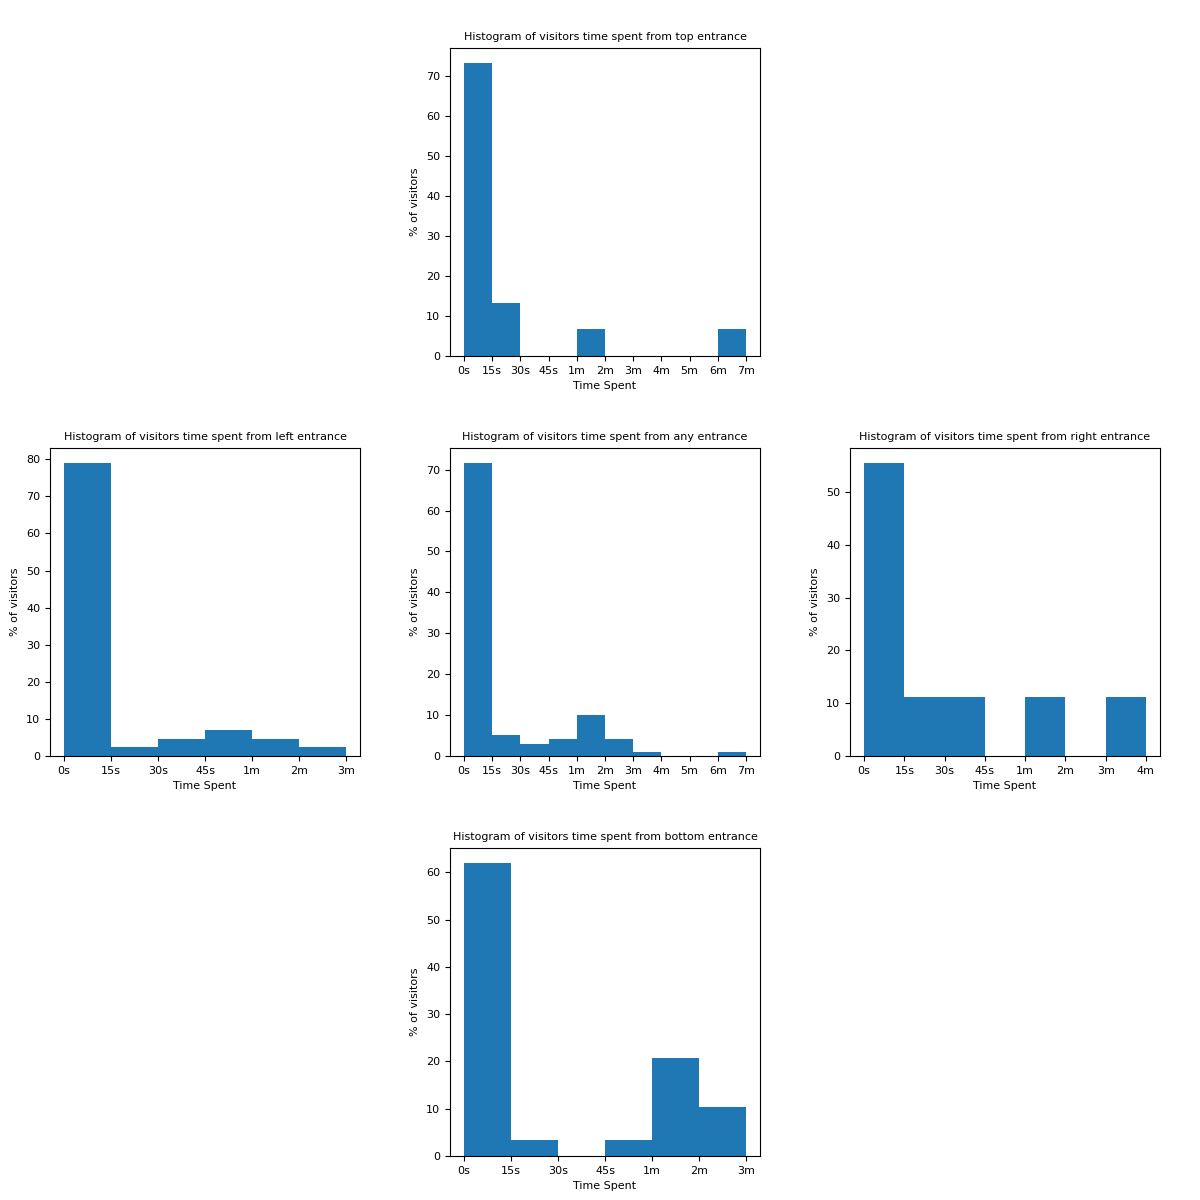

In [35]:
#rosetta box time run

data = enlightenFolder(FOLDER4,countRosettaTimeSpentLess1,({},0),histTimesLess1('any'))
fig = makeFigure((3,3),data[0])
saveImage(data[0],4,'rosetta_time/total')
for j,box in enumerate(SELECT_BOXES4):
        x,y = getDirOffset(j)
        data = enlightenFolder(FOLDER4,selectEntrance(countRosettaTimeSpentLess1,box),({},0),histTimesLess1(ENTRANCES[j]))
        addToFigure(fig,data[0],(1+x,1-y))
        saveImage(data[0],4,f'rosetta_time/{ENTRANCES[j]}')

saveImage(fig[0],4,'rosetta_time/mult')
display(fig[0])

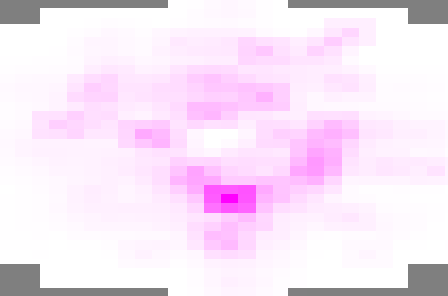

In [36]:
#histodraw
#selectEntrance(countTimeSpentLess1,box),
data = enlightenFolder(FOLDER4,countBoxPixels2,countBoxPixelsStart((128,32)),lambda x:cropRoom4(countBoxPixelsOverlayEnd(ROOM4)(x),SCALE4))
display(data)
saveImage(data,4,'heat_map')

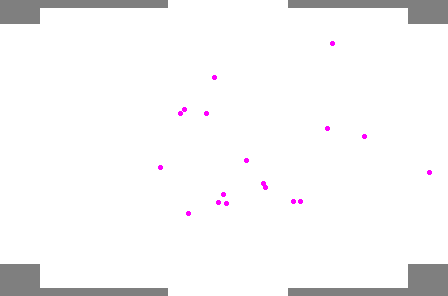

In [37]:
data = enlightenFolder(FOLDER4,drawPhotos,(ROOM4.copy(),0),lambda x:cropRoom4(x,SCALE4))
saveImage(data[0],4,'photos')
display(data[0])

In [38]:
#gif drawing run
ROOM4GIF = enlightenFolder(FOLDER4,drawGif,([],ROOM4),getGifStream(lambda x:cropRoom4(x,SCALE4)))
saveGif(ROOM4GIF[0],4,'gif')

In [112]:
#gif drawing run 2
ROOM4GIF2 = enlightenFolder(FOLDER4,drawGifActions,([],ROOM4),getGifStream(lambda x:cropRoom4(x,SCALE4)))
saveGif(ROOM4GIF2[0],4,'gif2')

In [113]:
displayGif(ROOM4GIF2[0])

Image(value=b'GIF89a\xc0\x01(\x01\x81\x00\x00\xff\xff\xff\x7f\x7f\x7f\xff\x00\xff\x00\x00\x00!\xff\x0bNETSCAPE…

# Room 2

[('room_2_visitor_32.bin', 4),
 ('room_2_visitor_21.bin', 7),
 ('room_2_visitor_67.bin', 21)]

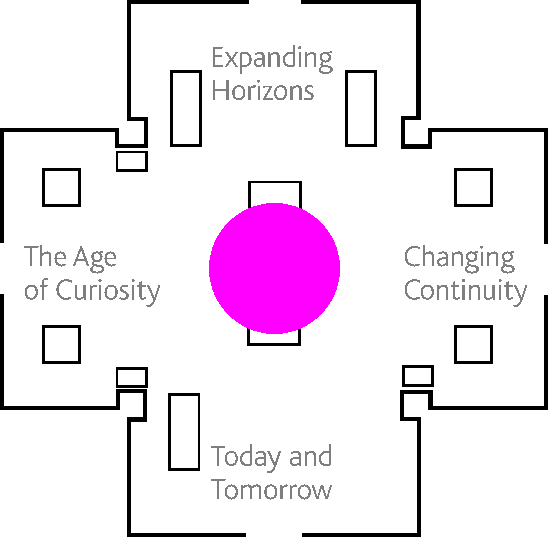

In [40]:
#speed bounding

display(enlightenFolder(FOLDER2,maxSpeedRemoved,[],sortSpeedRemoved))

#FOLDER2 = (getRoomFolder(2),14*SCALE2,ROOM2.size)
display(displaySpeedBox(ROOM2,FOLDER2[1]))
#display(enlightenFolder(FOLDER2,maxSpeedRemoved,[],sortSpeedRemoved))

In [41]:
#simple draw run
grid = ipy.GridspecLayout(1, 2,layout=LAYOUT)
out = grid[0,0]=ipy.Output()
with out:
    display(enlightenFolder(FOLDER2,drawPath,drawPathStart(ROOM2),lambda x:x[0],False))
out = grid[0,1]=ipy.Output()
with out:
    display(enlightenFolder(FOLDER2,drawPath,drawPathStart(ROOM2),lambda x:x[0],True))
grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

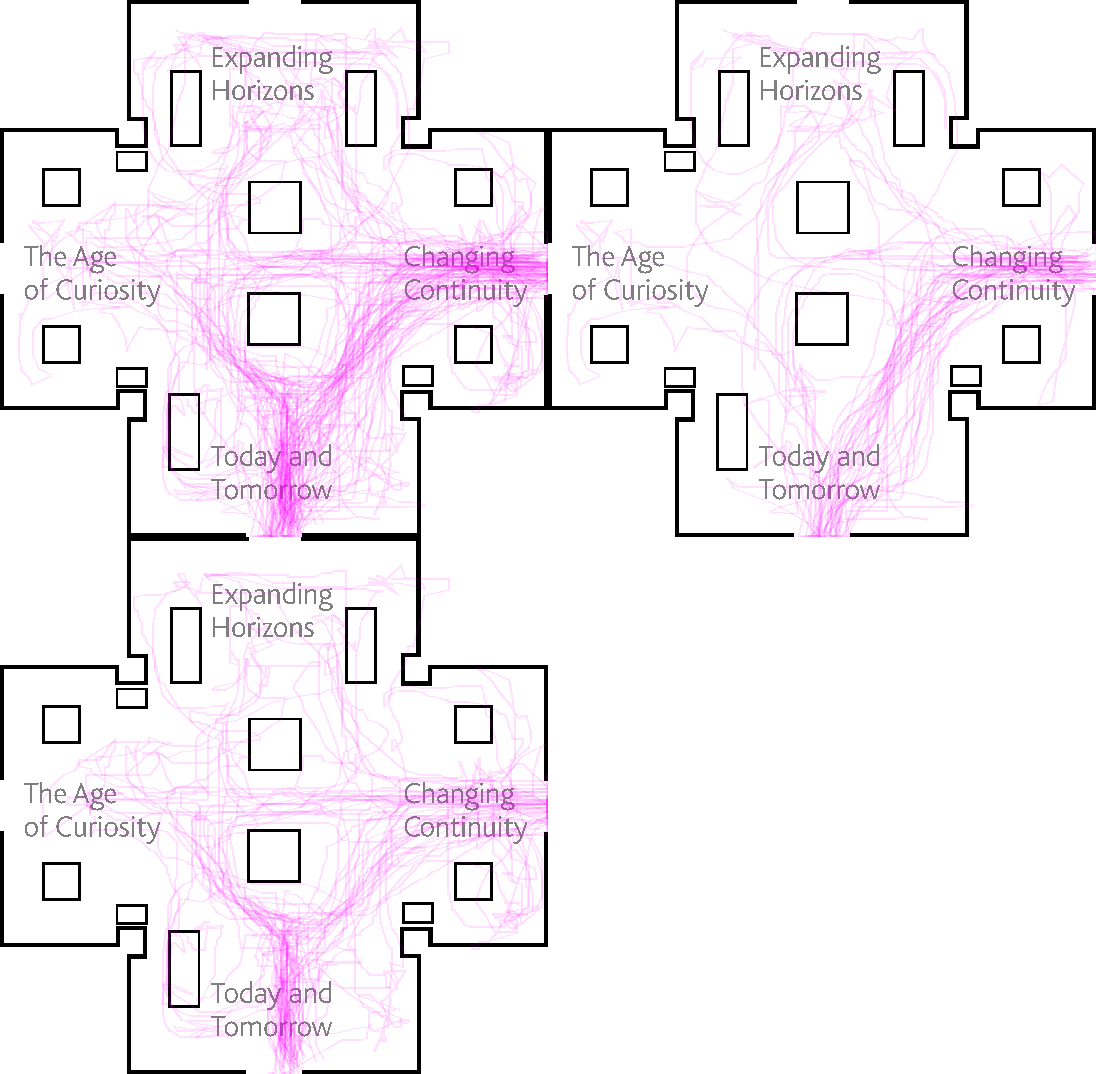

In [42]:
#Opacity drawing run

data = enlightenFolder(FOLDER2,opacityDrawer,opacityDrawerStart(ROOM2))
fig = makeFigure((2,2),data[0])
saveImage(data[0],2,'opacity_drawing/total')
for j,box in enumerate(SELECT_BOXES2):
        x,y = getDirOffset(j+2)
        data = enlightenFolder(FOLDER2,selectEntrance(opacityDrawer,box),opacityDrawerStart(ROOM2))
        saveImage(data[0],2,f'opacity_drawing/{ENTRANCES[j+2]}')
        addToFigure(fig,data[0],(x,-y))

saveImage(fig[0],2,'opacity_drawing/mult')
display(fig[0])


fig = None

for j,box in enumerate(SELECT_BOXES2):
        x,y = getDirOffset(j+2)
        # x2,y2 = getDirOffset(j-1)
        data = displayBox(ROOM2,box)
        saveImage(data,2,f'mask/{ENTRANCES[j+2]}')
        if fig is None:
            fig = makeFigure((2,2),data,(x,-y))
        else:
            addToFigure(fig,data,(x,-y))
            
saveImage(fig[0],2,'mask/mult')

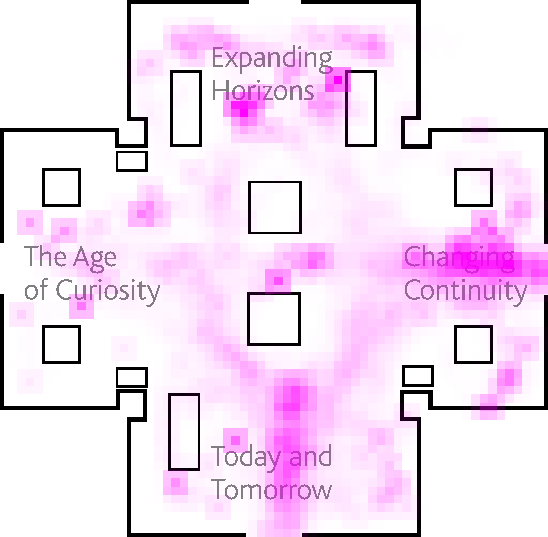

In [43]:
#histodraw
data = enlightenFolder(FOLDER2,countBoxPixels2,countBoxPixelsStart((64,64)),countBoxPixelsOverlayEnd(ROOM2))
saveImage(data,2,'heat_map')
display(data)

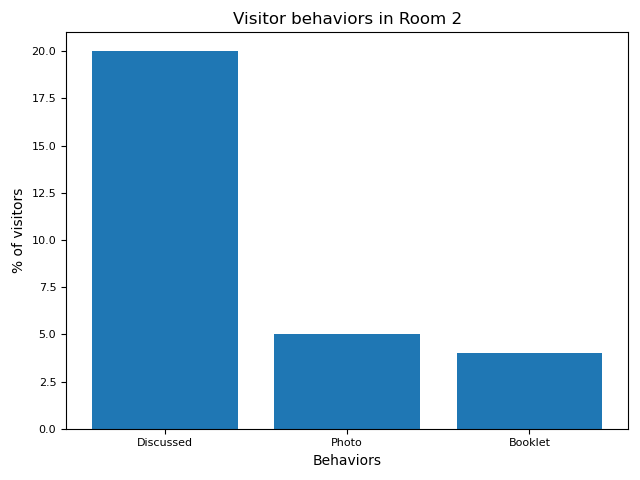

In [44]:
#count behaviors run
data = enlightenFolder(FOLDER2,countBehaviors,({},0),graphBehaviors(2))
saveImage(data[0],2,'behaviors')
display(data[0])

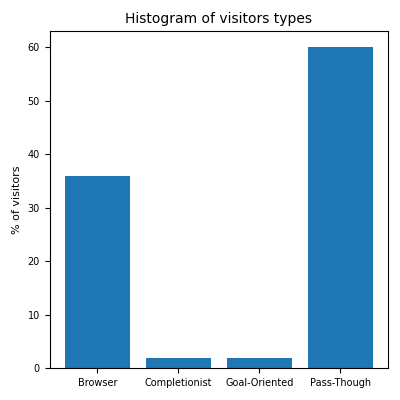

In [45]:
#user type run
data= enlightenFolder(FOLDER2,countUserTypes,([0,0,0,0],0),graphUserTypes(''))
saveImage(data[0],2,'visitor_types')
display(data[0])

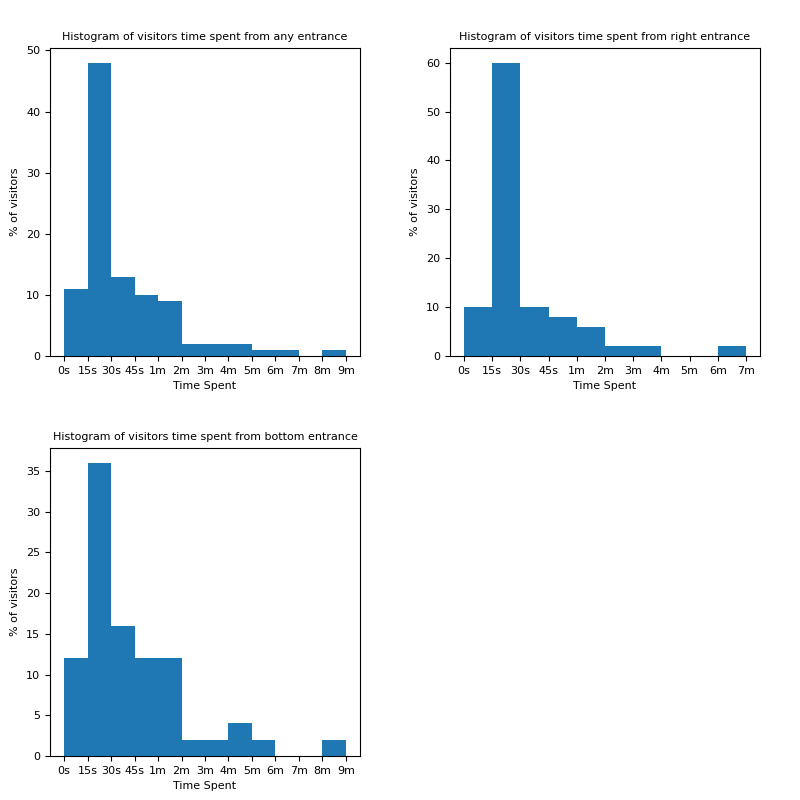

In [46]:
#count time run
data=enlightenFolder(FOLDER2,countTimeSpentLess1,({},0),histTimesLess1('any'))
saveImage(data[0],2,'time_spent/total')
fig = makeFigure((2,2),data[0])
for j,box in enumerate(SELECT_BOXES2):
    x,y = getDirOffset(j+2)
    data=enlightenFolder(FOLDER2,selectEntrance(countTimeSpentLess1,box),({},0),histTimesLess1(ENTRANCES[j+2]))
    saveImage(data[0],2,f'time_spent/{ENTRANCES[j+2]}')
    addToFigure(fig,data[0],(x,-y))
    
saveImage(fig[0],2,f'time_spent/mult')
display(fig[0])

right {'Up': 133, 'Down': 174}
bottom {'Down': 297, 'Up': 193}


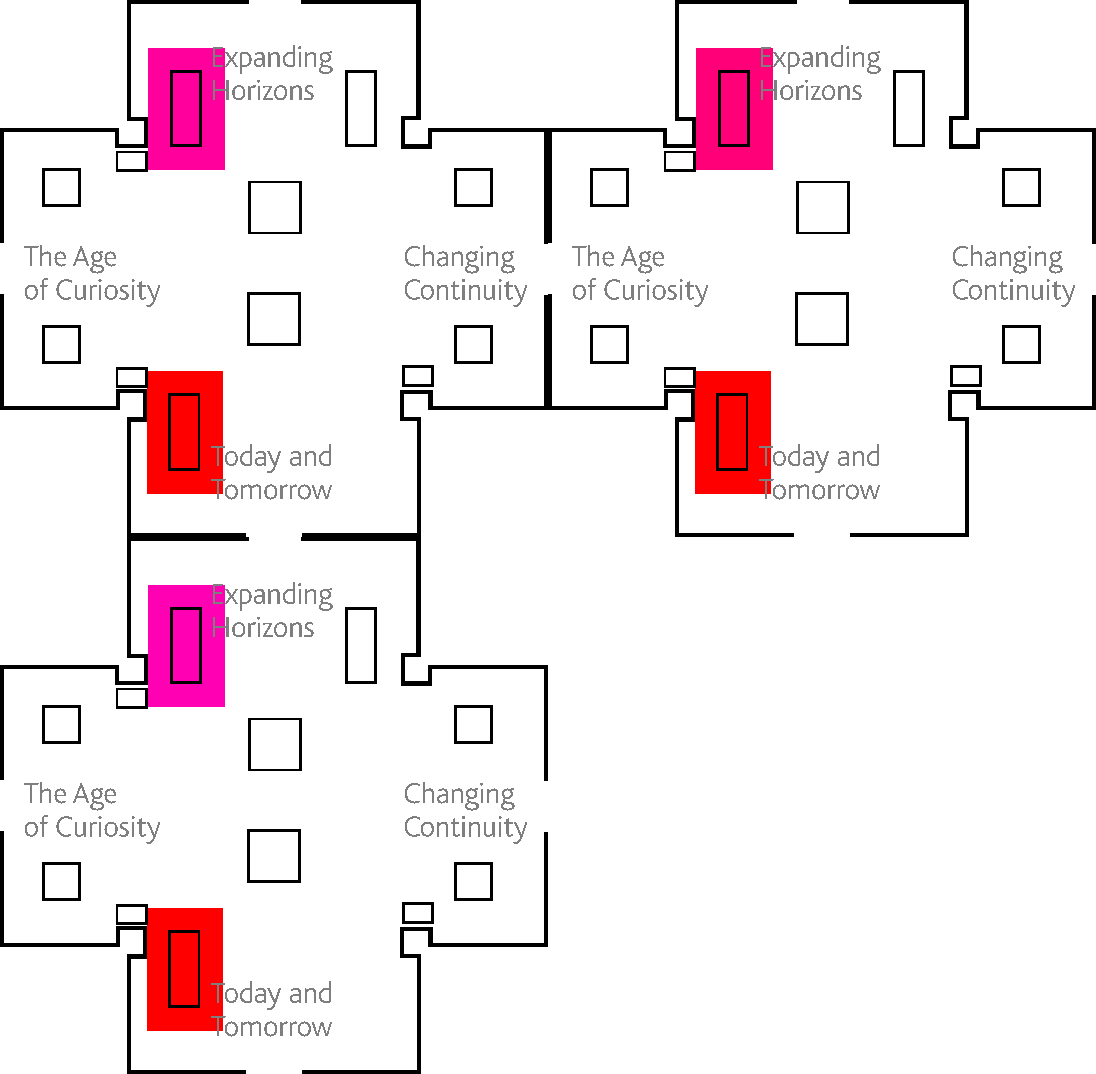

In [47]:
#get display time
data=enlightenFolder(FOLDER2,countDisplayTime,({},DISPLAY_BOXES2,ROOM2,ROOM2MASK),displayEndMask(getPurpleColor))
fig = makeFigure((2,2),data[0])
saveImage(data[0],2,'display_time/color/total')

for j,box in enumerate(SELECT_BOXES2):
    x,y = getDirOffset(j+2)
    data=enlightenFolder(FOLDER2,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES2,ROOM2,ROOM2MASK),displayEndMask(getPurpleColor))
    saveImage(data[0],2,f'display_time/color/{ENTRANCES[j+2]}')
    addToFigure(fig,data[0],(x,-y))
    print(ENTRANCES[(j+2)%4],data[1])

display(fig[0])
saveImage(fig[0],2,'display_time/color/mult')

In [48]:
# #get display time graph
# for name,box2 in DISPLAY_BOXES2.items():
#     name = name.lower()
#     data=enlightenFolder(FOLDER2,countDisplayHist,({},0,box2,ROOM2),histTimesLess1("any"))
#     fig = makeFigure((2,2),data[0])
#     saveImage(data[0],2,f'display_time_spent_{name}_total')
    
#     for j,box in enumerate(SELECT_BOXES2):
#         x,y = getDirOffset(j+2)
#         data=enlightenFolder(FOLDER2,selectEntrance(countDisplayHist,box),({},0,box2,ROOM2),histTimesLess1(ENTRANCES[(j+2)%4]))
#         saveImage(data[0],2,f'display_time_spent_{name}_{ENTRANCES[j+2]}')
#         addToFigure(fig,data[0],(x,-y))
#         print(ENTRANCES[(j+2)%4],data[1])
    
#     display(fig[0])
#     saveImage(fig[0],2,f'display_time_spent_{name}_mult')

In [49]:
# #get display time graph better
# second_grams = [0,5,10,15,20,25,30]
# for name,box2 in DISPLAY_BOXES2.items():
#     name = name.lower()
#     data=enlightenFolder(FOLDER2,countDisplayHistMin,({},0,box2,ROOM2),histTimesLess1("any",second_grams))
#     fig = makeFigure((2,2),data[0])
#     saveImage(data[0],2,f'display_time_spent_min_{name}_total')
    
#     for j,box in enumerate(SELECT_BOXES2):
#         x,y = getDirOffset(j+2)
#         data=enlightenFolder(FOLDER2,selectEntrance(countDisplayHistMin,box),({},0,box2,ROOM2),histTimesLess1(ENTRANCES[(j+2)%4],second_grams))
#         saveImage(data[0],2,f'display_time_spent_min_{name}_{ENTRANCES[j+2]}')
#         addToFigure(fig,data[0],(x,-y))
#         print(ENTRANCES[(j+2)%4],data[1])
    
#     display(fig[0])
#     saveImage(fig[0],2,f'display_time_spent_min_{name}_mult')

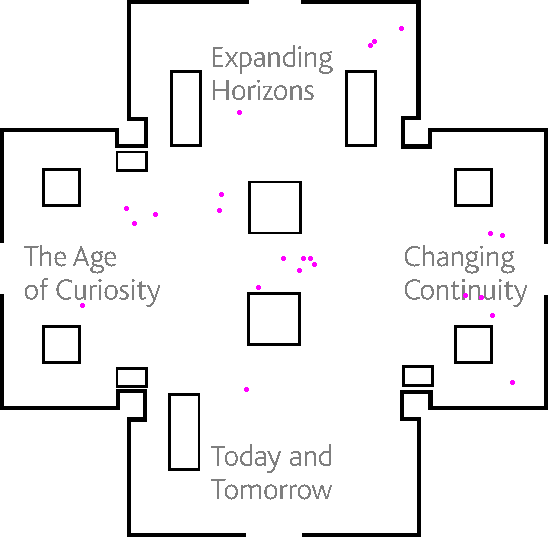

In [50]:
data = enlightenFolder(FOLDER2,drawPhotos,(ROOM2.copy(),0))
saveImage(data[0],2,'photos')
display(data[0])

In [51]:
#gif drawing run
ROOM2GIF = enlightenFolder(FOLDER2,drawGif,([],ROOM2),getGifStream())
saveGif(ROOM2GIF[0],2,'gif')

In [52]:
displayGif(ROOM2GIF[0])

Image(value=b'GIF89a$\x02\x19\x02\x87\x00\x00\xff\xff\xff\x00\x00\x00\x7f\x7f\x7f\xff\x00\xff\x00\x00\x00\x00\…

# Room 1

In [53]:
%%script continue #testing

def checkVaseCollisions(path,arg):
    num = 0
    w,h = arg[1]
    half = (w/2,h/2)
    box = (half[0]-35,half[1]-35,half[0]+35,half[1]+35)
    for point in path['points']:
        x,y,_ = point
        if isInBox((x*w,y*h),box):
            num+=1
    
    if num!=0:
        arg[0].append((path['file'],num))
            
display(enlightenFolder(FOLDER1,checkVaseCollisions,([],ROOM1.size)))

Couldn't find program: 'continue'


In [54]:
%%script continue #speed bounding


display(enlightenFolder(FOLDER1,maxSpeedRemoved,[],sortSpeedRemoved))

FOLDER1 = (getRoomFolder(1),40*SCALE1,ROOM1,fixHeight)
display(displaySpeedBox(ROOM1,FOLDER1[1]))
display(enlightenFolder(FOLDER1,maxSpeedRemoved,[],sortSpeedRemoved))

Couldn't find program: 'continue'


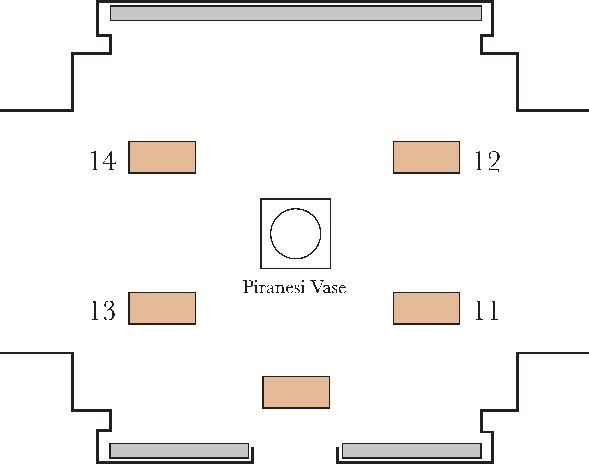

In [55]:
cropRoom1(ROOM1,SCALE1)

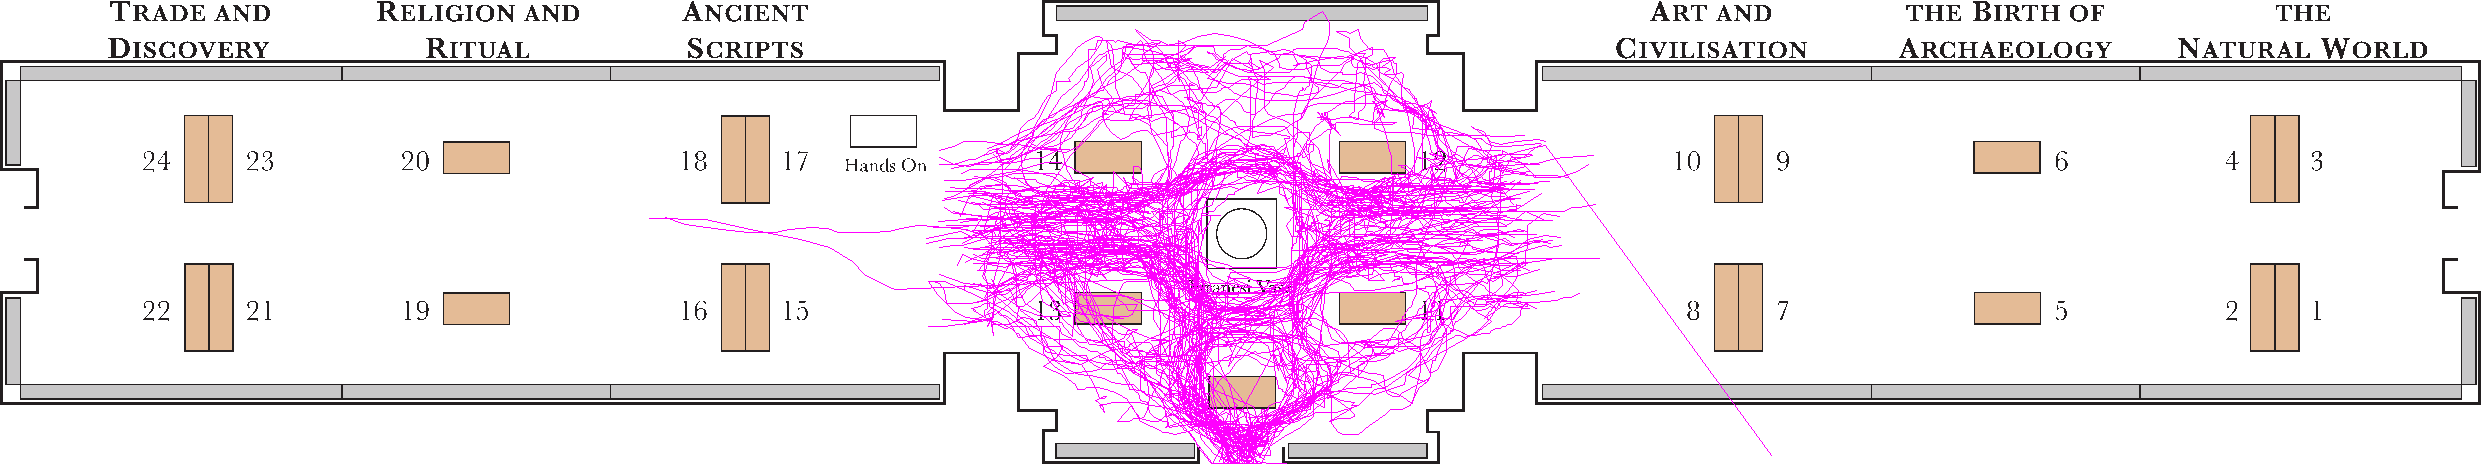

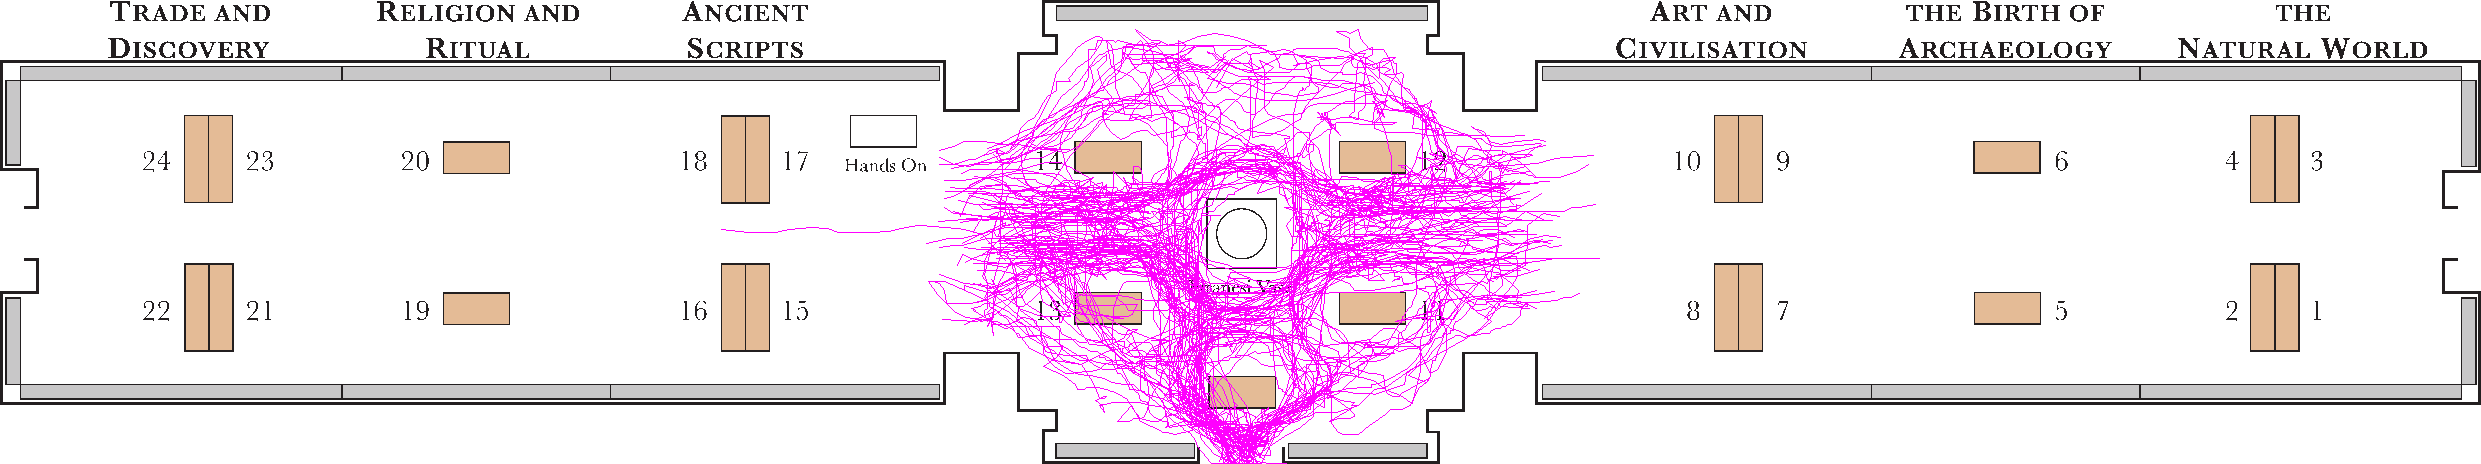

In [56]:
#simple draw run
display(enlightenFolder(FOLDER1,drawPath,drawPathStart(ROOM1),lambda x:x[0],False))
display(enlightenFolder(FOLDER1,drawPath,drawPathStart(ROOM1),lambda x:x[0],True))

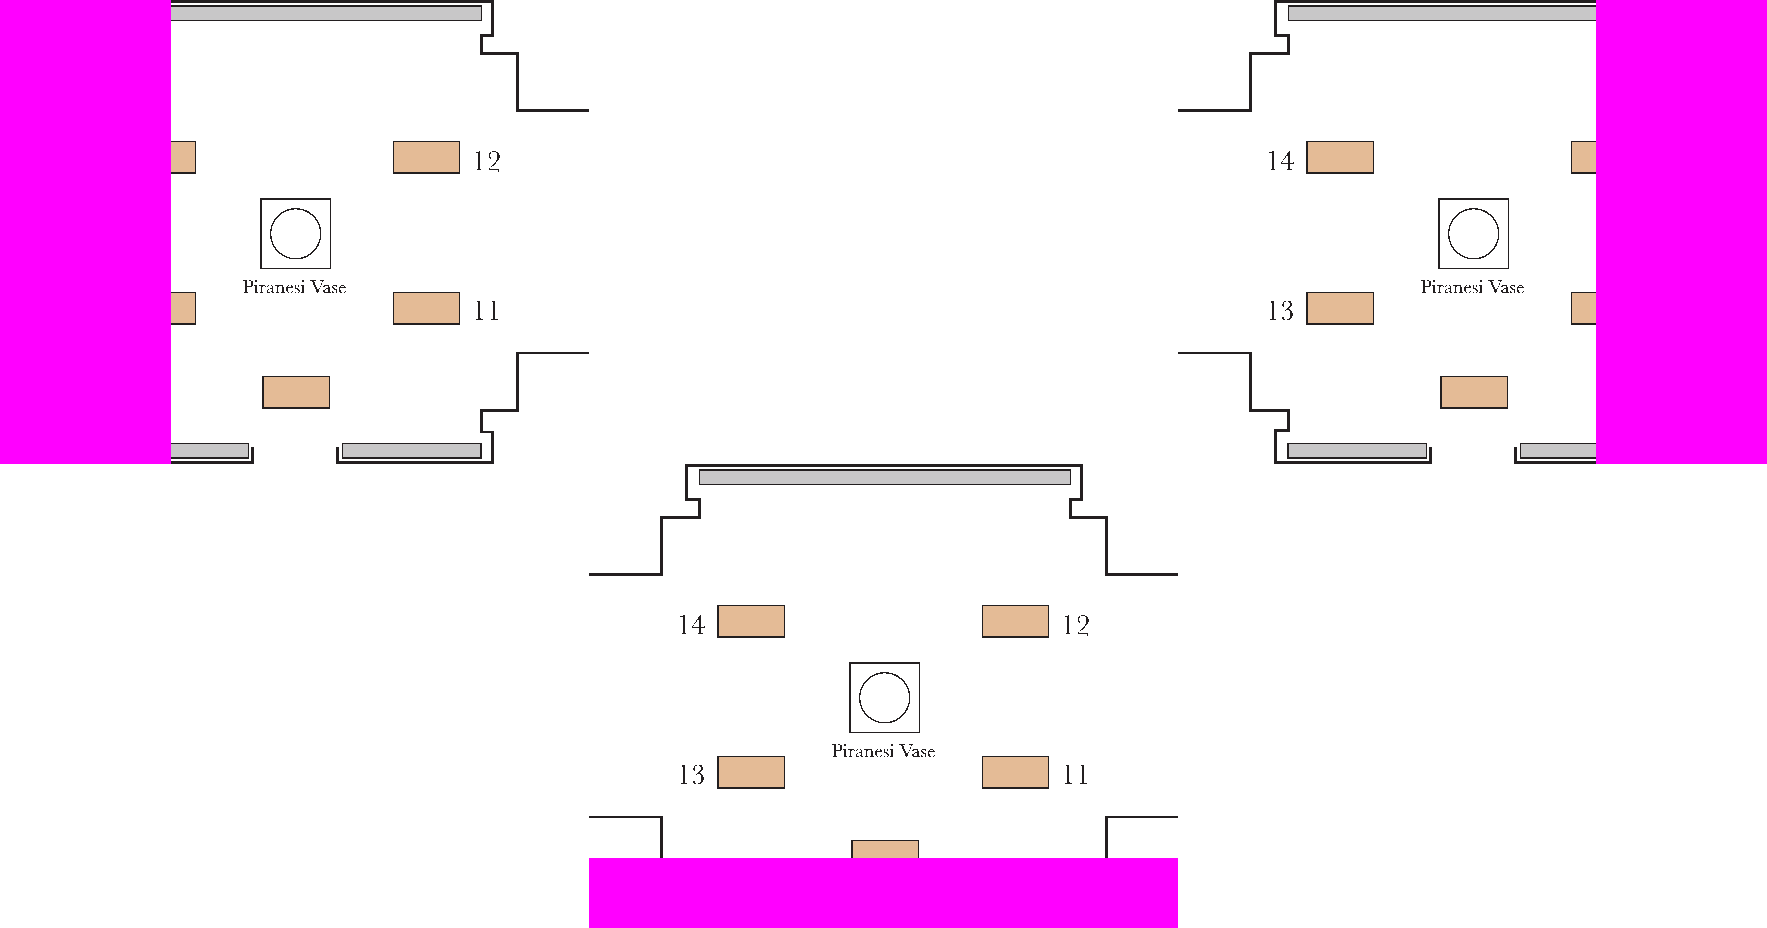

In [57]:
#show entrance boxes
fig = None
for j,box in enumerate(SELECT_BOXES1):
        x,y = getDirOffset(j+2)
        data = cropRoom1(displayBox(ROOM1,box),SCALE1)
        saveImage(data,1,f'mask/{ENTRANCES[(j+2)%4]}')
        if j == 0:
            fig = makeFigure((3,2),data,(1+x,-y))
        else:
            addToFigure(fig,data,(1+x,-y))

saveImage(fig[0],1,'mask/mult')
display(fig[0])

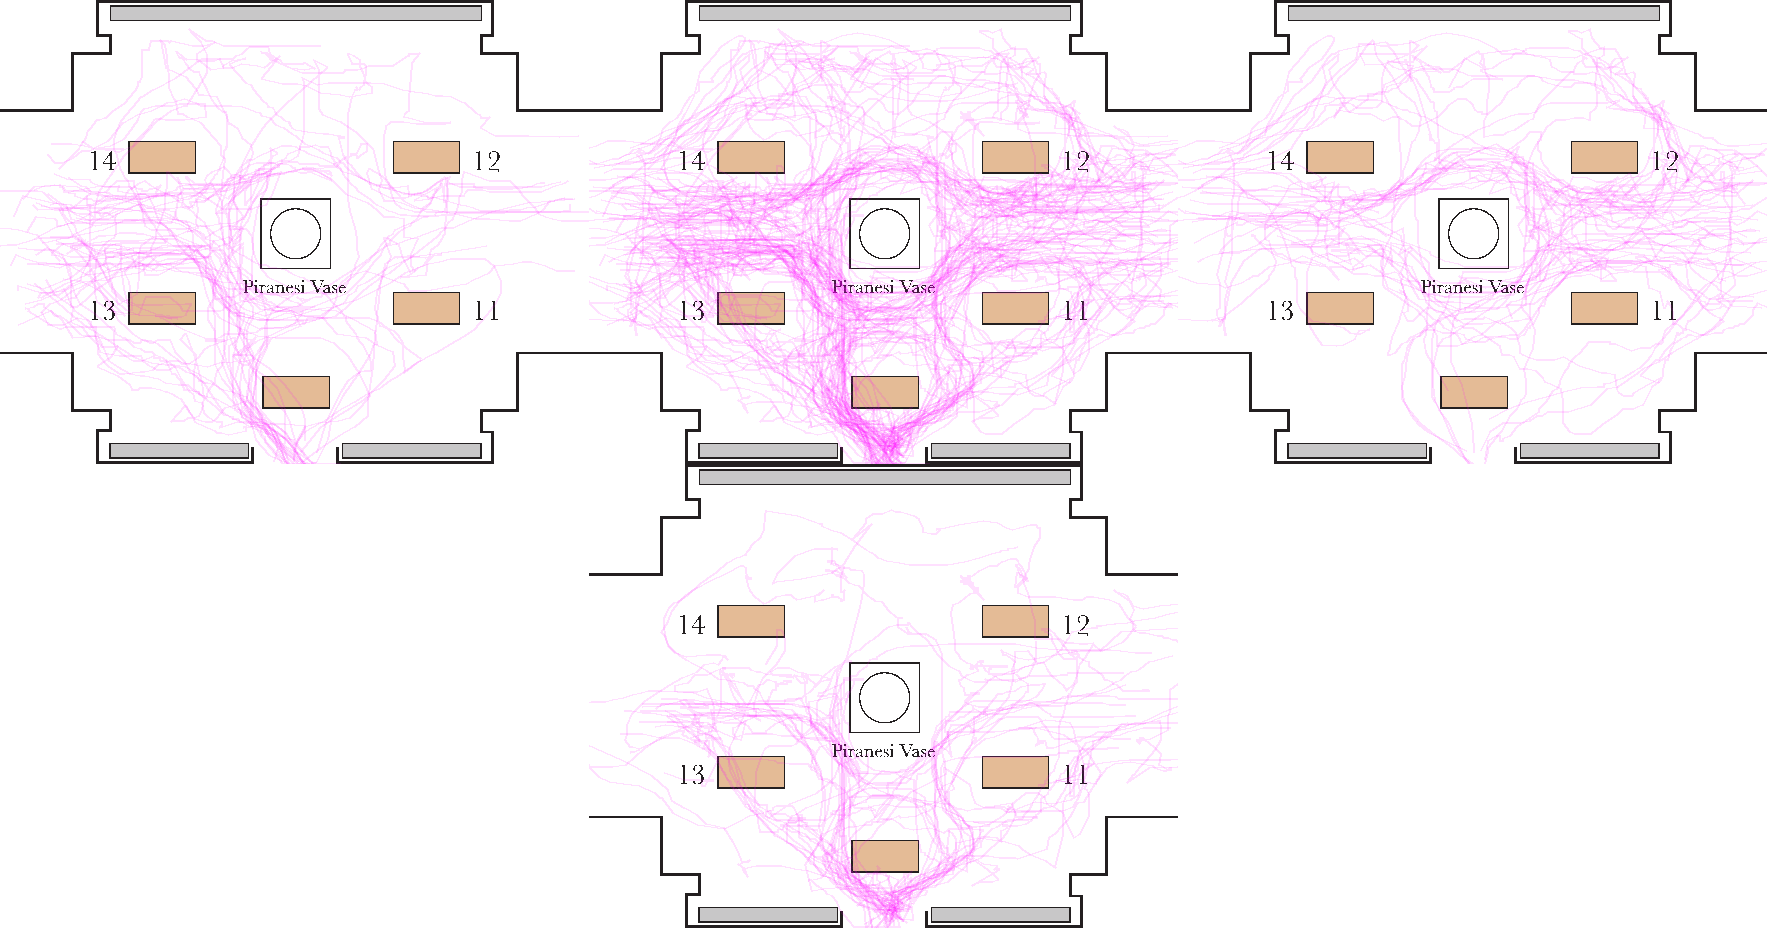

In [58]:
#opacity drawing run

data = enlightenFolder(FOLDER1,opacityDrawer,opacityDrawerStart(ROOM1),lambda x:cropRoom1(x[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,'opacity_drawing/total')
for j,box in enumerate(SELECT_BOXES1):
        x,y = getDirOffset(j+2)
        data = enlightenFolder(FOLDER1,selectEntrance(opacityDrawer,box),opacityDrawerStart(ROOM1),lambda x:cropRoom1(x[0],SCALE1))
        addToFigure(fig,data,(1+x,-y))
        saveImage(data,1,f'opacity_drawing/{ENTRANCES[(j+2)%4]}')

saveImage(fig[0],1,'opacity_drawing/mult')
display(fig[0])

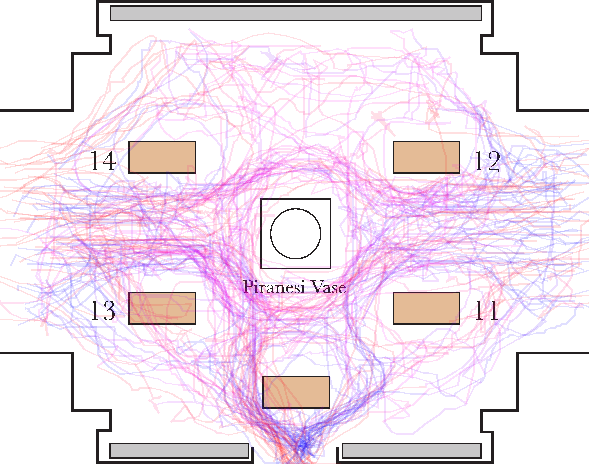

In [59]:
data = enlightenFolder(FOLDER1,opacityDrawerColor,opacityDrawerStart(ROOM1),lambda x:cropRoom1(x[0],SCALE1))
saveImage(data,1,'blood')
display(data)

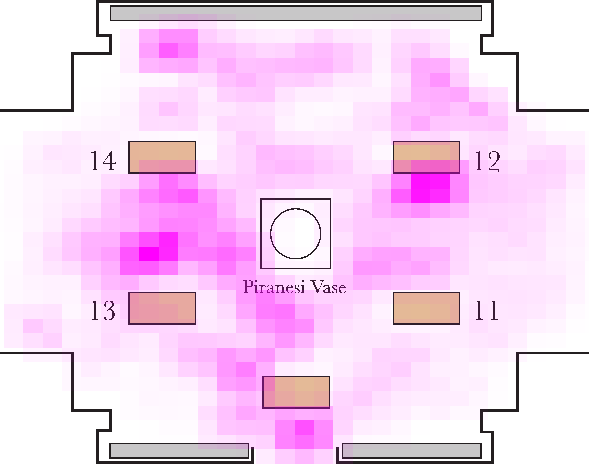

In [60]:
#histodraw
data = enlightenFolder(FOLDER1,countBoxPixels2,countBoxPixelsStart((128,32)),lambda x:cropRoom1(countBoxPixelsOverlayEnd(ROOM1)(x),SCALE1))
saveImage(data,1,'heat_map')
display(data)

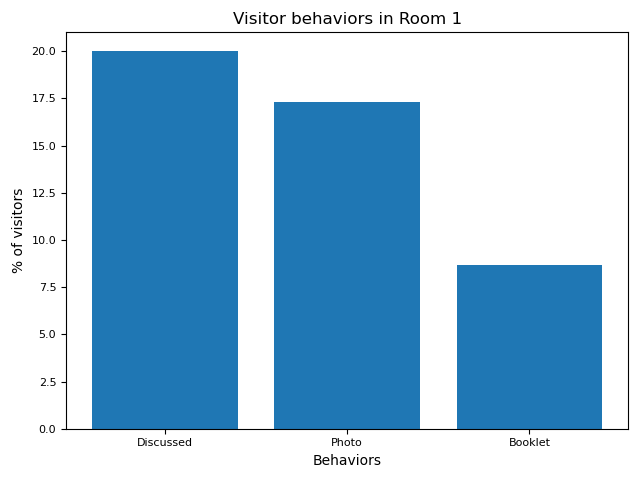

In [61]:
#count behaviors run
data = enlightenFolder(FOLDER1,countBehaviors,({},0),graphBehaviors(1))
saveImage(data[0],1,'behaviors')
display(data[0])

In [62]:
#get average time
enlightenFolder(FOLDER1,getAverage,(0,0),getAverageEnd(' room 1'))

'0:57 average room 1'

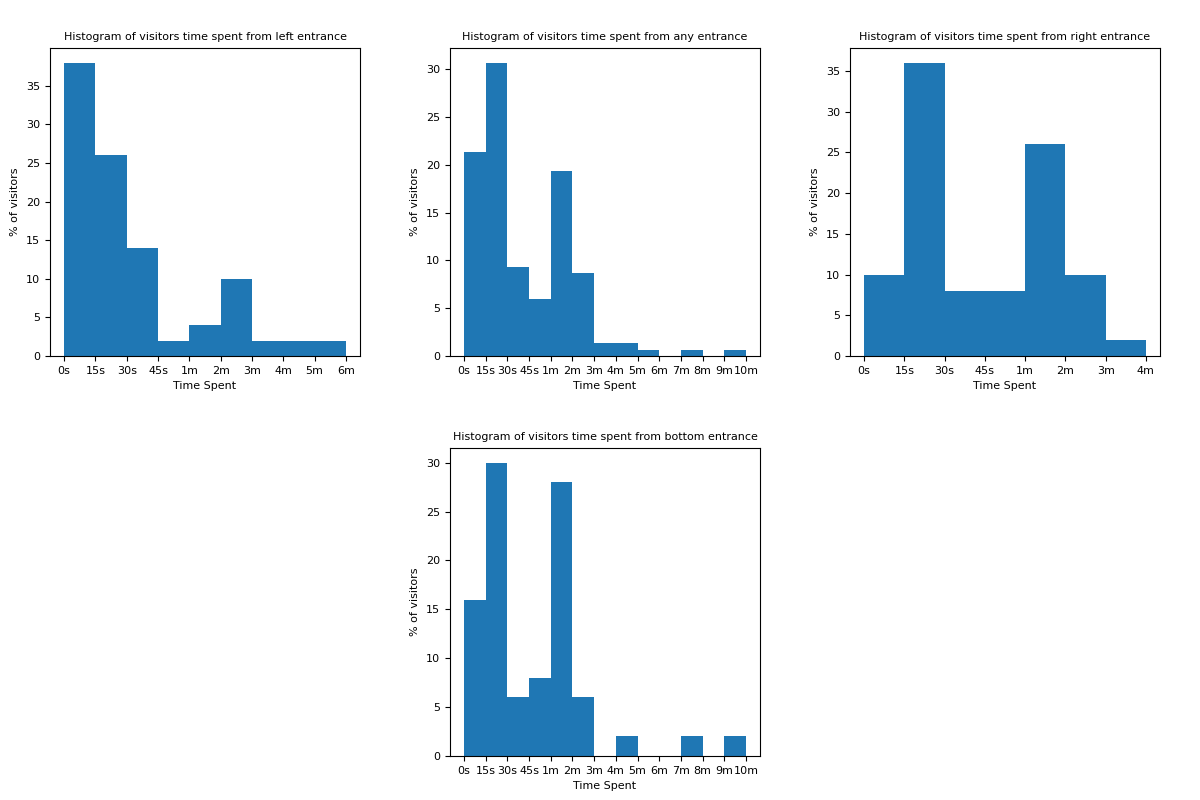

In [63]:
#count time run

data=enlightenFolder(FOLDER1,countTimeSpentLess1,({},0),histTimesLess1('any'))
fig = makeFigure((3,2),data[0])
saveImage(data[0],1,'time_spent/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countTimeSpentLess1,box),({},0),histTimesLess1(ENTRANCES[(j+2)%4]))
    saveImage(data[0],1,f'time_spent/{ENTRANCES[(j+2)%4]}')
    addToFigure(fig,data[0],(1-x,y))

saveImage(fig[0],1,'time_spent/mult')
display(fig[0])

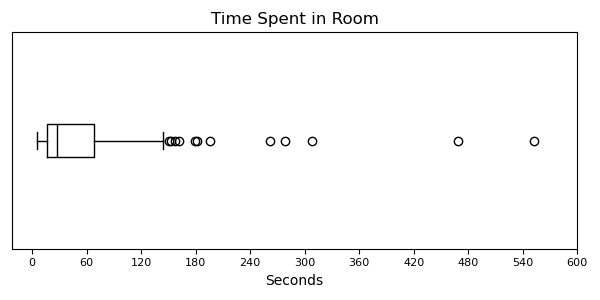

In [64]:
data=enlightenFolder(FOLDER1,boxWhisker,([],),boxWhiskerEnd)
saveImage(data[0],1,'whisker_time')
display(data[0])

In [65]:
#get display time graph better
for name,box2 in DISPLAY_BOXES1.items():
    name = name.lower()
    data=enlightenFolder(FOLDER1,countDisplayHistMin,({},0,box2,ROOM1),histTimesLess1("any"))
    fig = makeFigure((3,2),data[0])
    saveImage(data[0],1,f'display_time/graph/{name}/total')
    
    for j,box in enumerate(SELECT_BOXES1):
        x,y = getDirOffset(j)
        data=enlightenFolder(FOLDER1,selectEntrance(countDisplayHistMin,box),({},0,box2,ROOM1),histTimesLess1(ENTRANCES[(j+2)%4]))
        saveImage(data[0],1,f'display_time/graph/{name}/{ENTRANCES[(j+2)%4]}')
        addToFigure(fig,data[0],(1-x,y))
        print(ENTRANCES[(j+2)%4],data[1])
    
    #display(fig[0])
    saveImage(fig[0],1,f'display_time/graph/{name}/mult')

right [12, 2, 2, 0]
bottom [13, 4, 1, 0]
left [6, 1, 0, 0]
right [17, 2, 6, 0]
bottom [3, 1, 0, 0, 2, 1]
left [6, 1, 1, 1, 1]
right [6, 3, 0, 0]
bottom [10, 3, 2, 1, 1]
left [26, 3, 2, 0]
right [21, 1, 0, 0, 1]
bottom [3, 1, 0, 0, 1]
left [16, 2, 2, 1]
right [28, 5, 0, 0]
bottom [16, 1, 1, 0, 1, 1]
left [17, 2, 3, 0]
right [12, 0, 0, 0]
bottom [40, 2, 3, 0, 3]
left [26, 0, 0, 1, 1]


right {'12': 1415, '11': 660, 'Va': 905, '13': 301, 'In': 104, '14': 825}
bottom {'In': 2269, '11': 755, 'Va': 1315, '13': 1172, '14': 453, '12': 1509}
left {'13': 919, 'Va': 895, '11': 124, 'In': 923, '14': 987, '12': 778}


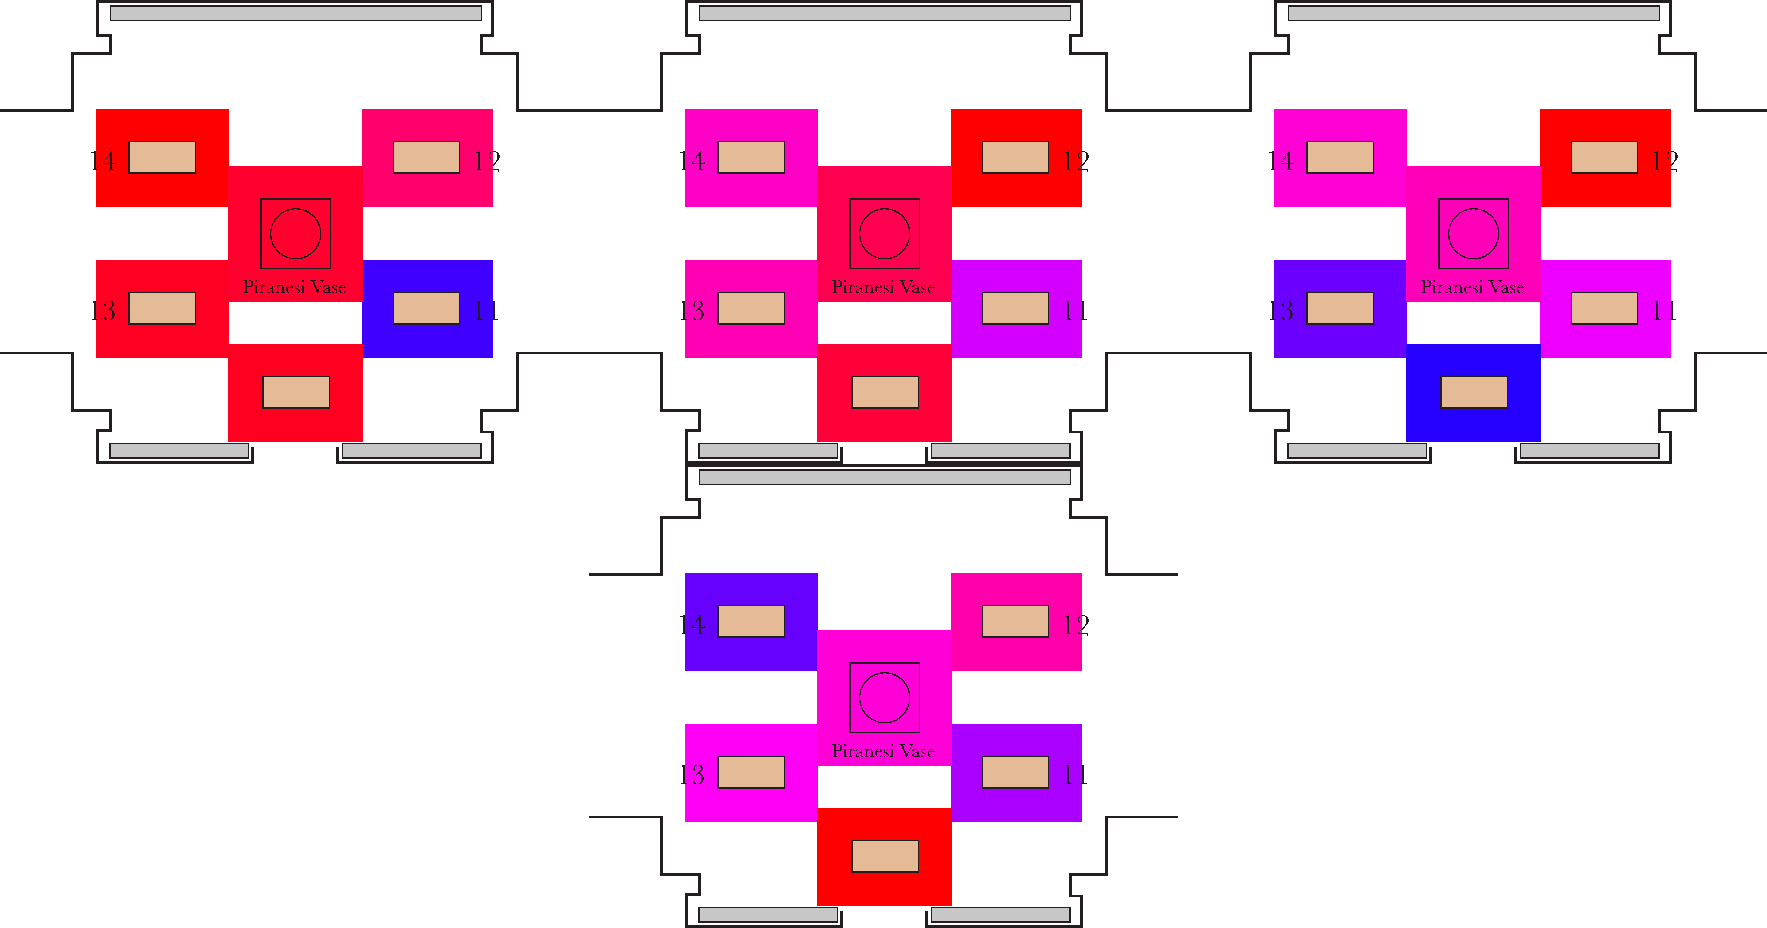

In [66]:
#get display time

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x)[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,'display_time/image/all/color/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x),SCALE1))
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'display_time/image/all/color/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

display(fig[0])
saveImage(fig[0],1,'display_time/image/all/color/mult')

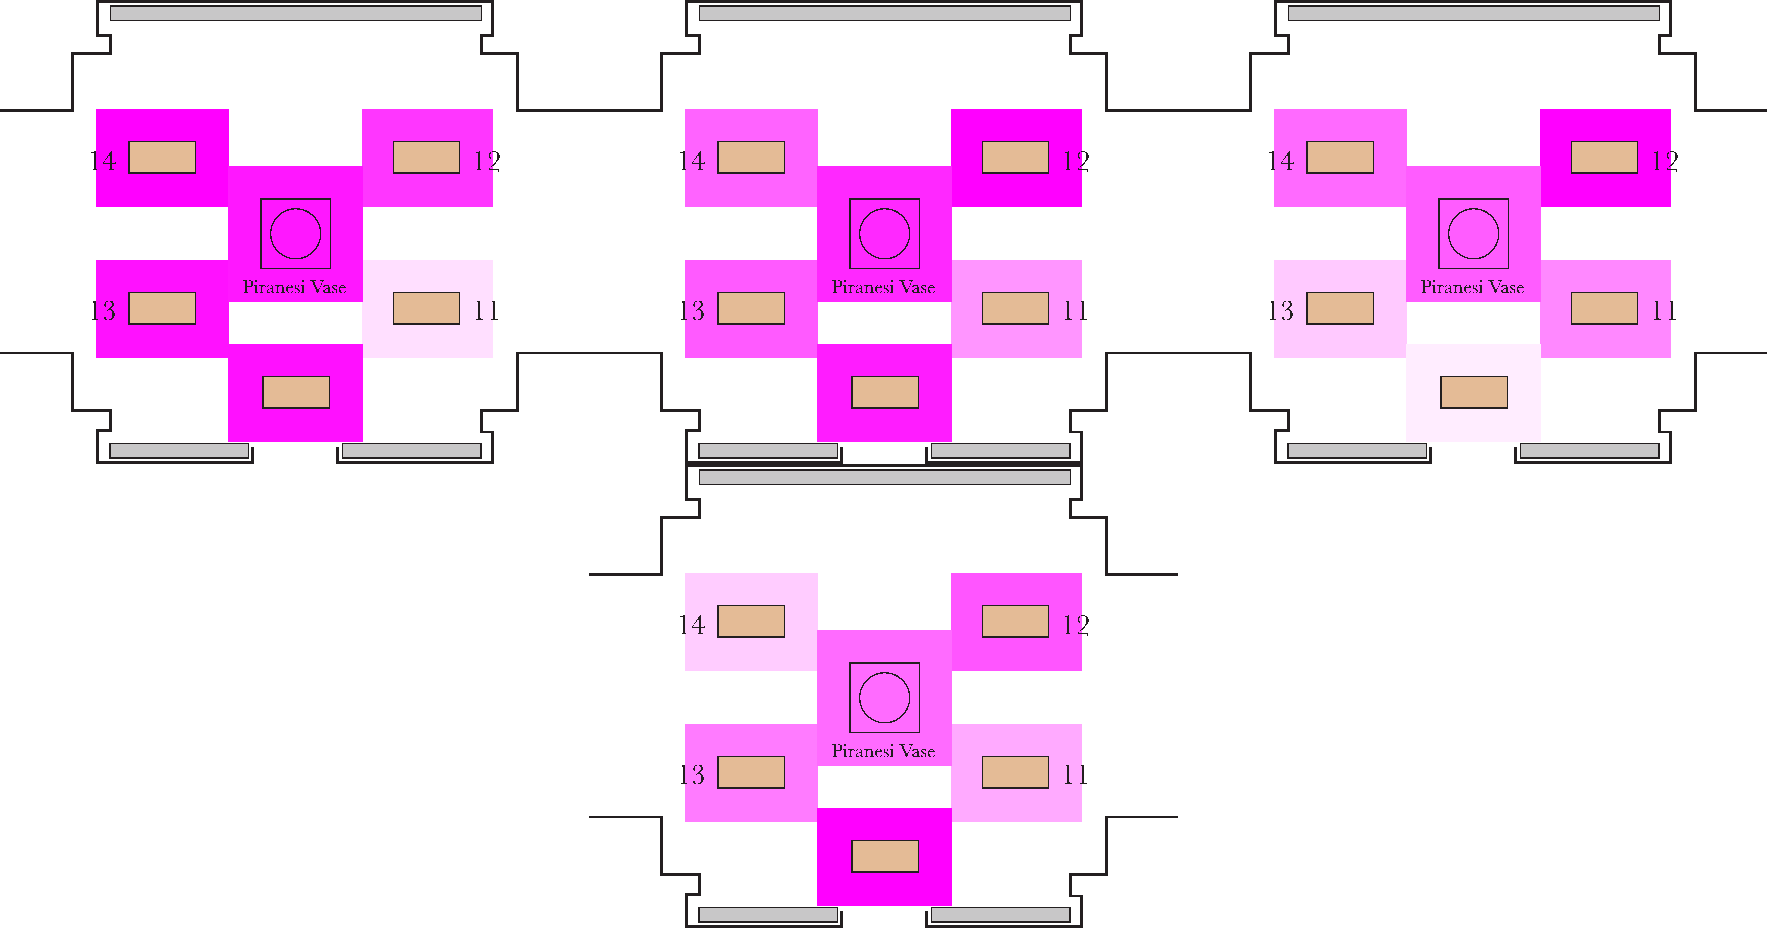

In [67]:
#get display time purple

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,'display_time/image/all/purple/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
    addToFigure(fig,data,(1-x,y))
    saveImage(data,1,f'display_time/image/all/purple/{ENTRANCES[(j+2)%4]}')

display(fig[0])
saveImage(fig[0],1,'display_time/image/all/purple/mult')

right {'12': 1415, '11': 660, '13': 301, '14': 825}
bottom {'11': 755, '13': 1172, '14': 453, '12': 1509}
left {'13': 919, '11': 124, '14': 987, '12': 778}


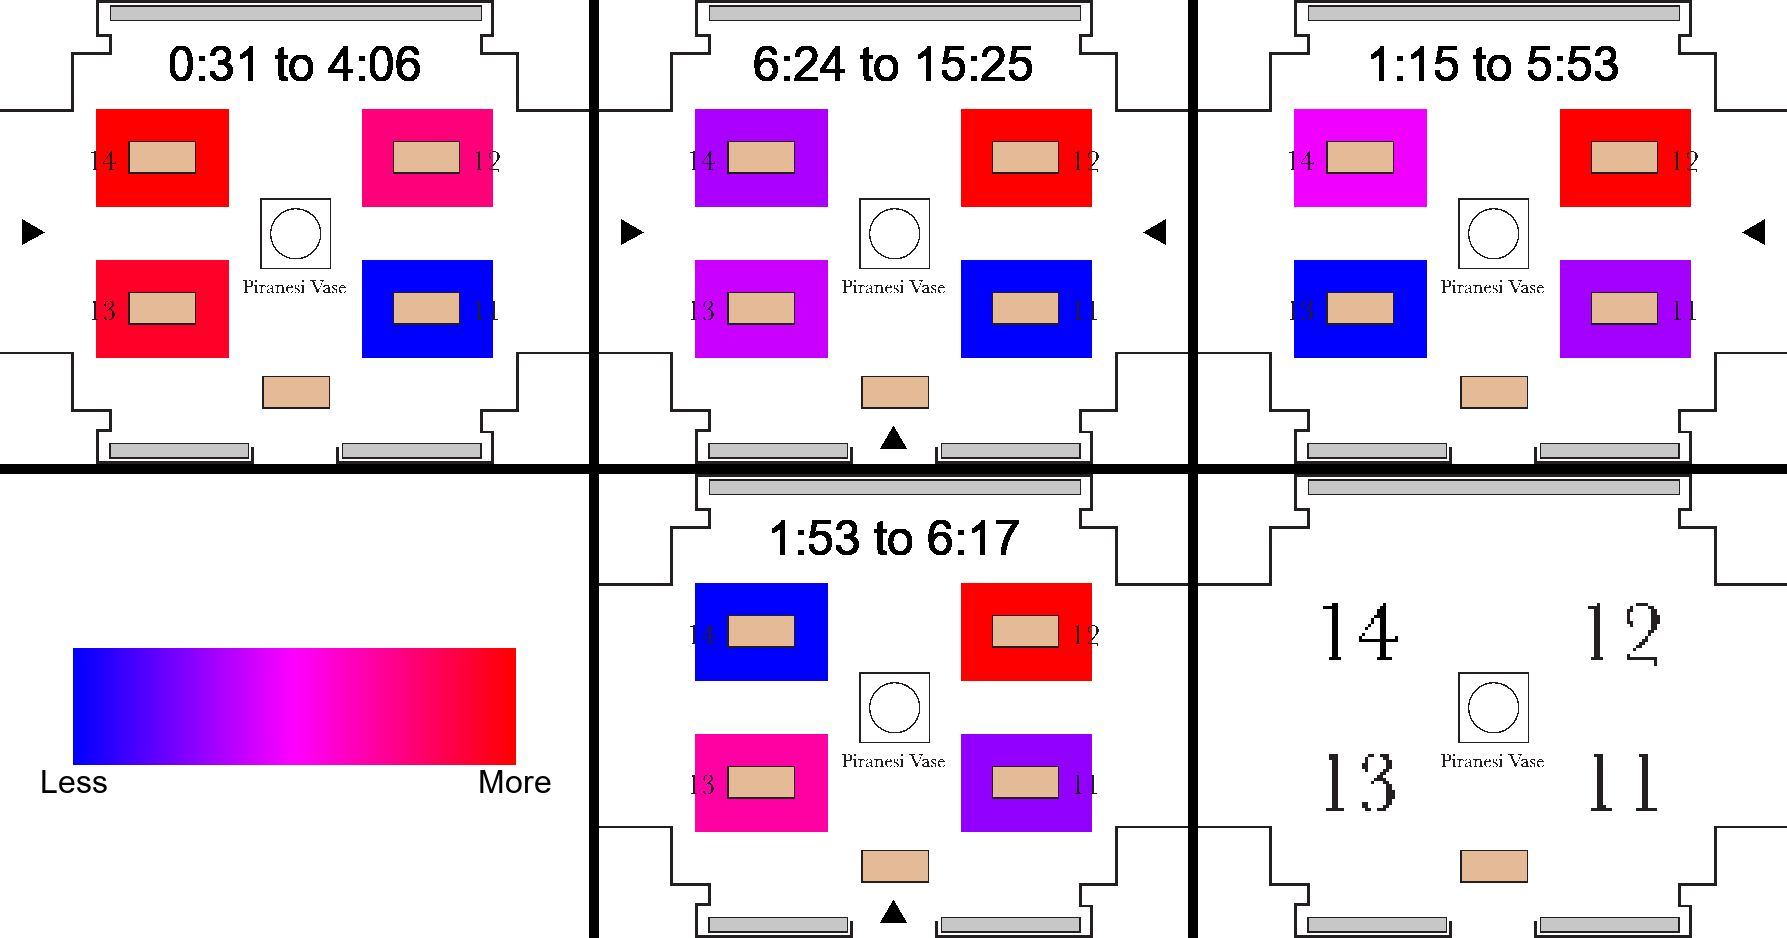

In [68]:
#get display time cases

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x),SCALE1))

for j in range(3):
    drawTriangle(data[0], ROOM1_TRIANGLES[j])

drawAverageRoom1(data)

fig = makeFigure((3,2),data[0],(1,0),gap=10,back=(0,0,0))
saveImage(data[0],1,'display_time/image/cases/color/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x),SCALE1))
    
    drawTriangle(data[0],ROOM1_TRIANGLES[j])

    drawAverageRoom1(data)
    
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'display_time/image/cases/color/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

#display(fig[0])
saveImage(fig[0],1,'display_time/image/cases/color/mult')
data = lessMoreScale(cropRoom1(ROOM1,SCALE1),getPurpleColor)
saveImage(data,1,f'display_time/image/cases/color/label')
addToFigure(fig,data,(0,1))
saveImage(fig[0],1,f'display_time/image/cases/color/mult_label')
data = cropRoom1(ROOM1LEGEND,SCALE1)
saveImage(data,1,f'display_time/image/cases/color/legend')
addToFigure(fig,data,(2,1))
saveImage(fig[0],1,f'display_time/image/cases/color/mult_legend')
display(fig[0])

right {'12': 1415, '11': 660, '13': 301, '14': 825}
bottom {'11': 755, '13': 1172, '14': 453, '12': 1509}
left {'13': 919, '11': 124, '14': 987, '12': 778}


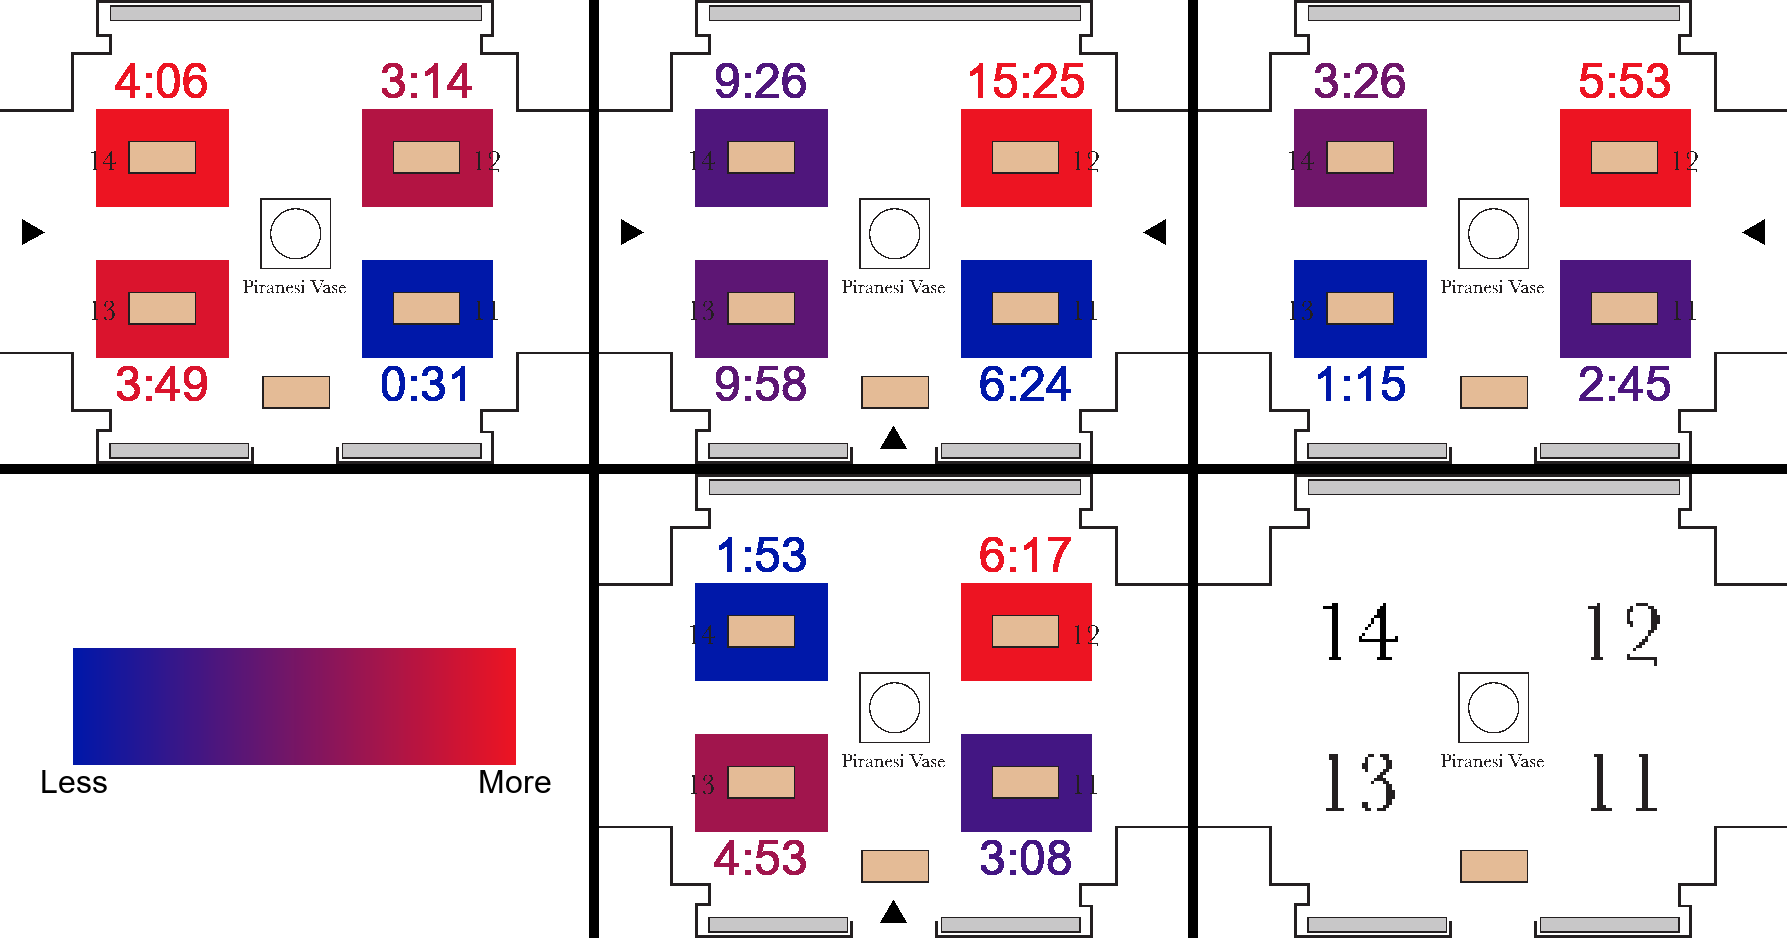

In [139]:
#get display time cases dark

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),displayEndMask2(getDarkPurpleColor))

for j in DISPLAY_BOXES1_CASES:
    drawNextToBox(data[0],DISPLAY_BOXES1_CASES[j],getTimeFromSeconds(data[1][j]/4),color = data[4][j])

data = cropRoom1(data,SCALE1)

for j in range(3):
    drawTriangle(data[0], ROOM1_TRIANGLES[j])

#drawAverageRoom1(data)

fig = makeFigure((3,2),data[0],(1,0),gap=10,back=(0,0,0))
saveImage(data[0],1,'display_time/image/cases/dark/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),displayEndMask2(getDarkPurpleColor))

    for i in DISPLAY_BOXES1_CASES:
        drawNextToBox(data[0],DISPLAY_BOXES1_CASES[i],getTimeFromSeconds(data[1][i]/4),color = data[4][i])

    data = cropRoom1(data,SCALE1)
    
    drawTriangle(data[0],ROOM1_TRIANGLES[j])

    #drawAverageRoom1(data)
    
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'display_time/image/cases/dark/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

#display(fig[0])
saveImage(fig[0],1,'display_time/image/cases/dark/mult')
data = lessMoreScale(cropRoom1(ROOM1,SCALE1),getDarkPurpleColor)
saveImage(data,1,'display_time/image/cases/dark/label')
addToFigure(fig,data,(0,1))
saveImage(fig[0],1,'display_time/image/cases/dark/mult_label')
data = cropRoom1(ROOM1LEGEND,SCALE1)
saveImage(data,1,'display_time/image/cases/dark/legend')
addToFigure(fig,data,(2,1))
saveImage(fig[0],1,'display_time/image/cases/dark/mult_legend')
display(fig[0])

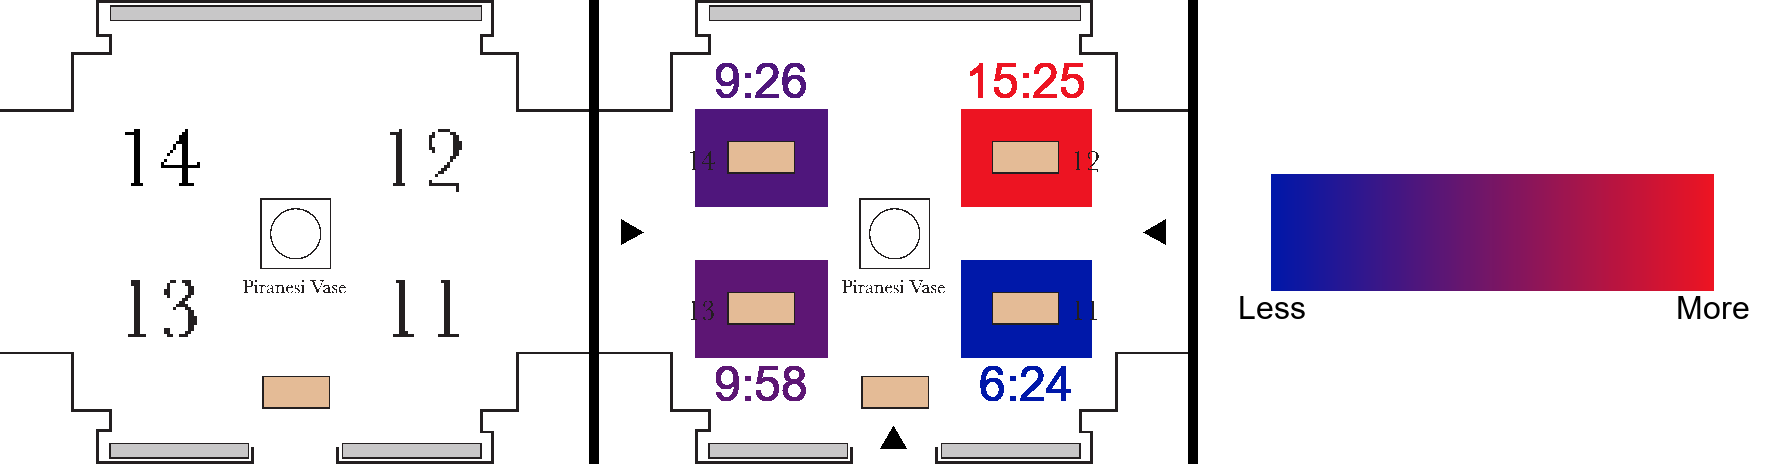

In [143]:
#get display time cases dark

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),displayEndMask2(getDarkPurpleColor))

for j in DISPLAY_BOXES1_CASES:
    drawNextToBox(data[0],DISPLAY_BOXES1_CASES[j],getTimeFromSeconds(data[1][j]/4),color = data[4][j])

data = cropRoom1(data,SCALE1)

for j in range(3):
    drawTriangle(data[0], ROOM1_TRIANGLES[j])

fig = makeFigure((3,1),data[0],gap=10,back=(0,0,0))
saveImage(data[0],1,'display_time/image/cases/dark/spec/total')

data = lessMoreScale(cropRoom1(ROOM1,SCALE1),getDarkPurpleColor)
saveImage(data,1,'display_time/image/cases/dark/label')
addToFigure(fig,data,(2,0))

data = cropRoom1(ROOM1LEGEND,SCALE1)
saveImage(data,1,'display_time/image/cases/dark/spec/legend')
addToFigure(fig,data,(0,0))

saveImage(fig[0],1,'display_time/image/cases/dark/spec/mult')
display(fig[0])

right {'12': 1415, '11': 660, '13': 301, '14': 825}
bottom {'11': 755, '13': 1172, '14': 453, '12': 1509}
left {'13': 919, '11': 124, '14': 987, '12': 778}


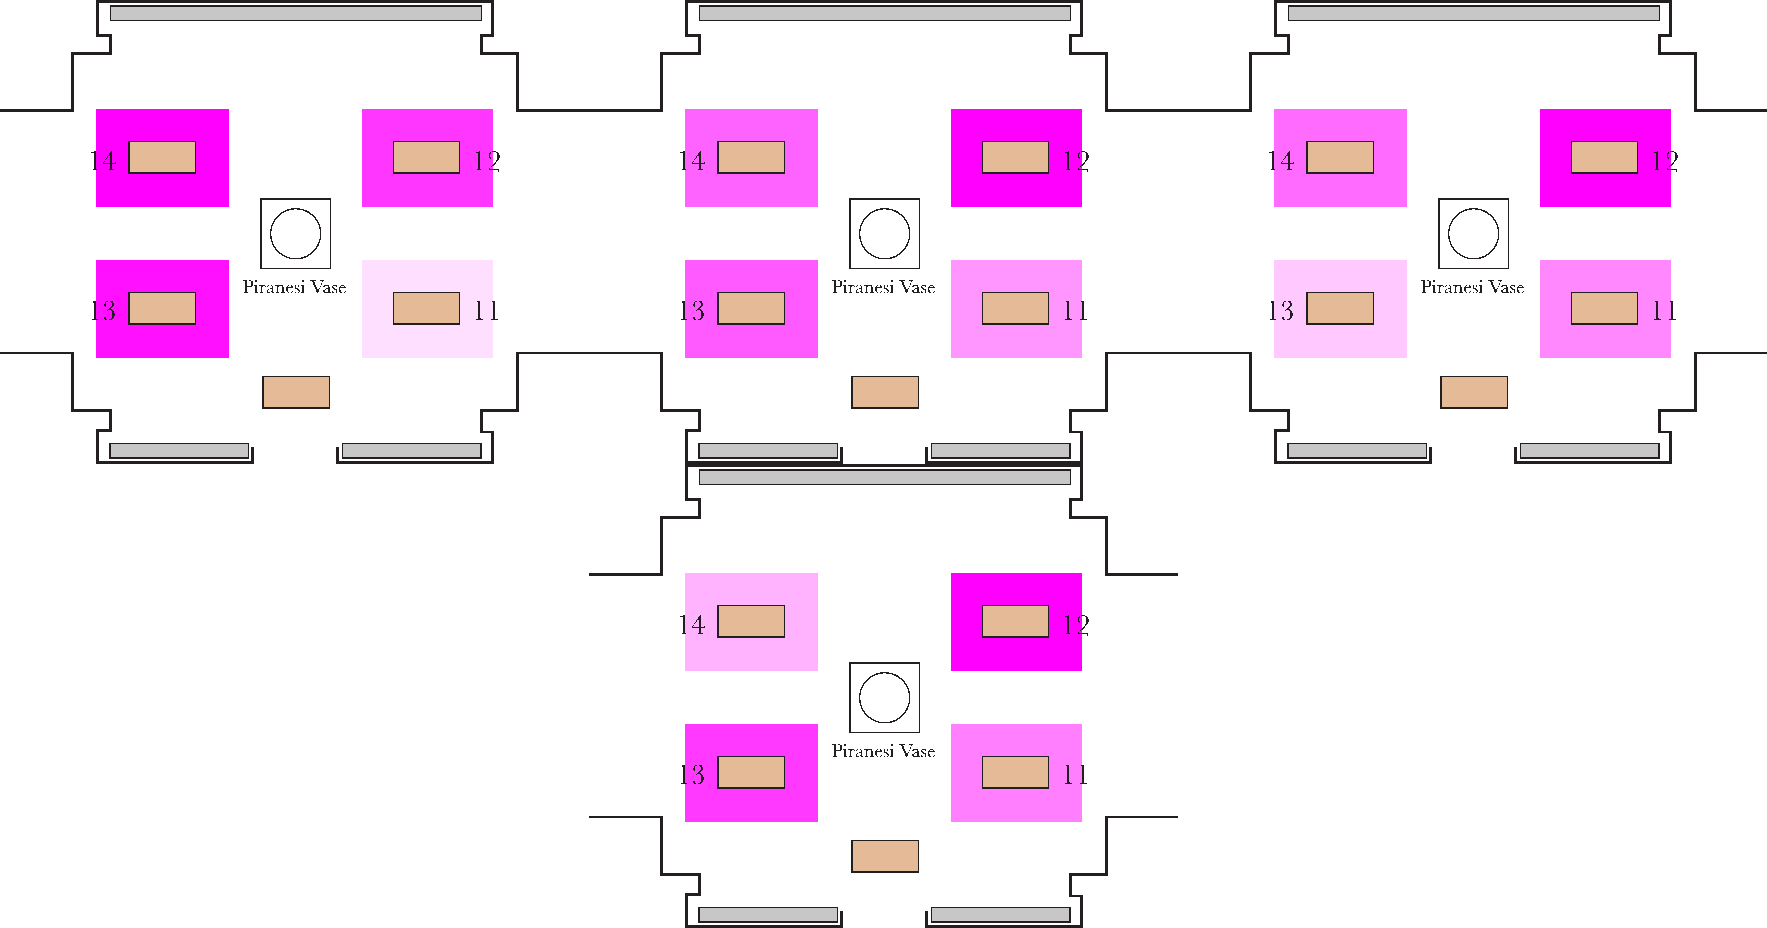

In [71]:
#get display time cases purple

data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,'display_time/image/cases/purple/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x),SCALE1))
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'display_time/image/cases/purple/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

display(fig[0])
saveImage(fig[0],1,'display_time/image/cases/purple/mult')

In [72]:
# #get display time min
# data=enlightenFolder(FOLDER1,countDisplayTime,({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x)[0],SCALE1))
# fig = makeFigure((3,2),data)
# saveImage(data,1,'display_time_total_min_color')

# for j,box in enumerate(SELECT_BOXES1):
#     x,y = getDirOffset(j)
#     data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x),SCALE1))
#     addToFigure(fig,data[0],(1-x,y))
#     saveImage(data[0],1,f'display_time_{ENTRANCES[(j+2)%4]}_min_color')
#     print(ENTRANCES[(j+2)%4],data[1])

# display(fig[0])
# saveImage(fig[0],1,'display_time_mult_min_color')

left {'13': 919, 'Va': 895, 'In': 923, '14': 987, '12': 778}


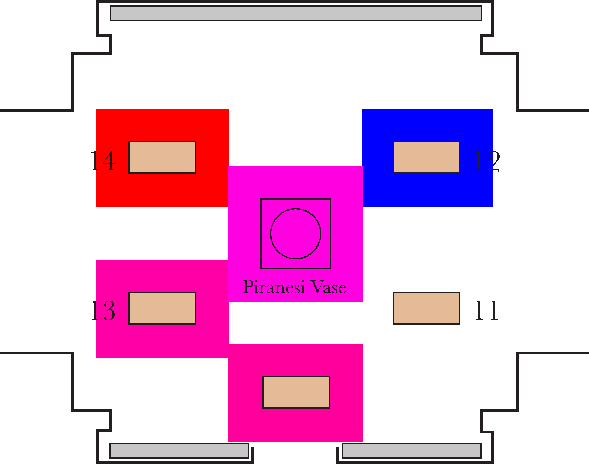

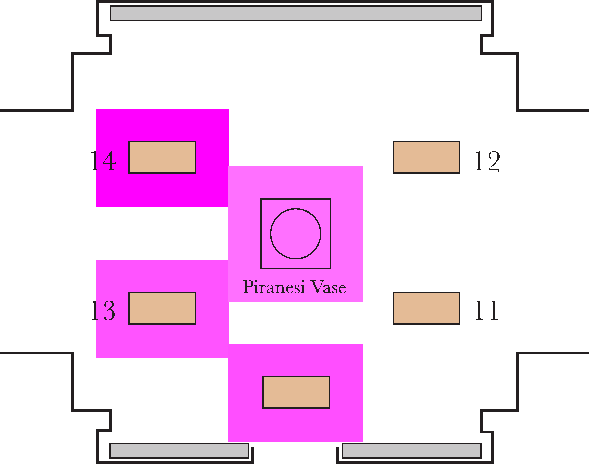

In [73]:
#get left outlier
data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,SELECT_BOXES1[-1]),({},dict(list(DISPLAY_BOXES1.items())[1:]),ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x),SCALE1))
saveImage(data[0],1,f'display_time/image/outlier/color/left')
print(ENTRANCES[(j+2)%4],data[1])
display(data[0])

data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTime,SELECT_BOXES1[-1]),({},dict(list(DISPLAY_BOXES1.items())[1:]),ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getWhitePurpleColor)(x),SCALE1))
saveImage(data[0],1,f'display_time/image/outlier/purple/left')
display(data[0])

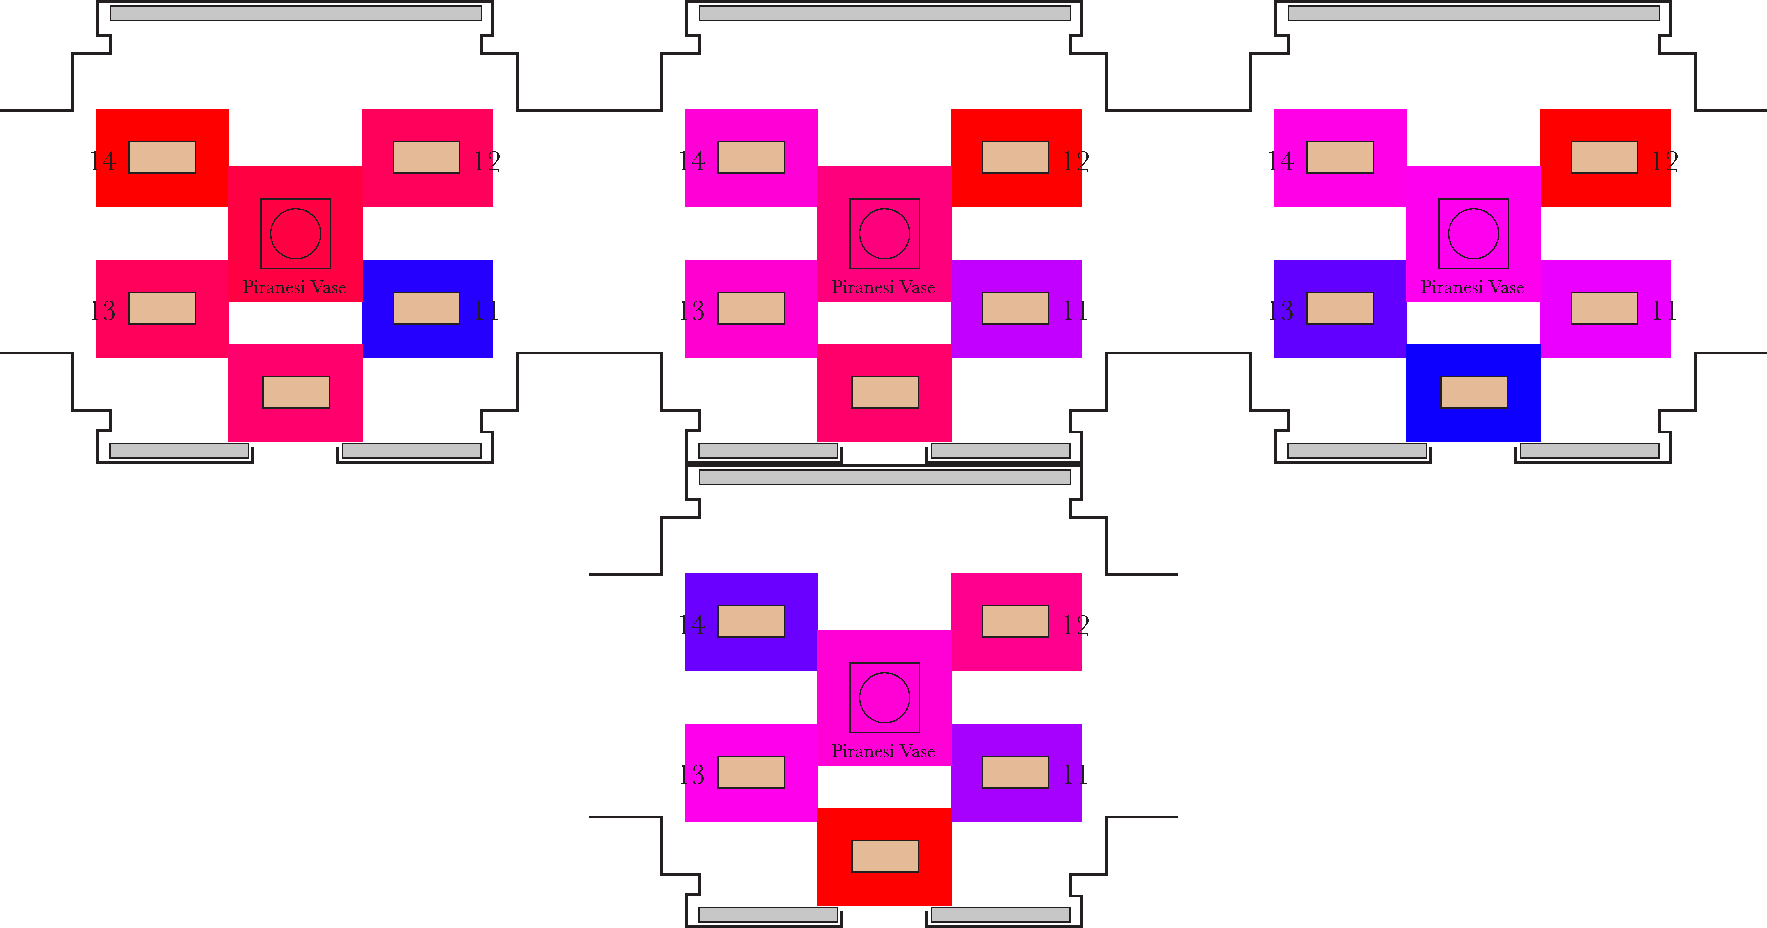

In [74]:
#get display time second min
for x in range(6):
    time = 2**x
    data=enlightenFolder(FOLDER1,countDisplayTimeMin(time),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x)[0],SCALE1))
    fig = makeFigure((3,2),data)
    saveImage(data,1,f'display_time/image/all/{time}_min/color/total')

    for j,box in enumerate(SELECT_BOXES1):
        x,y = getDirOffset(j)
        data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTimeMin(time),box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x)[0],SCALE1))
        addToFigure(fig,data,(1-x,y))
        saveImage(data,1,f'display_time/image/all/{time}_min/color/{ENTRANCES[(j+2)%4]}')
    if time ==4:
        display(fig[0])
        
    saveImage(fig[0],1,f'display_time/image/all/{time}_min/color/mult')

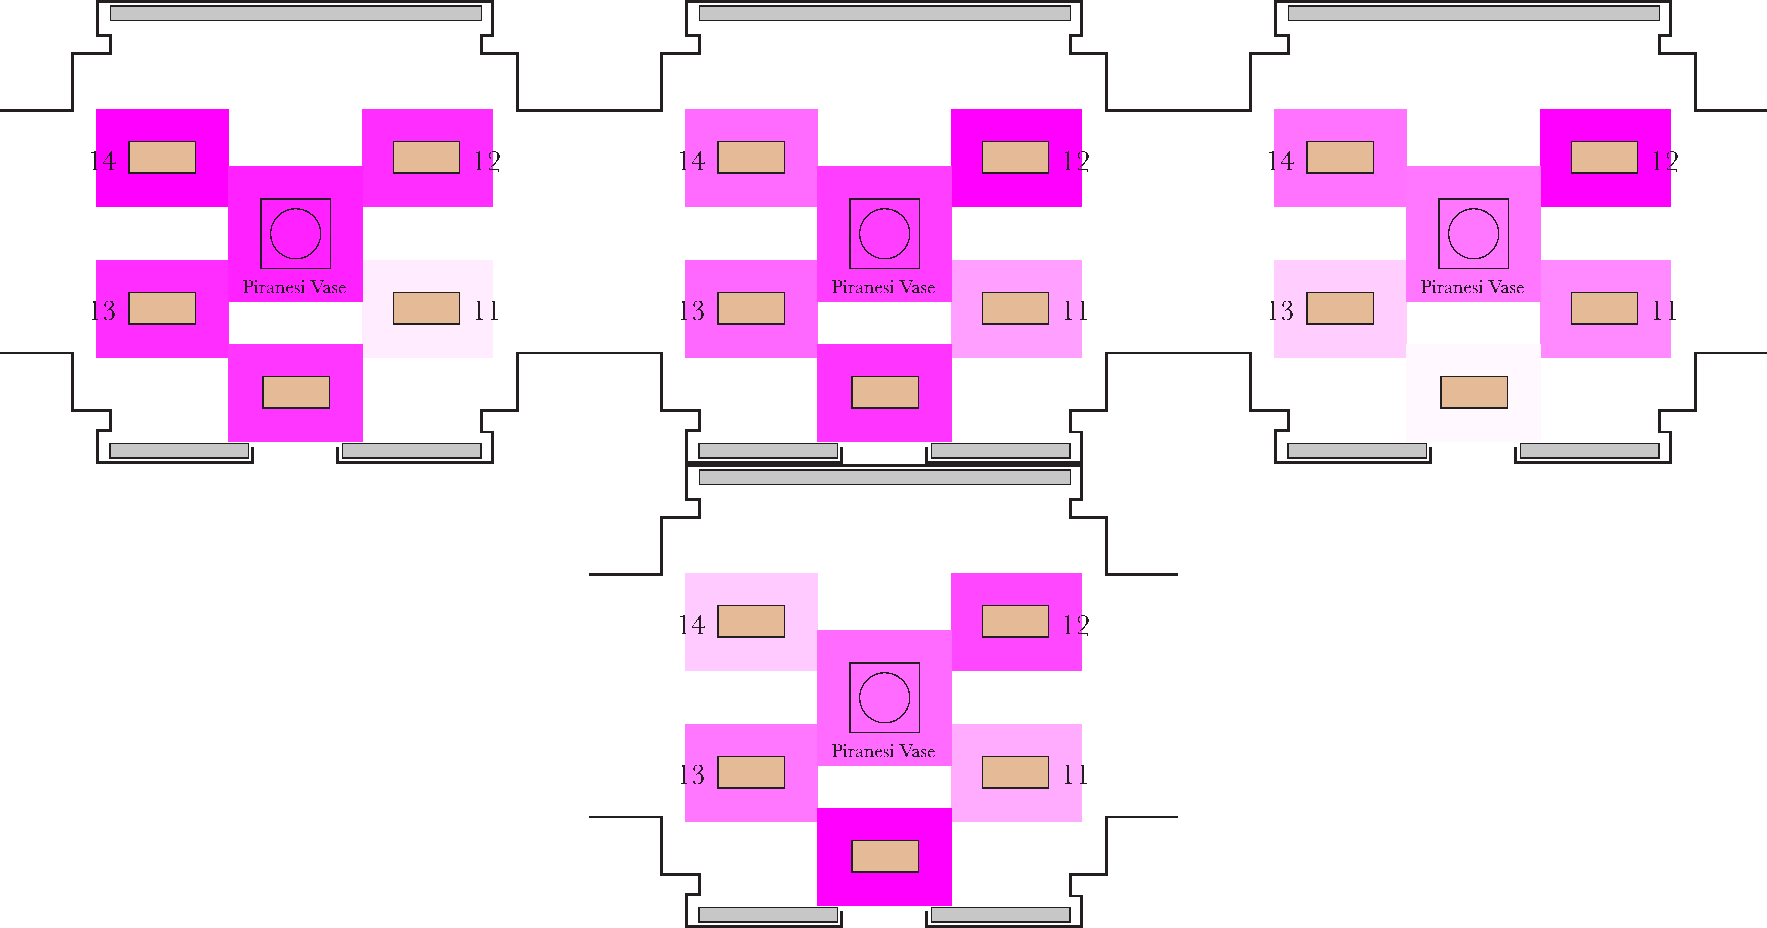

In [75]:
#get display time
for x in range(6):
    time = 2**x
    data=enlightenFolder(FOLDER1,countDisplayTimeMin(time),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
    fig = makeFigure((3,2),data)
    saveImage(data,1,f'display_time/image/all/{time}_min/purple/total')

    for j,box in enumerate(SELECT_BOXES1):
        x,y = getDirOffset(j)
        data=enlightenFolder(FOLDER1,selectEntrance(countDisplayTimeMin(time),box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
        addToFigure(fig,data,(1-x,y))
        saveImage(data,1,f'display_time/image/all/{time}_min/purple/{ENTRANCES[(j+2)%4]}')
    if time ==4:
        display(fig[0])
    saveImage(fig[0],1,f'display_time/image/all/{time}_min/purple/mult')

right {' ': 14, '12': 15, 'Va': 6, '11': 9, '14': 5, '13': 1, 'In': 0}
bottom {'In': 29, '13': 3, ' ': 11, 'Va': 3, '11': 2, '12': 2, '14': 0}
left {' ': 23, '14': 9, 'In': 3, 'Va': 5, '13': 10, '11': 0, '12': 0}


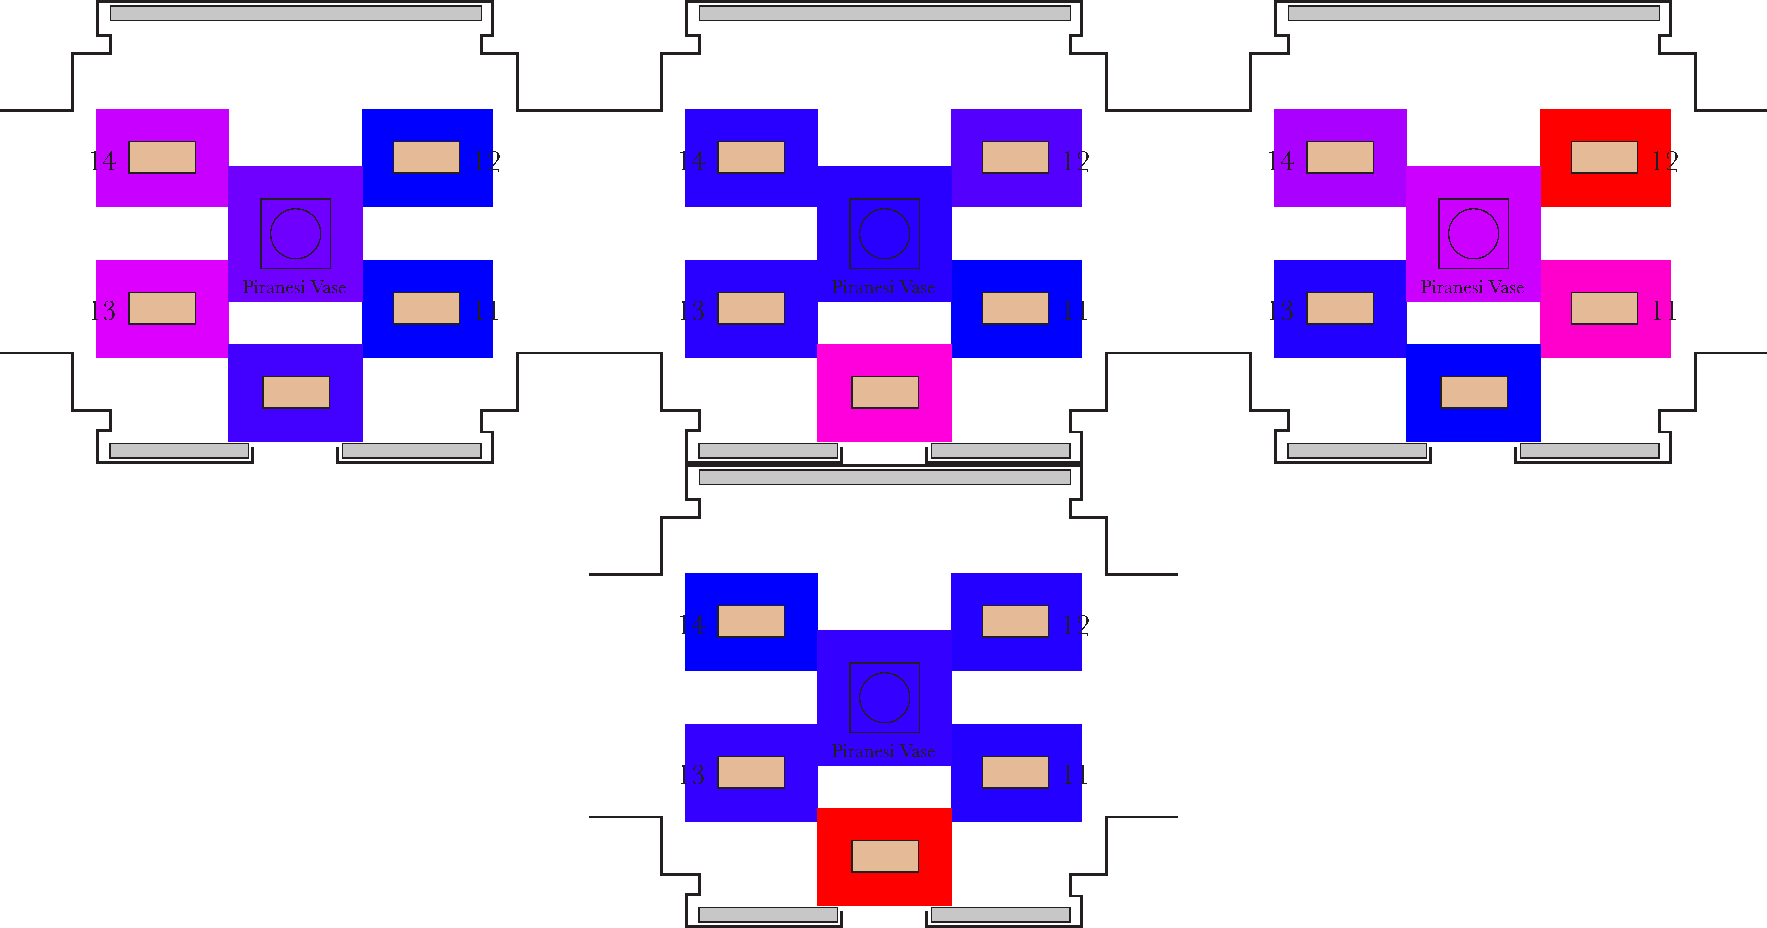

In [76]:
#visitor first display
time = 4
data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x)[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,f'first_display/{time}_min/color/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor)(x),SCALE1))
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'first_display/{time}_min/color/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

display(fig[0])
saveImage(fig[0],1,f'first_display/{time}_min/color/mult')

In [77]:
# #visitor first display based
# time = 4
# data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x)[0],SCALE1))
# fig = makeFigure((3,2),data)
# saveImage(data,1,f'first_display_{time}_min_base_total_color')

# for j,box in enumerate(SELECT_BOXES1):
#     x,y = getDirOffset(j)
#     data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x),SCALE1))
#     addToFigure(fig,data[0],(1-x,y))
#     saveImage(data[0],1,f'first_display_{time}_min_base_{ENTRANCES[(j+2)%4]}_color')
#     print(ENTRANCES[(j+2)%4],data[1])

# display(fig[0])
# saveImage(fig[0],1,f'first_display_{time}_min_base_mult_color')

In [78]:
# #visitor first display based purple
# time = 4
# data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
# fig = makeFigure((3,2),data)
# saveImage(data,1,f'first_display_{time}_min_base_total_purple')

# for j,box in enumerate(SELECT_BOXES1):
#     x,y = getDirOffset(j)
#     data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},DISPLAY_BOXES1,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x),SCALE1))
#     addToFigure(fig,data[0],(1-x,y))
#     saveImage(data[0],1,f'first_display_{time}_min_base_{ENTRANCES[(j+2)%4]}_purple')
#     print(ENTRANCES[(j+2)%4],data[1])

# #display(fig[0])
# saveImage(fig[0],1,f'first_display_{time}_min_base_mult_purple')

In [79]:
# #only first cases
# boxes = dict(list(DISPLAY_BOXES1.items())[:-2])
# time = 4
# data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},boxes,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x)[0],SCALE1))
# fig = makeFigure((3,2),data)
# saveImage(data,1,f'first_display_{time}_min_base_case_total_color')

# for j,box in enumerate(SELECT_BOXES1):
#     x,y = getDirOffset(j)
#     data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},boxes,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getPurpleColor)(x),SCALE1))
#     addToFigure(fig,data[0],(1-x,y))
#     saveImage(data[0],1,f'first_display_{time}_min_base_case_{ENTRANCES[(j+2)%4]}_color')
#     print(ENTRANCES[(j+2)%4],data[1])

# #display(fig[0])
# saveImage(fig[0],1,f'first_display_{time}_min_base_case_mult_color')

right {'12': 15, '11': 10, '14': 6, '13': 2}
bottom {'13': 10, '12': 4, '11': 11, '14': 1}
left {'14': 10, '13': 11, '11': 0, '12': 0}


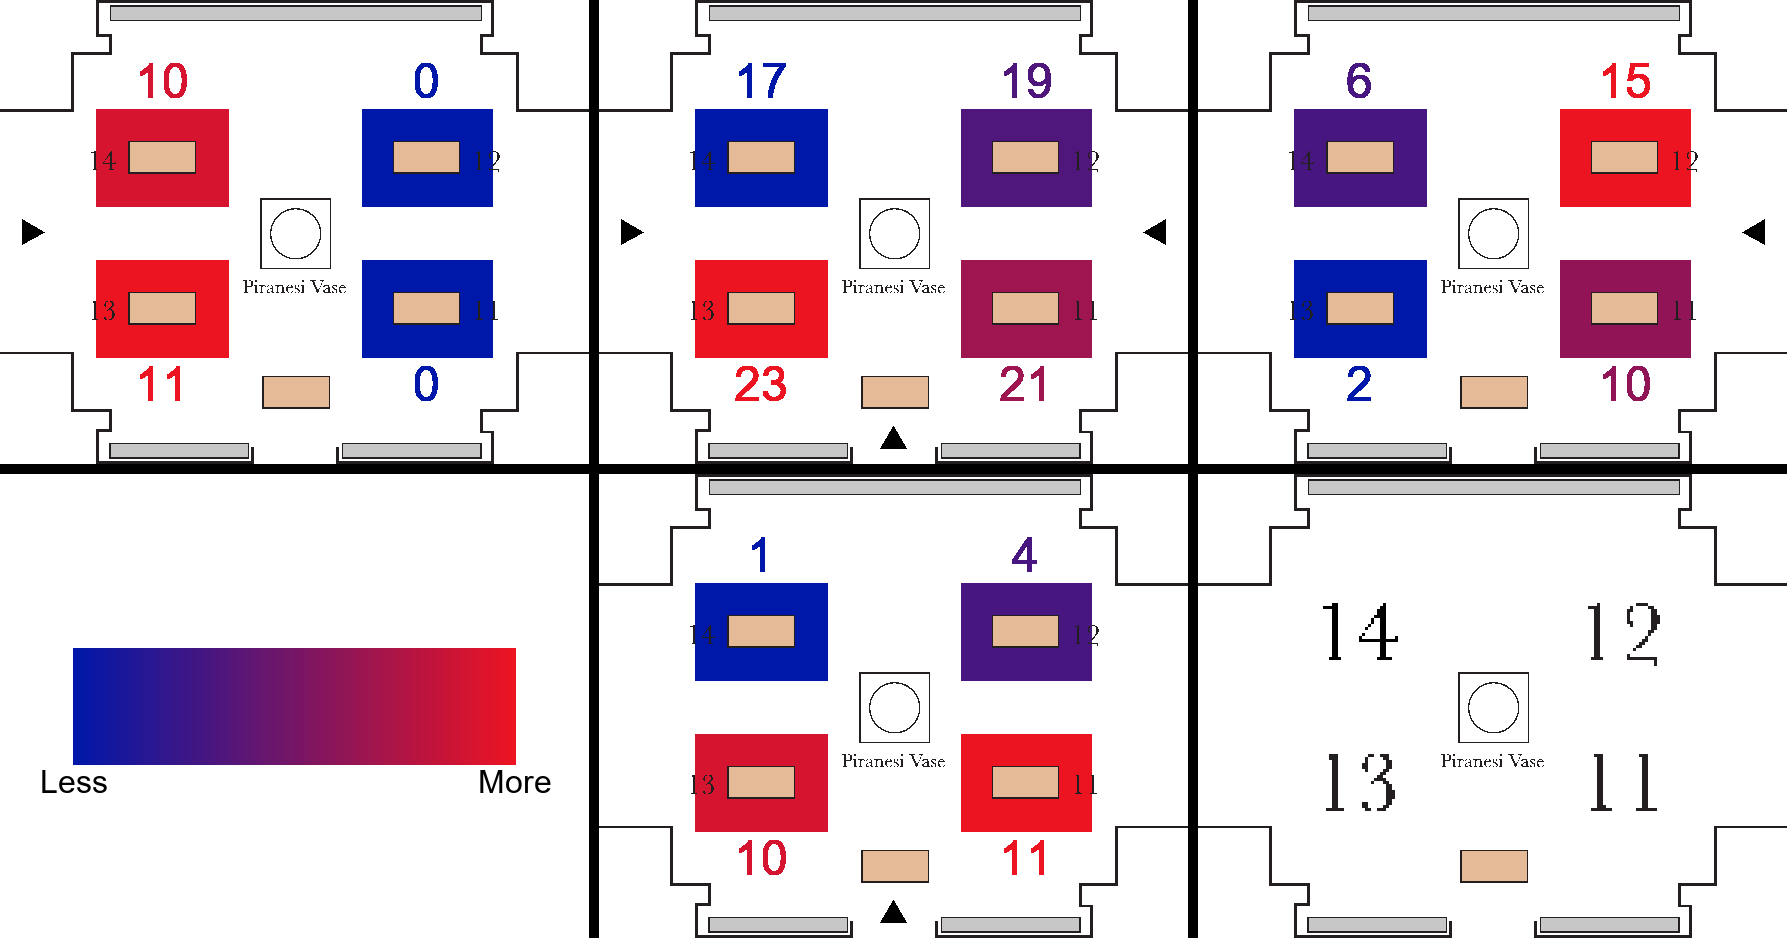

In [149]:
#only first cases no passthough dark
time = 4
data=enlightenFolder(FOLDER1,countFirstDisplay(time),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),displayEndMask2(getDarkPurpleColor,True))

for j in DISPLAY_BOXES1_CASES:
    drawNextToBox(data[0],DISPLAY_BOXES1_CASES[j],str(data[1][j]),color = data[4][j])

data = cropRoom1(data,SCALE1)

for j in range(3):
    drawTriangle(data[0], ROOM1_TRIANGLES[j])

#drawAverageVisitorRoom1(data)

fig = makeFigure((3,2),data[0],gap=10,back=(0,0,0))
saveImage(data[0],1,f'first_display/cases/no_passthough/{time}_min/dark/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(time),box),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),displayEndMask2(getDarkPurpleColor,True))

    for i in DISPLAY_BOXES1_CASES:
        drawNextToBox(data[0],DISPLAY_BOXES1_CASES[i],str(data[1][i]),color = data[4][i])

    data = cropRoom1(data,SCALE1)

    drawTriangle(data[0],ROOM1_TRIANGLES[j])

    #drawAverageVisitorRoom1(data)
    
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'first_display/cases/no_passthough/{time}_min/dark/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

#display(fig[0])
saveImage(fig[0],1,f'first_display/cases/no_passthough/{time}_min/dark/mult')
data = lessMoreScale(cropRoom1(ROOM1,SCALE1),getDarkPurpleColor)
saveImage(data,1,f'first_display/cases/no_passthough/{time}_min/dark/label')
addToFigure(fig,data,(0,1))
saveImage(fig[0],1,f'first_display/cases/no_passthough/{time}_min/dark/mult_label')
data = cropRoom1(ROOM1LEGEND,SCALE1)
saveImage(data,1,f'first_display/cases/no_passthough/{time}_min/dark/legend')
addToFigure(fig,data,(2,1))
saveImage(fig[0],1,f'first_display/cases/no_passthough/{time}_min/dark/mult_legend')
display(fig[0])

right {'12': 15, '11': 10, '14': 6, '13': 2}
bottom {'13': 10, '12': 4, '11': 11, '14': 1}
left {'14': 10, '13': 11, '11': 0, '12': 0}


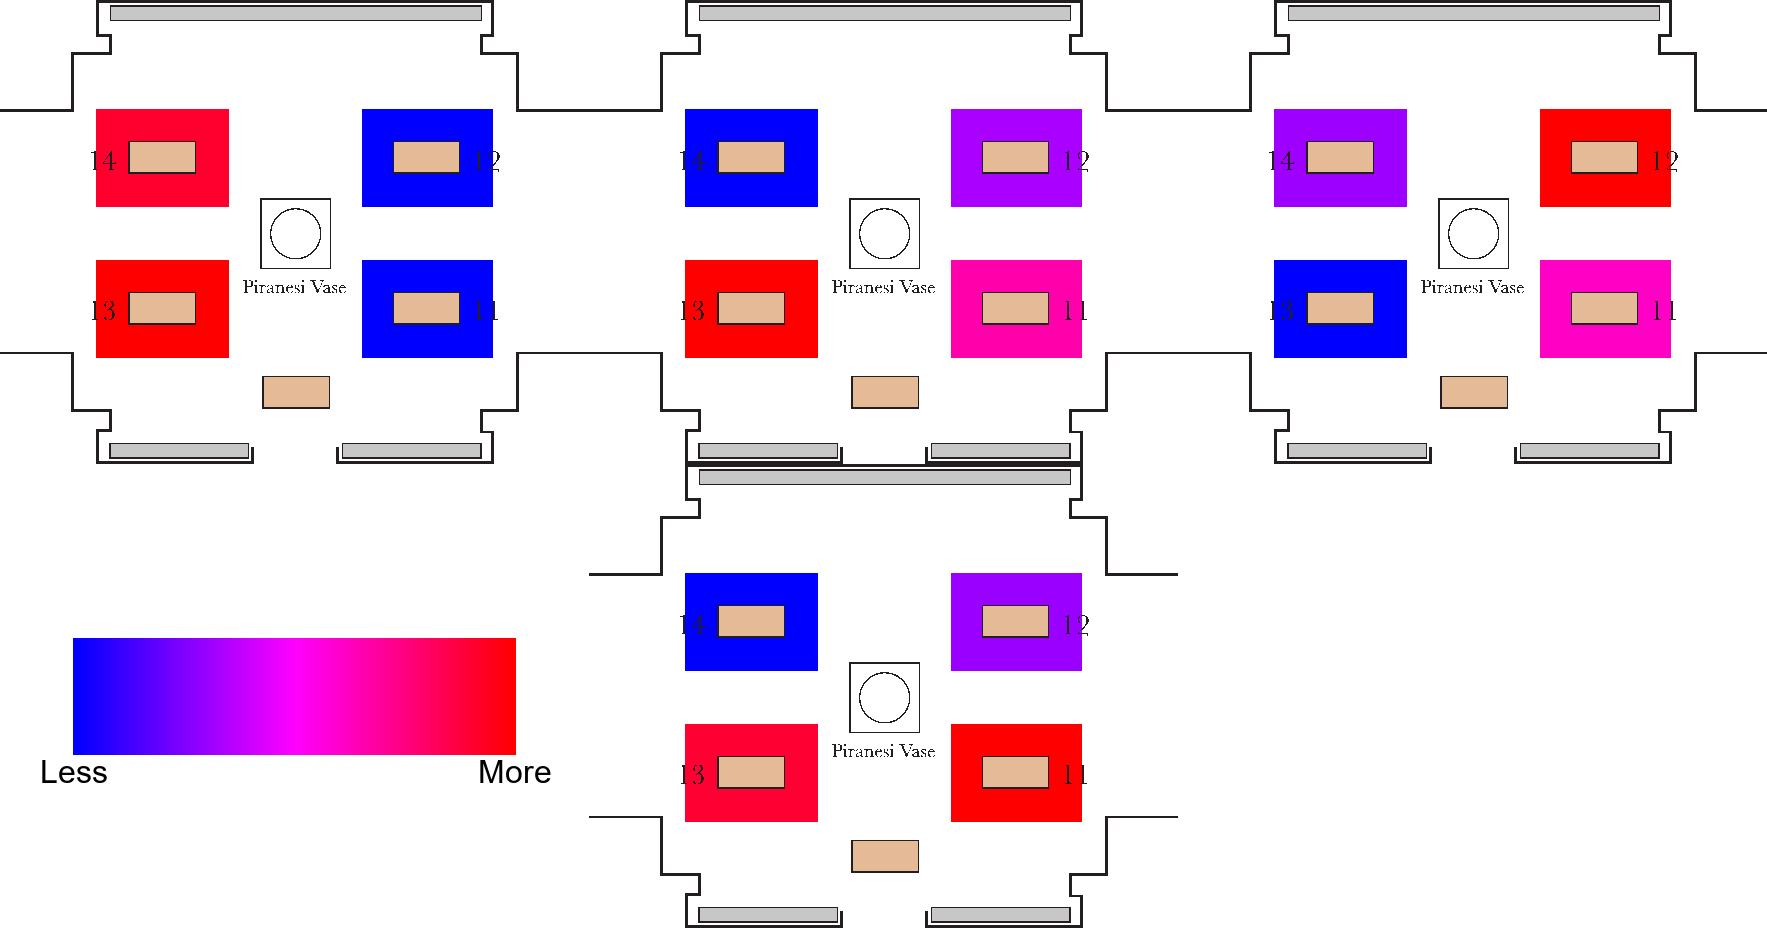

In [81]:
#only first cases no passthough
time = 4
data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor,True)(x)[0],SCALE1))
fig = makeFigure((3,2),data)
saveImage(data,1,f'first_display/cases/no_passthough/{time}_min/color/total')

for j,box in enumerate(SELECT_BOXES1):
    x,y = getDirOffset(j)
    data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},DISPLAY_BOXES1_CASES,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask2(getPurpleColor,True)(x),SCALE1))
    addToFigure(fig,data[0],(1-x,y))
    saveImage(data[0],1,f'first_display/cases/no_passthough/{time}_min/color/{ENTRANCES[(j+2)%4]}')
    print(ENTRANCES[(j+2)%4],data[1])

#display(fig[0])
saveImage(fig[0],1,f'first_display/cases/no_passthough/{time}_min/color/mult')
data = lessMoreScale(cropRoom1(ROOM1,SCALE1),getPurpleColor)
saveImage(data,1,f'first_display/cases/no_passthough/{time}_min/color/label')
addToFigure(fig,data,(0,1))
saveImage(fig[0],1,f'first_display/cases/no_passthough/{time}_min/color/mult_label')
display(fig[0])

In [82]:
# #only cases first purple
# boxes = dict(list(DISPLAY_BOXES1.items())[:-2])
# time = 4
# data=enlightenFolder(FOLDER1,countFirstDisplay(4),({},boxes,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x)[0],SCALE1))
# fig = makeFigure((3,2),data)
# saveImage(data,1,f'first_display_{time}_min_base_case_total_purple')

# for j,box in enumerate(SELECT_BOXES1):
#     x,y = getDirOffset(j)
#     data=enlightenFolder(FOLDER1,selectEntrance(countFirstDisplay(4),box),({},boxes,ROOM1,ROOM1MASK),lambda x:cropRoom1(displayEndMask(getWhitePurpleColor)(x),SCALE1))
#     addToFigure(fig,data[0],(1-x,y))
#     saveImage(data[0],1,f'first_display_{time}_min_base_case_{ENTRANCES[(j+2)%4]}_purple')
#     print(ENTRANCES[(j+2)%4],data[1])

# #display(fig[0])
# saveImage(fig[0],1,f'first_display_{time}_min_base_case_mult_purple')

In [83]:
#user num run
#enlightenFolder(FOLDER1,getUserTypeLists,([],[],[],[]))
enlightenFolder(FOLDER1,drawVisitors(1,'draw',lambda x:cropRoom1(x,SCALE1)),(ROOM1,0),lambda x:x[1])
enlightenFolder(FOLDER1,drawVisitors(1,'drawNoCrop'),(ROOM1,0),lambda x:x[1],False)

150

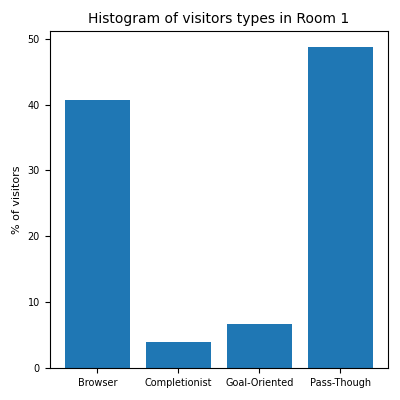

In [84]:
#user type run
data= enlightenFolder(FOLDER1,countUserTypes,([0,0,0,0],0),graphUserTypes(' in Room 1'))
saveImage(data[0],1,'visitor_types')
display(data[0])

1 [8, 9, 5, 2, 8, 1, 1] 34 0:49 average
2 [12, 25, 4, 4, 15, 5, 0, 1, 0, 0, 0, 0, 1] 67 0:53 average
3 [5, 3, 0, 1, 1, 2, 1] 13 0:53 average
4+ [4, 5, 1, 2, 4, 2, 0, 1, 0, 0, 1] 20 1:23 average


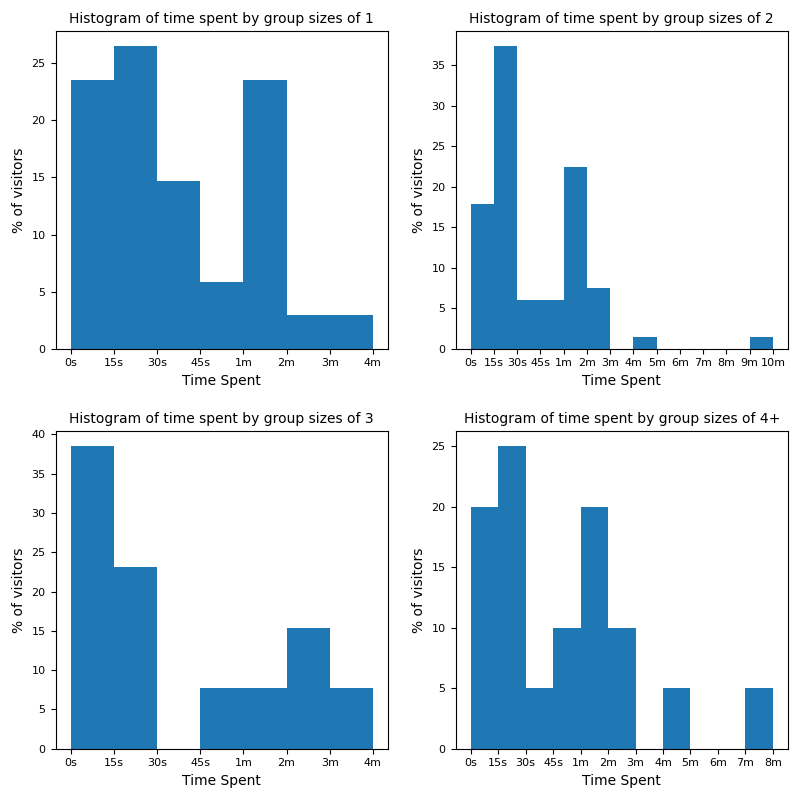

In [85]:
#group size time spent
fig = None
for j in range(4):
    data = enlightenFolder(FOLDER1,selectGroupSize(countTimeSpentLess1,j+1),({},0),histTimesLess1Room(f' by group sizes of {GROUP_SIZE_NAMES[j]}',size=10))
    average = enlightenFolder(FOLDER1,selectGroupSize(getAverage,j+1),(0,0),getAverageEnd(f''))
    saveImage(data[0],1,f'time_spent/group/{GROUP_SIZE_NAMES[j]}')
    print(GROUP_SIZE_NAMES[j],data[1],data[2],average)
    if fig is None:
        fig = makeFigure((2,2),data[0])
    else:
        addToFigure(fig,data[0],(j%2,j//2))
saveImage(fig[0],1,'time_spent/group/mult')
display(fig[0])
    

In [86]:
# #group size type
# fig = None
# for j in range(4):
#     data = enlightenFolder(FOLDER1,selectGroupSize(countUserTypes,j+1),([0,0,0,0],0),graphUserTypes(f" for group size of {GROUP_SIZE_NAMES[j]}",10))
#     saveImage(data[0],1,f'user_type_group_{GROUP_SIZE_NAMES[j]}')
#     print(GROUP_SIZE_NAMES[j],data[1],data[2])
#     if fig is None:
#         fig = makeFigure((2,2),data[0])
#     else:
#         addToFigure(fig,data[0],(j%2,j//2))
# saveImage(fig[0],1,'user_type_group_mult')
# display(fig[0])

# data = enlightenFolder(FOLDER1,selectGroupSize(countUserTypes,0),([0,0,0,0],0),graphUserTypes(f" for group size of 0",10))
# print(0,data[1],data[2])
# saveImage(data[0],1,'user_type_group_0')
# display(data[0])

In [87]:
# #user type time spent
# fig = None
# for j in range(4):
#     data = enlightenFolder(FOLDER1,selectUserType(countTimeSpentLess1,j),({},0),histTimesLess1Room(f' by {USER_TYPES[j]} visitors',size=10))
#     saveImage(data[0],1,f'time_spent_type_{j}')
#     if fig is None:
#         fig = makeFigure((2,2),data[0])
#     else:
#         addToFigure(fig,data[0],(j%2,j//2))
# saveImage(fig[0],1,'time_spent_type_mult')
# display(fig[0])
    

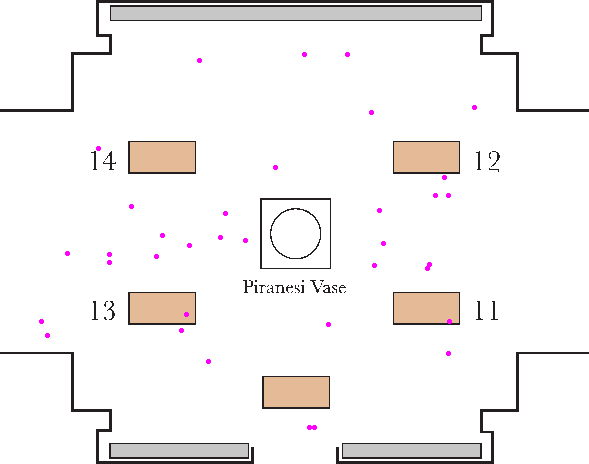

In [88]:
data = enlightenFolder(FOLDER1,drawPhotos,(ROOM1.copy(),0),lambda x:cropRoom1(x,SCALE1))
saveImage(data[0],1,'photos')
display(data[0])

In [89]:
#gif drawing run
ROOM1GIF = enlightenFolder(FOLDER1,drawGif,([],ROOM1),getGifStream(lambda x:cropRoom1(x,SCALE1)))
saveGif(ROOM1GIF[0],1,'gif')

In [110]:
#gif drawing run 2
ROOM1GIF2 = enlightenFolder(FOLDER1,drawGifActions,([],ROOM1),getGifStream(lambda x:cropRoom1(x,SCALE1)))
saveGif(ROOM1GIF2[0],1,'gif2')

In [111]:
displayGif(ROOM1GIF2[0])

Image(value=b'GIF89aM\x02\xd0\x01\x87\x00\x00\xff\xff\xff\xe4\xbb\x96#\x1f \xc8\xc7\xc8\xff\x00\xff\x00\x00\x0…

# Room 2 V2

In [92]:
#masks
fig = None

for j,box in enumerate(SELECT_BOXES2V2):
        x,y = getDirOffset(j+2)
        # x2,y2 = getDirOffset(j-1)
        data = displayBox(ROOM2,box)
        saveImage(data,'2v2',f'mask/{ENTRANCES[(j+2)%4]}')
        if fig is None:
            fig = makeFigure((3,2),data,(1+x,-y))
        else:
            addToFigure(fig,data,(1+x,-y))
            
saveImage(fig[0],'2v2','mask/mult')

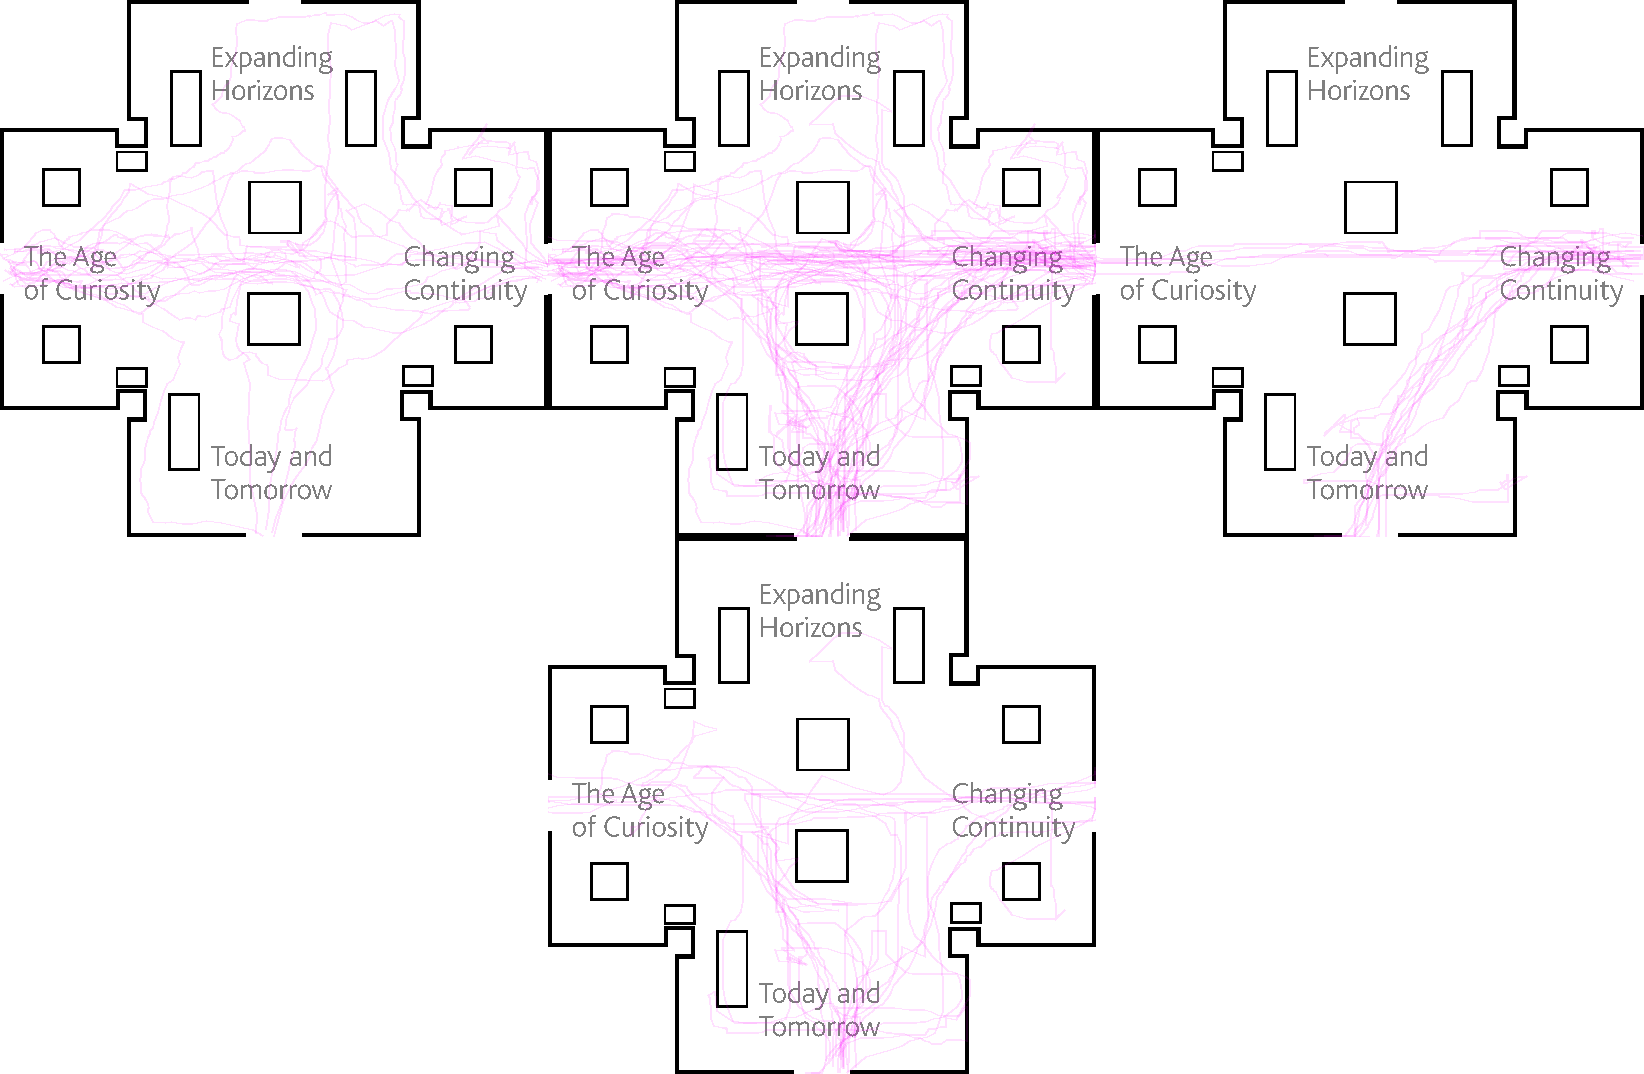

In [93]:
#Opacity drawing run

data = enlightenFolder(FOLDER2V2,opacityDrawer,opacityDrawerStart(ROOM2))
fig = makeFigure((3,2),data[0])
saveImage(data[0],'2v2','opacity_drawing/total')
for j,box in enumerate(SELECT_BOXES2V2):
        x,y = getDirOffset(j+2)
        data = enlightenFolder(FOLDER2V2,selectEntrance(opacityDrawer,box),opacityDrawerStart(ROOM2))
        saveImage(data[0],'2v2',f'opacity_drawing/{ENTRANCES[(j+2)%4]}')
        addToFigure(fig,data[0],(1+x,-y))

saveImage(fig[0],'2v2','opacity_drawing/mult')
display(fig[0])



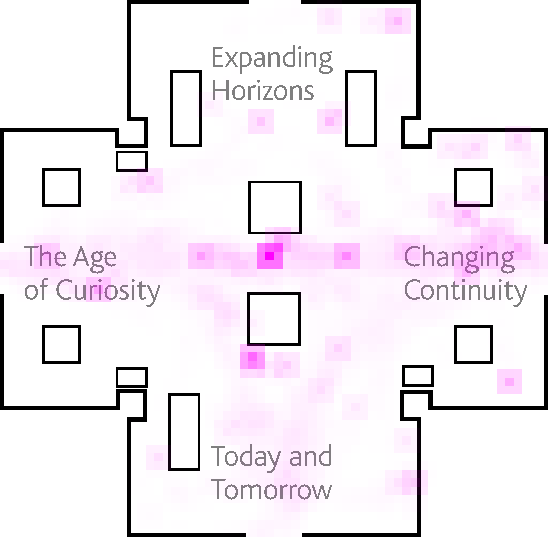

In [94]:
#histodraw
data = enlightenFolder(FOLDER2V2,countBoxPixels2,countBoxPixelsStart((64,64)),countBoxPixelsOverlayEnd(ROOM2))
saveImage(data,'2v2','heat_map')
display(data)

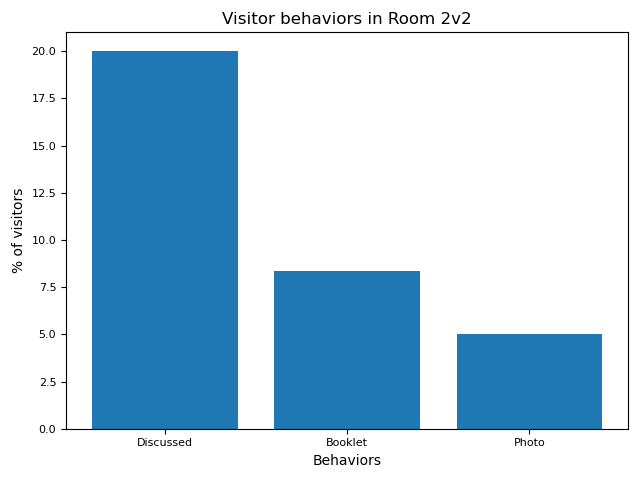

In [95]:
#count behaviors run
data = enlightenFolder(FOLDER2V2,countBehaviors,({},0),graphBehaviors('2v2'))
saveImage(data[0],'2v2','behaviors')
display(data[0])

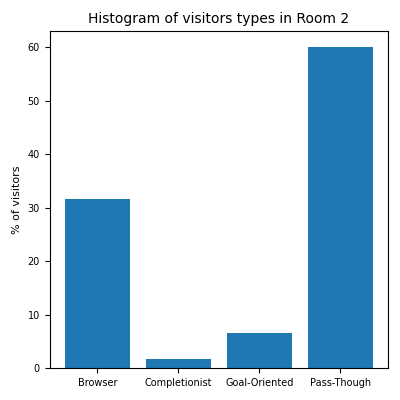

In [96]:
#user type run
data= enlightenFolder(FOLDER2V2,countUserTypes,([0,0,0,0],0),graphUserTypes(' in Room 2'))
saveImage(data[0],'2 both','visitor_types')
display(data[0])

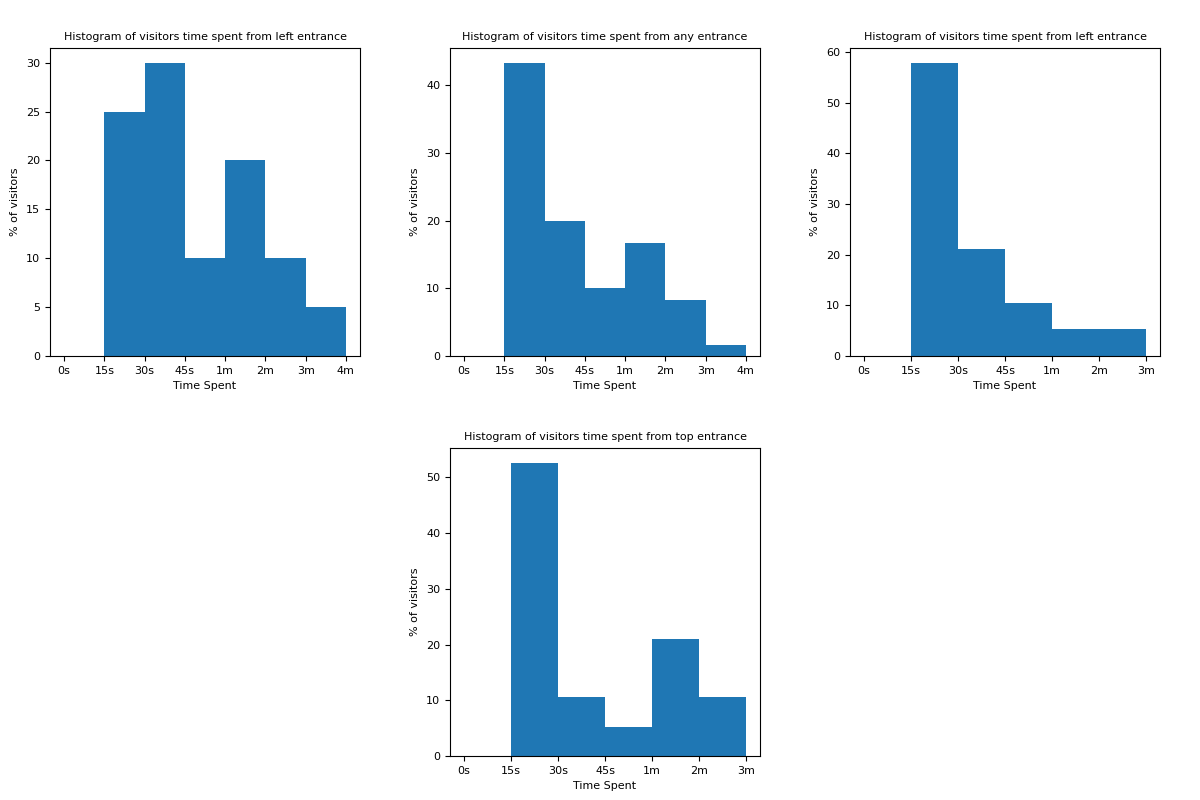

In [97]:
#count time run
data=enlightenFolder(FOLDER2V2,countTimeSpentLess1,({},0),histTimesLess1('any'))
saveImage(data[0],'2v2','time_spent/total')
fig = makeFigure((3,2),data[0])
for j,box in enumerate(SELECT_BOXES2V2):
    x,y = getDirOffset(j+2)
    data=enlightenFolder(FOLDER2V2,selectEntrance(countTimeSpentLess1,box),({},0),histTimesLess1(ENTRANCES[(j+2)%2]))
    saveImage(data[0],'2v2',f'time_spent/{ENTRANCES[(j+2)%2]}')
    addToFigure(fig,data[0],(1+x,-y))
    
saveImage(fig[0],'2v2',f'time_spent/mult')
display(fig[0])

In [98]:
#gif drawing run
ROOM2V2GIF = enlightenFolder(FOLDER2V2,drawGif,([],ROOM2),getGifStream())
saveGif(ROOM2V2GIF[0],'2v2','gif')

In [99]:
displayGif(ROOM2V2GIF[0])

Image(value=b'GIF89a$\x02\x19\x02\x87\x00\x00\xff\xff\xff\x00\x00\x00\x7f\x7f\x7f\xff\x00\xff\x00\x00\x00\x00\…

# Other

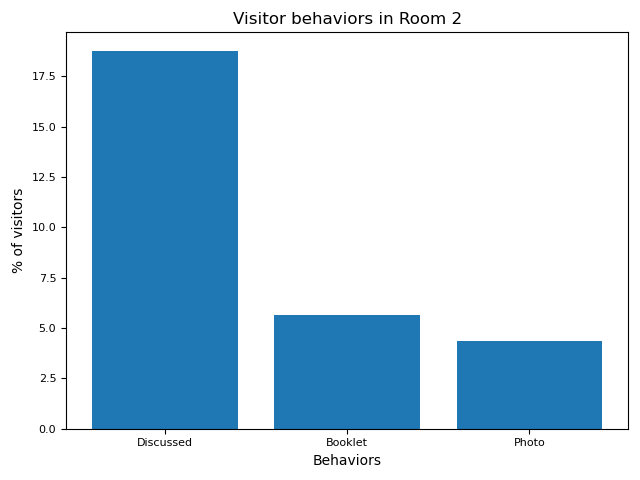

In [100]:
#count behaviors run both
data = enlightenFolder(FOLDER2BOTH,countBehaviors,({},0),graphBehaviors('2'))
saveImage(data[0],'2 both','behaviors')
display(data[0])

In [109]:
#gif drawing run 2
ROOM2BOTHGIF = enlightenFolder(FOLDER2BOTH,drawGifActions,([],ROOM2),getGifStream())
saveGif(ROOM2BOTHGIF[0],'2 both','gif2')

In [108]:
displayGif(ROOM2BOTHGIF[0])

Image(value=b'GIF89a$\x02\x19\x02\x87\x00\x00\xff\xff\xff\x00\x00\x00\x7f\x7f\x7f\xff\x00\xff\x00\x00\x00\x00\…

In [101]:
#compare averages
print(enlightenFolder(FOLDER4,getAverage,(0,0),getAverageEnd(' in room 4')))
print(enlightenFolder(FOLDER2,getAverage,(0,0),getAverageEnd(' in room 2')))
print(enlightenFolder(FOLDER1,getAverage,(0,0),getAverageEnd(' in room 1')))

print(f'no min')
print(enlightenFolder(FOLDER2,getAverageBox,(0,0,ROOM2,DISPLAY_BOXES2['Up']),getAverageEnd(' for up')))
print(enlightenFolder(FOLDER2,getAverageBox,(0,0,ROOM2,DISPLAY_BOXES2['Down']),getAverageEnd(' for down')))
print(enlightenFolder(FOLDER1,getAverageBox,(0,0,ROOM1,DISPLAY_BOXES1['11']),getAverageEnd(' for 11')))

for x in range(0,5):
    time = 2**x
    print(f'min {time}')
    print(enlightenFolder(FOLDER2,getAverageBoxMin(time),(0,0,ROOM2,DISPLAY_BOXES2['Up']),getAverageEnd(f' for up')))
    print(enlightenFolder(FOLDER2,getAverageBoxMin(time),(0,0,ROOM2,DISPLAY_BOXES2['Down']),getAverageEnd(f' for down')))
    print(enlightenFolder(FOLDER1,getAverageBoxMin(time),(0,0,ROOM1,DISPLAY_BOXES1['11']),getAverageEnd(f' for 11')))

0:59 average in room 4
0:52 average in room 2
0:57 average in room 1
no min
0:13 average for up
0:12 average for down
0:06 average for 11
min 1
0:15 average for up
0:14 average for down
0:08 average for 11
min 2
0:15 average for up
0:16 average for down
0:10 average for 11
min 4
0:15 average for up
0:18 average for down
0:14 average for 11
min 8
0:22 average for up
0:21 average for down
0:19 average for 11
min 16
0:27 average for up
0:35 average for down
0:25 average for 11


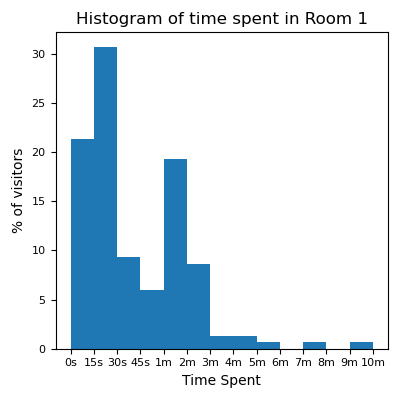

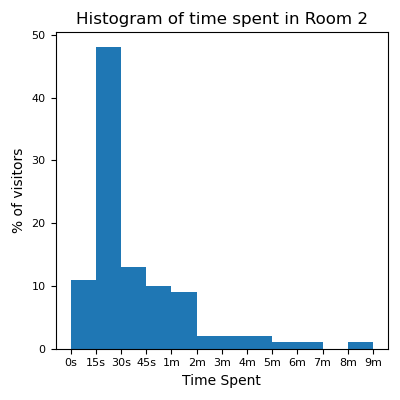

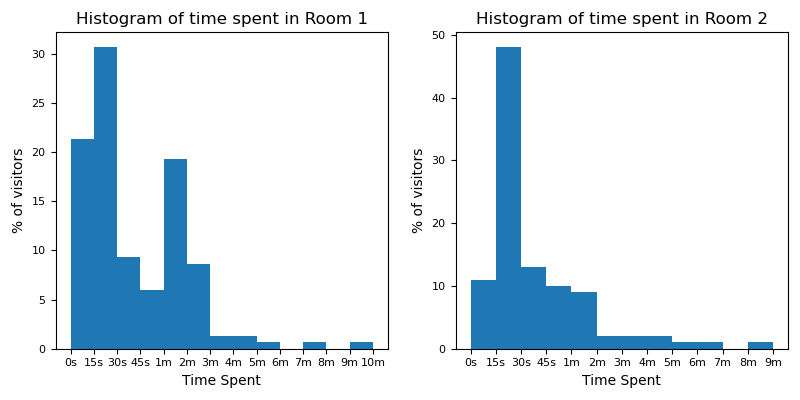

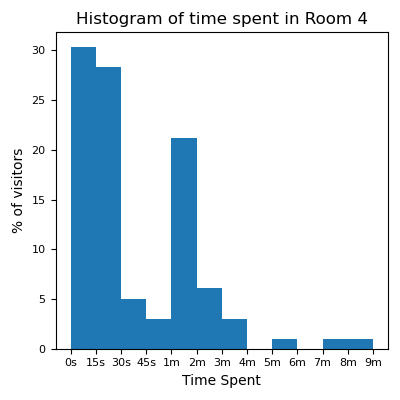

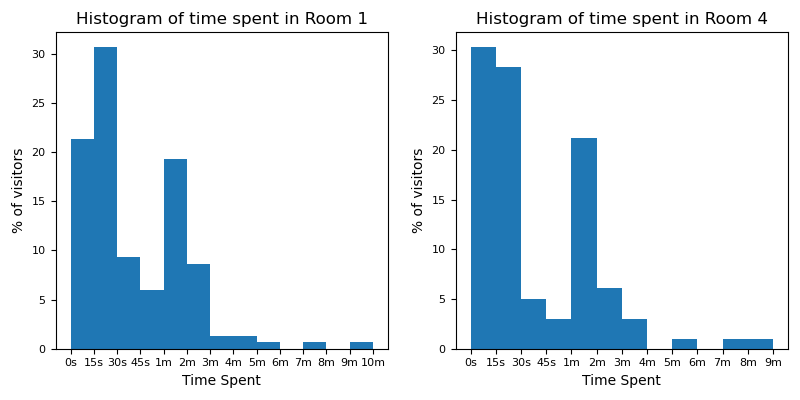

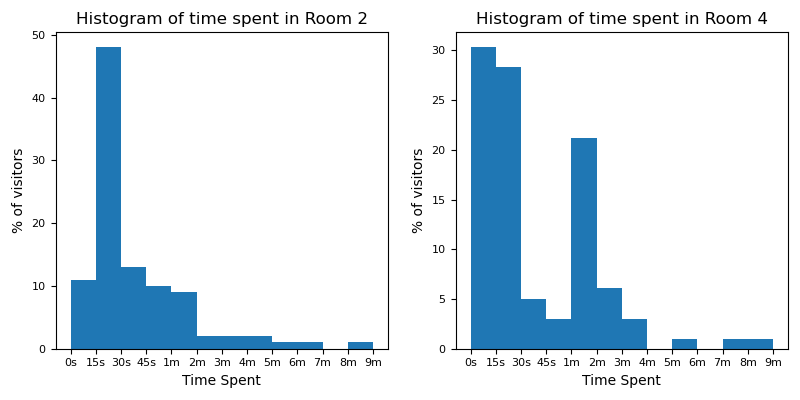

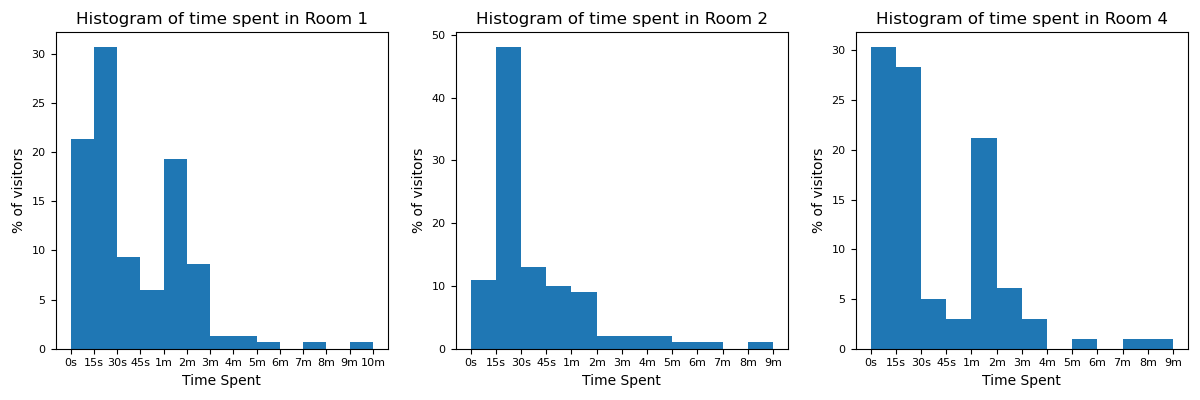

In [102]:
#compare time
time1 = enlightenFolder(FOLDER1,countTimeSpentLess1,({},0),histTimesLess1Room(' in Room 1'))
time2 = enlightenFolder(FOLDER2,countTimeSpentLess1,({},0),histTimesLess1Room(' in Room 2'))
time4 = enlightenFolder(FOLDER4,countTimeSpentLess1,({},0),histTimesLess1Room(' in Room 4'))
for x in range(8):
    draw = []
    if x&1:
        draw.append(time1[0])
    if x&2:
        draw.append(time2[0])
    if x&4:
        draw.append(time4[0])
    if len(draw)>0:
        fig = makeFigure((len(draw),1),draw[0],(0,0))
        for j in range(1,len(draw)):
            addToFigure(fig,draw[j],(j,0))
        saveImage(fig[0],99,f"time_compare_{x}")
        display(fig[0])
        

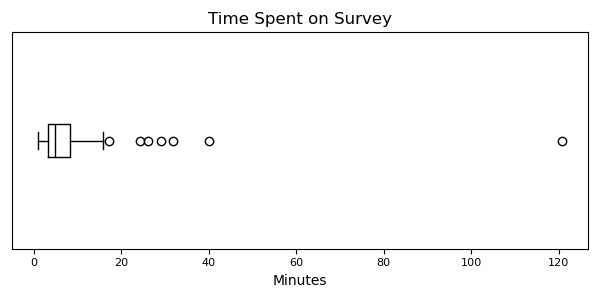

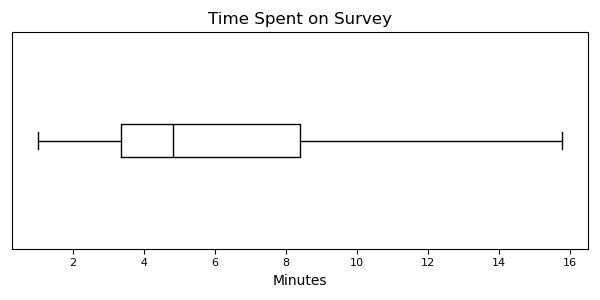

In [103]:
# survey time spent
time_data=[218,316,342,426,7245,742,804,181,99,154,1563,1916,234,162,434,2408,290,946,234,257,133,691,248,286,258,577,361,389,205,175,206,238,397,1746,357,426,269,349,524,818,219,211,92,478,641,484,264,197,290,89,117,149,1452,360,137,1036,80,62,190]
data=boxWhiskerSurvey("Time Spent on Survey",time_data,True)
saveImage(data[0],99,'survey_time_outliers')
display(data[0])

data=boxWhiskerSurvey("Time Spent on Survey",time_data,False)
saveImage(data[0],99,'survey_time')
display(data[0])

# TESTING

In [104]:
print(f"--- {getTimeFromSeconds(TIME.time() - START_TIME)} seconds ---")

--- 5:35 seconds ---


In [105]:
TESTING

NameError: name 'TESTING' is not defined

In [ ]:
names=['Less','More']
x,y = cropRoom1(ROOM1,SCALE1).size
img =Image.new('RGB',(x,y),(0,255,0))
draw = ImageDraw.Draw(img)
font= ImageFont.truetype("arial.ttf",48, encoding="unic")
for j in range(256):
    color = getPurpleColor(j/255)
    xw = x/4*3 
    xs = x/8
    draw.rectangle((xw/256*j+xs,y*3/8,xw/256*(j+1)+xs,y*5/8),fill=color)
for j in range(2):
    _, _, w, _ = draw.textbbox((0, 0), names[j], font=font)
    draw.text((xs-w/2+xw*j,y*5/8),names[j], font=font, fill=(0))
img

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(3)
plt.rc('font', size=12)  
plt.axis('off')
# plt.gca().set_axis_off()
# plt.gca().set_in_layout(False)
# ax.set_in_layout(False)
# ax.set_title('Seconds',fontsize=12,loc='left')

patches = []
for j in range(16):
    color = getPurpleColorFloat(j/15,1)
    patches.append(mpatches.Patch(color=color, label=f'value{j}'))

legend = plt.legend(handles=patches, ncol=2,loc=3, framealpha=1, frameon=False, title="title")
legend.figure.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
matplotToPil(fig, bbox)


#fig.tight_layout()
#plt.show()

# colors = ["crimson", "purple", "gold"]
# f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
# handles = [f("s", colors[i]) for i in range(3)]
# labels = colors
# legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

# def export_legend(legend, filename="legend.png"):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     #fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
#plt.show()


In [ ]:
math.copysign(1,-1)

In [ ]:
len(ROOM1_GROUP_SIZE)

In [ ]:
boolean(0)

In [ ]:
display(getPurpleColor(0,1))
display(getPurpleColor(1,1))
display(getPurpleColor(.5,1))

In [ ]:
d={'a':1,'b':2}
del d['a']
d

In [ ]:
img=Image.new('RGBA',(100,100),(255,255,255,255))
img2=Image.new('RGBA',(100,100),(255,0,0,100))
img.alpha_composite(img2)
img.alpha_composite(img2)
img.size
np.zeros(ROOM.size).shape
im=Image.new('1', (7,7))
np.array(im)

In [ ]:
{2: 6, 5: 1, 1: 21, 0: 66, 3: 3, 7: 1, 8: 1}.keys()

In [ ]:
(1,2)*(2,2)

In [ ]:
(1,2)[::-1]

In [ ]:
list(range(4,-1,-1))

In [ ]:
display(countPixelsStart(ROOM).shape)
np.array(Image.new('1', ROOM.size)).shape

In [ ]:
np.array([[1],[2],[3]])+np.array([4,5,6])

In [ ]:
s=np.array([[1,1],[2,3],[3,4]])
display(s.shape)
def c(s):
    return [s*10,0,0,0]
c(s)

In [ ]:
img1=Image.new('RGBA',ROOM2MASK.size,(0,0,255,255))
img2=Image.new('RGBA',ROOM2MASK.size,(255,0,0,255))
img1.paste(img2,(0,0),ROOM2MASK)
img1

In [ ]:
s=np.array([[1,2],[3,4],[5,6]])
s.shape
s[:,:,None]*[2,0,0,2]

In [ ]:
display(getDirOffset(-1))
display(getDirOffset(0))
display(getDirOffset(1))
display(getDirOffset(2))
display(getDirOffset(3))

In [ ]:
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#add passthough
#add 
dict(list(DISPLAY_BOXES1.items())[1:])
dict(list(DISPLAY_BOXES1.items())[:-2])

In [ ]:
array = {}
array[4]=4
array[6]=6

array[3:5]


In [ ]:
ROOM1

In [ ]:
a= np.zeros((4,8),dtype=np.uint32)+4
b=np.array([255,0,255],dtype=np.uint8)
c = np.tile(b, (4,8,1))
np.dstack((c,(a//2).astype(np.uint8)))
#np.hstack(c+a)
# RBG =  np.zeros((h,w)
# npbdstack((RGB, np.zeros((h,w,),dtype=np.uint32)+255))
#np.repeat([255,0,255],(8))
# np.array([255,0,255]

In [ ]:
cropRoom1(ROOM1,SCALE1)

In [ ]:
getNum('d_d_d_23')

In [ ]:
MAX_NEAR_ONE

In [ ]:
 [0]*4
np.max([1,2,3,4])
(1,2,3)[:3]

In [ ]:
a= np.array([1,2,3,4])
tuple(a[:3]) == (1,2,3)

In [ ]:
%%time
fn = lambda x: 255 if x[0] == 255 and x[1] == 255 and x[2] == 255 else 0
array = np.array(ROOM1)
maskData = np.array(np.apply_along_axis(fn,2,array),dtype=np.uint8)
mask = Image.fromarray(maskData)

In [ ]:
%%time
fn = lambda x: (int(x[0])+int(x[1])+int(x[2])) // (255*3) * 255
array = np.array(ROOM1)
maskData = np.array(np.apply_along_axis(fn,2,array),dtype=np.uint8)
mask = Image.fromarray(maskData)

In [ ]:
ROOM1MASK

In [ ]:
getTimeFromSeconds(61.23232)

In [ ]:
lessMoreScale(cropRoom1(ROOM1,SCALE1))

In [ ]:
ROOM1LEGEND.size

In [ ]:
ROOM1.size
getPurpleColor((1+1)/2,1)

# Todo

In [ ]:
V red to blue path
X #orange to blue case time
V user types 4 square
V white to purple
V graph of where images are
#case that is visited first - 4 second - visual
V first case to stop at
#put photo icon
V room2 dwell time left rectange cases
# ^ only people who went there

V compare room 1 to room 4 time spent 
V group size vs user type
V group size vs time spent
V time spent vs user type


# 1 2 3 4+

#fix behaviors to "Visitor behaviors in room x"

#19 add numbers above and below
#25 add numbers above and below

V 1-13 : 51 - 65 max fine
V 14 - 25 : 66 - 75 henry .97
V 26 - 50 nate .71